# Set Up
- Download the ECG dataset hosted on kaggle. **This step requires a Kaggle API token.**
- Clone the project repository to access the experiment models

In [1]:
!pip install -q kaggle
!pip install lime
!pip install torchviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=bbb96534db34a5fe34d8b34f4d0270b2467ac80bfba1a95ddbb243c801c13a74
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=8bc7fb95e37875f06d865feabf6130b69571392e18c372cdf6aac607fac0e9fc
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
from google.colab import files

uploaded = files.upload()

# make sure there is a kaggle.json file
!ls -lha kaggle.json

# install the Kaggle API token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 67 Dec  8 23:40 kaggle.json


In [3]:
# download and unzip the ECG dataset hosted on kaggle
!kaggle datasets download -d shayanfazeli/heartbeat
!unzip -q heartbeat.zip

# clone the project github repository
!git clone https://github.com/distributedgarden/tsc_attention.git

 96% 95.0M/98.8M [00:02<00:00, 43.9MB/s]
100% 98.8M/98.8M [00:02<00:00, 34.6MB/s]
Cloning into 'tsc_attention'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 386 (delta 92), reused 106 (delta 39), pack-reused 203
Receiving objects: 100% (386/386), 39.61 MiB | 12.78 MiB/s, done.
Resolving deltas: 100% (203/203), done.


# LSTM Experiment
### Description:
Use the ECG dataset and stratified k-fold cross validation to train the basic LSTM model and evaluate its performance.


### Steps:
1. split the ECG data into train and test subsets
1. preprocess the subsets (standard scaling)
1. convert to pytorch tensors
1. set up the LSTM model
1. train the LSTM model
1. evaluate performance with accuracy, F1 score, precision, recall

In [4]:
import logging
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torchviz import make_dot
from IPython.core.display import HTML
from itertools import cycle
from functools import partial


%cd tsc_attention
from src.models.lstm import LSTM
from src.models.attention_lstm import AttentionLSTM
from src.utils import (
    evaluate,
    plot_metrics,
    plot_incorrect_predictions,
    visualize_model_graph,
    sample,
    batch_predict,
    explain_instance,
    roc_plot,
    generate_saliency_map,
    saliency_maps,
    overlay_saliency_maps,
)
%cd ..



/content/tsc_attention
/content


In [5]:
logging.root.handlers = []

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

logging.info("Test")

2023-12-08 23:40:22,194 - root - INFO - Test


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# load data
train_df = pd.read_csv("mitbih_train.csv", header=None)
test_df = pd.read_csv("mitbih_test.csv", header=None)

# last column is the label
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

print(len(train_df))
print(len(test_df))
print(len(X_train[1]))
print(X_train[1])

87554
21892
187
[0.96011394 0.86324787 0.46153846 0.1965812  0.0940171  0.12535612
 0.0997151  0.08831909 0.07407407 0.08262108 0.07407407 0.06267806
 0.06552707 0.06552707 0.06267806 0.07692308 0.07122507 0.08262108
 0.09116809 0.09686609 0.08262108 0.08262108 0.09116809 0.10541311
 0.12250713 0.14814815 0.18233618 0.19373219 0.21367522 0.20797721
 0.22222222 0.25356126 0.27065527 0.28774929 0.28490028 0.29344729
 0.25641027 0.24786325 0.18803419 0.14529915 0.10826211 0.08262108
 0.07977208 0.07407407 0.01424501 0.01139601 0.06267806 0.05128205
 0.05698006 0.04843305 0.02849003 0.03133903 0.07692308 0.02564103
 0.02849003 0.03703704 0.0940171  0.08547009 0.03988604 0.05982906
 0.07407407 0.07977208 0.09116809 0.0997151  0.10826211 0.08831909
 0.09116809 0.06552707 0.08547009 0.08831909 0.07692308 0.08262108
 0.09686609 0.0997151  0.13390313 0.1025641  0.03988604 0.06552707
 0.07407407 0.08262108 0.08547009 0.05698006 0.04558405 0.1025641
 0.03988604 0.01139601 0.01709402 0.03133903 0.

In [8]:
# normalize the ECG signals
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# concatenate the data
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

# convert to tensors
X_tensor = torch.tensor(X).float().unsqueeze(2)  # adding channel dimension
y_tensor = torch.tensor(y).long()

# create a single dataset
dataset = TensorDataset(X_tensor, y_tensor)
dataset_y = np.array(dataset.tensors[1])

In [9]:
# cross-validation parameters
num_epochs = 10
k_folds = 10
#kfold = KFold(n_splits=k_folds, shuffle=True)
kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
batch_size = 32

In [10]:
epoch_acc, epoch_prc, epoch_rec, epoch_f1, epoch_losses = [], [], [], [], []

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset, dataset_y)):
    print(f"FOLD {fold}")
    print("--------------------------------")

    # store metrics of each fold
    accuracies, precisions, recalls, f1_scores, losses = [], [], [], [], []

    # split data
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # data loaders for training and testing data in this fold
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_subsampler)

    # set parameters
    input_dim = 1         # ECG data is univariate, so the input dimension is 1
    hidden_dim = 128
    num_layers = 2
    num_classes = 5

    # initialize model for this fold
    model = LSTM(input_dim, hidden_dim, num_layers, num_classes)
    model.to(device)
    print(model)

    # loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)


    # train
    for epoch in range(num_epochs):
        model.train()
        batch_losses = []

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

            if (i+1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        # store metrics
        accuracy, precision, recall, f1, _, _ = evaluate(model, test_loader)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        # Accumulate metrics for each epoch across folds
        if fold == 0:
            # Initialize lists in the first fold
            epoch_acc.append(accuracy)
            epoch_prc.append(precision)
            epoch_rec.append(recall)
            epoch_f1.append(f1)
            epoch_losses.append(batch_losses)
        else:
            # Add to existing totals for subsequent folds
            epoch_acc[epoch] += accuracy
            epoch_prc[epoch] += precision
            epoch_rec[epoch] += recall
            epoch_f1[epoch] += f1
            epoch_losses[epoch].extend(batch_losses)

# Average metrics across all folds for each epoch
epoch_acc = [x / k_folds for x in epoch_acc]
epoch_prc = [x / k_folds for x in epoch_prc]
epoch_rec = [x / k_folds for x in epoch_rec]
epoch_f1 = [x / k_folds for x in epoch_f1]
epoch_losses = [sum(x) / len(x) for x in epoch_losses]

# Print average metrics for each epoch
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} - Avg Accuracy: {epoch_acc[epoch]}, Avg Precision: {epoch_prc[epoch]}, Avg Recall: {epoch_rec[epoch]}, Avg F1 Score: {epoch_f1[epoch]}, Avg Loss: {epoch_losses[epoch]}")

FOLD 0
--------------------------------
LSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.6216
Epoch [1/10], Step [200/3079], Loss: 0.7367
Epoch [1/10], Step [300/3079], Loss: 0.4436
Epoch [1/10], Step [400/3079], Loss: 0.8572
Epoch [1/10], Step [500/3079], Loss: 0.3176
Epoch [1/10], Step [600/3079], Loss: 0.2729
Epoch [1/10], Step [700/3079], Loss: 0.6514
Epoch [1/10], Step [800/3079], Loss: 0.7351
Epoch [1/10], Step [900/3079], Loss: 0.8326
Epoch [1/10], Step [1000/3079], Loss: 0.1869
Epoch [1/10], Step [1100/3079], Loss: 1.2093
Epoch [1/10], Step [1200/3079], Loss: 0.1946
Epoch [1/10], Step [1300/3079], Loss: 0.5583
Epoch [1/10], Step [1400/3079], Loss: 0.4635
Epoch [1/10], Step [1500/3079], Loss: 0.3677
Epoch [1/10], Step [1600/3079], Loss: 0.5225
Epoch [1/10], Step [1700/3079], Loss: 0.2508
Epoch [1/10], Step [1800/3079], Loss: 0.4091
Epoch [1/10], Step [1900/3079], Loss:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:40:53,020 - root - INFO - Accuracy: 91.83%
2023-12-08 23:40:53,021 - root - INFO - Precision: 0.8859
2023-12-08 23:40:53,022 - root - INFO - Recall: 0.9183
2023-12-08 23:40:53,023 - root - INFO - F1 Score: 0.8995


Epoch [2/10], Step [100/3079], Loss: 0.1858
Epoch [2/10], Step [200/3079], Loss: 0.3371
Epoch [2/10], Step [300/3079], Loss: 0.4346
Epoch [2/10], Step [400/3079], Loss: 0.1732
Epoch [2/10], Step [500/3079], Loss: 0.5001
Epoch [2/10], Step [600/3079], Loss: 0.2044
Epoch [2/10], Step [700/3079], Loss: 0.2685
Epoch [2/10], Step [800/3079], Loss: 0.2677
Epoch [2/10], Step [900/3079], Loss: 0.2725
Epoch [2/10], Step [1000/3079], Loss: 0.2947
Epoch [2/10], Step [1100/3079], Loss: 0.1430
Epoch [2/10], Step [1200/3079], Loss: 0.1972
Epoch [2/10], Step [1300/3079], Loss: 0.0604
Epoch [2/10], Step [1400/3079], Loss: 0.6006
Epoch [2/10], Step [1500/3079], Loss: 0.1372
Epoch [2/10], Step [1600/3079], Loss: 0.3527
Epoch [2/10], Step [1700/3079], Loss: 0.0473
Epoch [2/10], Step [1800/3079], Loss: 0.2126
Epoch [2/10], Step [1900/3079], Loss: 0.0617
Epoch [2/10], Step [2000/3079], Loss: 0.0586
Epoch [2/10], Step [2100/3079], Loss: 0.2383
Epoch [2/10], Step [2200/3079], Loss: 0.3458
Epoch [2/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:41:07,519 - root - INFO - Accuracy: 94.50%
2023-12-08 23:41:07,520 - root - INFO - Precision: 0.9377
2023-12-08 23:41:07,521 - root - INFO - Recall: 0.9450
2023-12-08 23:41:07,522 - root - INFO - F1 Score: 0.9325


Epoch [3/10], Step [100/3079], Loss: 0.6376
Epoch [3/10], Step [200/3079], Loss: 0.0387
Epoch [3/10], Step [300/3079], Loss: 0.2143
Epoch [3/10], Step [400/3079], Loss: 0.1273
Epoch [3/10], Step [500/3079], Loss: 0.0923
Epoch [3/10], Step [600/3079], Loss: 0.1192
Epoch [3/10], Step [700/3079], Loss: 0.5036
Epoch [3/10], Step [800/3079], Loss: 0.2997
Epoch [3/10], Step [900/3079], Loss: 0.2298
Epoch [3/10], Step [1000/3079], Loss: 0.1572
Epoch [3/10], Step [1100/3079], Loss: 0.1903
Epoch [3/10], Step [1200/3079], Loss: 0.1805
Epoch [3/10], Step [1300/3079], Loss: 0.2283
Epoch [3/10], Step [1400/3079], Loss: 0.1594
Epoch [3/10], Step [1500/3079], Loss: 0.2977
Epoch [3/10], Step [1600/3079], Loss: 0.3555
Epoch [3/10], Step [1700/3079], Loss: 0.3133
Epoch [3/10], Step [1800/3079], Loss: 0.4211
Epoch [3/10], Step [1900/3079], Loss: 0.0593
Epoch [3/10], Step [2000/3079], Loss: 0.1327
Epoch [3/10], Step [2100/3079], Loss: 0.4729
Epoch [3/10], Step [2200/3079], Loss: 0.5708
Epoch [3/10], Step 

2023-12-08 23:41:21,745 - root - INFO - Accuracy: 94.94%
2023-12-08 23:41:21,746 - root - INFO - Precision: 0.9454
2023-12-08 23:41:21,747 - root - INFO - Recall: 0.9494
2023-12-08 23:41:21,750 - root - INFO - F1 Score: 0.9425


Epoch [4/10], Step [100/3079], Loss: 0.1381
Epoch [4/10], Step [200/3079], Loss: 0.0640
Epoch [4/10], Step [300/3079], Loss: 0.2719
Epoch [4/10], Step [400/3079], Loss: 0.2412
Epoch [4/10], Step [500/3079], Loss: 0.1715
Epoch [4/10], Step [600/3079], Loss: 0.1297
Epoch [4/10], Step [700/3079], Loss: 0.2947
Epoch [4/10], Step [800/3079], Loss: 0.0236
Epoch [4/10], Step [900/3079], Loss: 0.2307
Epoch [4/10], Step [1000/3079], Loss: 0.1198
Epoch [4/10], Step [1100/3079], Loss: 0.2440
Epoch [4/10], Step [1200/3079], Loss: 0.1413
Epoch [4/10], Step [1300/3079], Loss: 0.0499
Epoch [4/10], Step [1400/3079], Loss: 0.2547
Epoch [4/10], Step [1500/3079], Loss: 0.1094
Epoch [4/10], Step [1600/3079], Loss: 0.1292
Epoch [4/10], Step [1700/3079], Loss: 0.0381
Epoch [4/10], Step [1800/3079], Loss: 0.4614
Epoch [4/10], Step [1900/3079], Loss: 0.1206
Epoch [4/10], Step [2000/3079], Loss: 0.2281
Epoch [4/10], Step [2100/3079], Loss: 0.0579
Epoch [4/10], Step [2200/3079], Loss: 0.5158
Epoch [4/10], Step 

2023-12-08 23:41:36,081 - root - INFO - Accuracy: 95.86%
2023-12-08 23:41:36,082 - root - INFO - Precision: 0.9576
2023-12-08 23:41:36,083 - root - INFO - Recall: 0.9586
2023-12-08 23:41:36,084 - root - INFO - F1 Score: 0.9575


Epoch [5/10], Step [100/3079], Loss: 0.2803
Epoch [5/10], Step [200/3079], Loss: 0.1705
Epoch [5/10], Step [300/3079], Loss: 0.1831
Epoch [5/10], Step [400/3079], Loss: 0.2101
Epoch [5/10], Step [500/3079], Loss: 0.2377
Epoch [5/10], Step [600/3079], Loss: 0.2335
Epoch [5/10], Step [700/3079], Loss: 0.2244
Epoch [5/10], Step [800/3079], Loss: 0.0909
Epoch [5/10], Step [900/3079], Loss: 0.2489
Epoch [5/10], Step [1000/3079], Loss: 0.3973
Epoch [5/10], Step [1100/3079], Loss: 0.0250
Epoch [5/10], Step [1200/3079], Loss: 0.3260
Epoch [5/10], Step [1300/3079], Loss: 0.1420
Epoch [5/10], Step [1400/3079], Loss: 0.0834
Epoch [5/10], Step [1500/3079], Loss: 0.1760
Epoch [5/10], Step [1600/3079], Loss: 0.2314
Epoch [5/10], Step [1700/3079], Loss: 0.0623
Epoch [5/10], Step [1800/3079], Loss: 0.1416
Epoch [5/10], Step [1900/3079], Loss: 0.0217
Epoch [5/10], Step [2000/3079], Loss: 0.1269
Epoch [5/10], Step [2100/3079], Loss: 0.0395
Epoch [5/10], Step [2200/3079], Loss: 0.0937
Epoch [5/10], Step 

2023-12-08 23:41:50,457 - root - INFO - Accuracy: 96.99%
2023-12-08 23:41:50,458 - root - INFO - Precision: 0.9687
2023-12-08 23:41:50,460 - root - INFO - Recall: 0.9699
2023-12-08 23:41:50,461 - root - INFO - F1 Score: 0.9682


Epoch [6/10], Step [100/3079], Loss: 0.1772
Epoch [6/10], Step [200/3079], Loss: 0.2507
Epoch [6/10], Step [300/3079], Loss: 0.0776
Epoch [6/10], Step [400/3079], Loss: 0.0529
Epoch [6/10], Step [500/3079], Loss: 0.0104
Epoch [6/10], Step [600/3079], Loss: 0.0118
Epoch [6/10], Step [700/3079], Loss: 0.0152
Epoch [6/10], Step [800/3079], Loss: 0.1917
Epoch [6/10], Step [900/3079], Loss: 0.1928
Epoch [6/10], Step [1000/3079], Loss: 0.0577
Epoch [6/10], Step [1100/3079], Loss: 0.4334
Epoch [6/10], Step [1200/3079], Loss: 0.0540
Epoch [6/10], Step [1300/3079], Loss: 0.0991
Epoch [6/10], Step [1400/3079], Loss: 0.0225
Epoch [6/10], Step [1500/3079], Loss: 0.1667
Epoch [6/10], Step [1600/3079], Loss: 0.0344
Epoch [6/10], Step [1700/3079], Loss: 0.1813
Epoch [6/10], Step [1800/3079], Loss: 0.0236
Epoch [6/10], Step [1900/3079], Loss: 0.0662
Epoch [6/10], Step [2000/3079], Loss: 0.1342
Epoch [6/10], Step [2100/3079], Loss: 0.0803
Epoch [6/10], Step [2200/3079], Loss: 0.0210
Epoch [6/10], Step 

2023-12-08 23:42:04,902 - root - INFO - Accuracy: 96.87%
2023-12-08 23:42:04,903 - root - INFO - Precision: 0.9679
2023-12-08 23:42:04,904 - root - INFO - Recall: 0.9687
2023-12-08 23:42:04,905 - root - INFO - F1 Score: 0.9665


Epoch [7/10], Step [100/3079], Loss: 0.0244
Epoch [7/10], Step [200/3079], Loss: 0.0509
Epoch [7/10], Step [300/3079], Loss: 0.0337
Epoch [7/10], Step [400/3079], Loss: 0.0127
Epoch [7/10], Step [500/3079], Loss: 0.2858
Epoch [7/10], Step [600/3079], Loss: 0.3418
Epoch [7/10], Step [700/3079], Loss: 0.0158
Epoch [7/10], Step [800/3079], Loss: 0.3451
Epoch [7/10], Step [900/3079], Loss: 0.4582
Epoch [7/10], Step [1000/3079], Loss: 0.0198
Epoch [7/10], Step [1100/3079], Loss: 0.1440
Epoch [7/10], Step [1200/3079], Loss: 0.1241
Epoch [7/10], Step [1300/3079], Loss: 0.1006
Epoch [7/10], Step [1400/3079], Loss: 0.1187
Epoch [7/10], Step [1500/3079], Loss: 0.0205
Epoch [7/10], Step [1600/3079], Loss: 0.0159
Epoch [7/10], Step [1700/3079], Loss: 0.2230
Epoch [7/10], Step [1800/3079], Loss: 0.0333
Epoch [7/10], Step [1900/3079], Loss: 0.0157
Epoch [7/10], Step [2000/3079], Loss: 0.0340
Epoch [7/10], Step [2100/3079], Loss: 0.0370
Epoch [7/10], Step [2200/3079], Loss: 0.1631
Epoch [7/10], Step 

2023-12-08 23:42:19,357 - root - INFO - Accuracy: 97.20%
2023-12-08 23:42:19,358 - root - INFO - Precision: 0.9713
2023-12-08 23:42:19,360 - root - INFO - Recall: 0.9720
2023-12-08 23:42:19,361 - root - INFO - F1 Score: 0.9707


Epoch [8/10], Step [100/3079], Loss: 0.1226
Epoch [8/10], Step [200/3079], Loss: 0.2061
Epoch [8/10], Step [300/3079], Loss: 0.1103
Epoch [8/10], Step [400/3079], Loss: 0.1305
Epoch [8/10], Step [500/3079], Loss: 0.1012
Epoch [8/10], Step [600/3079], Loss: 0.0284
Epoch [8/10], Step [700/3079], Loss: 0.2167
Epoch [8/10], Step [800/3079], Loss: 0.1720
Epoch [8/10], Step [900/3079], Loss: 0.0434
Epoch [8/10], Step [1000/3079], Loss: 0.0235
Epoch [8/10], Step [1100/3079], Loss: 0.1785
Epoch [8/10], Step [1200/3079], Loss: 0.1558
Epoch [8/10], Step [1300/3079], Loss: 0.0869
Epoch [8/10], Step [1400/3079], Loss: 0.0599
Epoch [8/10], Step [1500/3079], Loss: 0.1315
Epoch [8/10], Step [1600/3079], Loss: 0.0215
Epoch [8/10], Step [1700/3079], Loss: 0.0686
Epoch [8/10], Step [1800/3079], Loss: 0.3379
Epoch [8/10], Step [1900/3079], Loss: 0.3145
Epoch [8/10], Step [2000/3079], Loss: 0.0477
Epoch [8/10], Step [2100/3079], Loss: 0.1568
Epoch [8/10], Step [2200/3079], Loss: 0.0073
Epoch [8/10], Step 

2023-12-08 23:42:33,560 - root - INFO - Accuracy: 97.60%
2023-12-08 23:42:33,561 - root - INFO - Precision: 0.9753
2023-12-08 23:42:33,562 - root - INFO - Recall: 0.9760
2023-12-08 23:42:33,563 - root - INFO - F1 Score: 0.9749


Epoch [9/10], Step [100/3079], Loss: 0.0072
Epoch [9/10], Step [200/3079], Loss: 0.2047
Epoch [9/10], Step [300/3079], Loss: 0.0494
Epoch [9/10], Step [400/3079], Loss: 0.1508
Epoch [9/10], Step [500/3079], Loss: 0.0256
Epoch [9/10], Step [600/3079], Loss: 0.0534
Epoch [9/10], Step [700/3079], Loss: 0.1059
Epoch [9/10], Step [800/3079], Loss: 0.0794
Epoch [9/10], Step [900/3079], Loss: 0.0367
Epoch [9/10], Step [1000/3079], Loss: 0.0380
Epoch [9/10], Step [1100/3079], Loss: 0.3607
Epoch [9/10], Step [1200/3079], Loss: 0.0667
Epoch [9/10], Step [1300/3079], Loss: 0.0240
Epoch [9/10], Step [1400/3079], Loss: 0.0119
Epoch [9/10], Step [1500/3079], Loss: 0.0692
Epoch [9/10], Step [1600/3079], Loss: 0.0955
Epoch [9/10], Step [1700/3079], Loss: 0.0168
Epoch [9/10], Step [1800/3079], Loss: 0.0951
Epoch [9/10], Step [1900/3079], Loss: 0.0324
Epoch [9/10], Step [2000/3079], Loss: 0.0815
Epoch [9/10], Step [2100/3079], Loss: 0.0046
Epoch [9/10], Step [2200/3079], Loss: 0.0755
Epoch [9/10], Step 

2023-12-08 23:42:47,907 - root - INFO - Accuracy: 97.36%
2023-12-08 23:42:47,908 - root - INFO - Precision: 0.9723
2023-12-08 23:42:47,909 - root - INFO - Recall: 0.9736
2023-12-08 23:42:47,910 - root - INFO - F1 Score: 0.9721


Epoch [10/10], Step [100/3079], Loss: 0.0267
Epoch [10/10], Step [200/3079], Loss: 0.0199
Epoch [10/10], Step [300/3079], Loss: 0.0547
Epoch [10/10], Step [400/3079], Loss: 0.2075
Epoch [10/10], Step [500/3079], Loss: 0.1418
Epoch [10/10], Step [600/3079], Loss: 0.1978
Epoch [10/10], Step [700/3079], Loss: 0.0198
Epoch [10/10], Step [800/3079], Loss: 0.2729
Epoch [10/10], Step [900/3079], Loss: 0.0105
Epoch [10/10], Step [1000/3079], Loss: 0.1861
Epoch [10/10], Step [1100/3079], Loss: 0.0303
Epoch [10/10], Step [1200/3079], Loss: 0.0193
Epoch [10/10], Step [1300/3079], Loss: 0.0292
Epoch [10/10], Step [1400/3079], Loss: 0.2559
Epoch [10/10], Step [1500/3079], Loss: 0.2772
Epoch [10/10], Step [1600/3079], Loss: 0.0971
Epoch [10/10], Step [1700/3079], Loss: 0.1481
Epoch [10/10], Step [1800/3079], Loss: 0.0522
Epoch [10/10], Step [1900/3079], Loss: 0.0324
Epoch [10/10], Step [2000/3079], Loss: 0.0173
Epoch [10/10], Step [2100/3079], Loss: 0.2340
Epoch [10/10], Step [2200/3079], Loss: 0.00

2023-12-08 23:43:02,167 - root - INFO - Accuracy: 97.73%
2023-12-08 23:43:02,168 - root - INFO - Precision: 0.9773
2023-12-08 23:43:02,169 - root - INFO - Recall: 0.9773
2023-12-08 23:43:02,170 - root - INFO - F1 Score: 0.9754


FOLD 1
--------------------------------
LSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.7032
Epoch [1/10], Step [200/3079], Loss: 0.7257
Epoch [1/10], Step [300/3079], Loss: 0.4245
Epoch [1/10], Step [400/3079], Loss: 0.6516
Epoch [1/10], Step [500/3079], Loss: 0.6068
Epoch [1/10], Step [600/3079], Loss: 0.7999
Epoch [1/10], Step [700/3079], Loss: 0.6386
Epoch [1/10], Step [800/3079], Loss: 0.5086
Epoch [1/10], Step [900/3079], Loss: 0.5057
Epoch [1/10], Step [1000/3079], Loss: 0.7715
Epoch [1/10], Step [1100/3079], Loss: 0.5969
Epoch [1/10], Step [1200/3079], Loss: 0.8779
Epoch [1/10], Step [1300/3079], Loss: 0.8288
Epoch [1/10], Step [1400/3079], Loss: 0.5979
Epoch [1/10], Step [1500/3079], Loss: 1.0767
Epoch [1/10], Step [1600/3079], Loss: 0.4854
Epoch [1/10], Step [1700/3079], Loss: 0.3121
Epoch [1/10], Step [1800/3079], Loss: 0.5778
Epoch [1/10], Step [1900/3079], Loss:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:43:16,446 - root - INFO - Accuracy: 91.03%
2023-12-08 23:43:16,447 - root - INFO - Precision: 0.8851
2023-12-08 23:43:16,447 - root - INFO - Recall: 0.9103
2023-12-08 23:43:16,448 - root - INFO - F1 Score: 0.8937


Epoch [2/10], Step [100/3079], Loss: 0.2595
Epoch [2/10], Step [200/3079], Loss: 0.1891
Epoch [2/10], Step [300/3079], Loss: 0.2715
Epoch [2/10], Step [400/3079], Loss: 0.4006
Epoch [2/10], Step [500/3079], Loss: 0.1981
Epoch [2/10], Step [600/3079], Loss: 0.8382
Epoch [2/10], Step [700/3079], Loss: 0.2046
Epoch [2/10], Step [800/3079], Loss: 0.3029
Epoch [2/10], Step [900/3079], Loss: 0.2526
Epoch [2/10], Step [1000/3079], Loss: 0.2147
Epoch [2/10], Step [1100/3079], Loss: 0.1206
Epoch [2/10], Step [1200/3079], Loss: 0.3473
Epoch [2/10], Step [1300/3079], Loss: 0.2785
Epoch [2/10], Step [1400/3079], Loss: 0.1816
Epoch [2/10], Step [1500/3079], Loss: 0.2144
Epoch [2/10], Step [1600/3079], Loss: 0.0387
Epoch [2/10], Step [1700/3079], Loss: 0.3095
Epoch [2/10], Step [1800/3079], Loss: 0.3366
Epoch [2/10], Step [1900/3079], Loss: 0.1383
Epoch [2/10], Step [2000/3079], Loss: 0.2724
Epoch [2/10], Step [2100/3079], Loss: 0.5370
Epoch [2/10], Step [2200/3079], Loss: 0.1874
Epoch [2/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:43:30,723 - root - INFO - Accuracy: 93.46%
2023-12-08 23:43:30,724 - root - INFO - Precision: 0.9233
2023-12-08 23:43:30,725 - root - INFO - Recall: 0.9346
2023-12-08 23:43:30,726 - root - INFO - F1 Score: 0.9220


Epoch [3/10], Step [100/3079], Loss: 0.2067
Epoch [3/10], Step [200/3079], Loss: 0.4576
Epoch [3/10], Step [300/3079], Loss: 0.4308
Epoch [3/10], Step [400/3079], Loss: 0.4500
Epoch [3/10], Step [500/3079], Loss: 0.0453
Epoch [3/10], Step [600/3079], Loss: 0.0835
Epoch [3/10], Step [700/3079], Loss: 0.1526
Epoch [3/10], Step [800/3079], Loss: 0.2175
Epoch [3/10], Step [900/3079], Loss: 0.3104
Epoch [3/10], Step [1000/3079], Loss: 0.0168
Epoch [3/10], Step [1100/3079], Loss: 0.0597
Epoch [3/10], Step [1200/3079], Loss: 0.1642
Epoch [3/10], Step [1300/3079], Loss: 0.6984
Epoch [3/10], Step [1400/3079], Loss: 0.2725
Epoch [3/10], Step [1500/3079], Loss: 0.2602
Epoch [3/10], Step [1600/3079], Loss: 0.5390
Epoch [3/10], Step [1700/3079], Loss: 0.2777
Epoch [3/10], Step [1800/3079], Loss: 0.2954
Epoch [3/10], Step [1900/3079], Loss: 0.3954
Epoch [3/10], Step [2000/3079], Loss: 0.2904
Epoch [3/10], Step [2100/3079], Loss: 0.2406
Epoch [3/10], Step [2200/3079], Loss: 0.2573
Epoch [3/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:43:44,994 - root - INFO - Accuracy: 95.03%
2023-12-08 23:43:44,995 - root - INFO - Precision: 0.9419
2023-12-08 23:43:44,996 - root - INFO - Recall: 0.9503
2023-12-08 23:43:44,997 - root - INFO - F1 Score: 0.9446


Epoch [4/10], Step [100/3079], Loss: 0.2950
Epoch [4/10], Step [200/3079], Loss: 0.1083
Epoch [4/10], Step [300/3079], Loss: 0.0325
Epoch [4/10], Step [400/3079], Loss: 0.1754
Epoch [4/10], Step [500/3079], Loss: 0.2752
Epoch [4/10], Step [600/3079], Loss: 0.0718
Epoch [4/10], Step [700/3079], Loss: 0.3387
Epoch [4/10], Step [800/3079], Loss: 0.2687
Epoch [4/10], Step [900/3079], Loss: 0.3020
Epoch [4/10], Step [1000/3079], Loss: 0.4039
Epoch [4/10], Step [1100/3079], Loss: 0.4324
Epoch [4/10], Step [1200/3079], Loss: 0.0705
Epoch [4/10], Step [1300/3079], Loss: 0.1211
Epoch [4/10], Step [1400/3079], Loss: 0.2291
Epoch [4/10], Step [1500/3079], Loss: 0.1707
Epoch [4/10], Step [1600/3079], Loss: 0.2837
Epoch [4/10], Step [1700/3079], Loss: 0.1237
Epoch [4/10], Step [1800/3079], Loss: 0.1322
Epoch [4/10], Step [1900/3079], Loss: 0.0345
Epoch [4/10], Step [2000/3079], Loss: 0.0677
Epoch [4/10], Step [2100/3079], Loss: 0.1972
Epoch [4/10], Step [2200/3079], Loss: 0.3078
Epoch [4/10], Step 

2023-12-08 23:43:59,261 - root - INFO - Accuracy: 95.83%
2023-12-08 23:43:59,263 - root - INFO - Precision: 0.9502
2023-12-08 23:43:59,263 - root - INFO - Recall: 0.9583
2023-12-08 23:43:59,266 - root - INFO - F1 Score: 0.9530


Epoch [5/10], Step [100/3079], Loss: 0.1792
Epoch [5/10], Step [200/3079], Loss: 0.1053
Epoch [5/10], Step [300/3079], Loss: 0.1040
Epoch [5/10], Step [400/3079], Loss: 0.3454
Epoch [5/10], Step [500/3079], Loss: 0.0787
Epoch [5/10], Step [600/3079], Loss: 0.3630
Epoch [5/10], Step [700/3079], Loss: 0.3236
Epoch [5/10], Step [800/3079], Loss: 0.1938
Epoch [5/10], Step [900/3079], Loss: 0.2137
Epoch [5/10], Step [1000/3079], Loss: 0.0539
Epoch [5/10], Step [1100/3079], Loss: 0.0622
Epoch [5/10], Step [1200/3079], Loss: 0.0249
Epoch [5/10], Step [1300/3079], Loss: 0.1694
Epoch [5/10], Step [1400/3079], Loss: 0.0990
Epoch [5/10], Step [1500/3079], Loss: 0.2522
Epoch [5/10], Step [1600/3079], Loss: 0.1811
Epoch [5/10], Step [1700/3079], Loss: 0.0798
Epoch [5/10], Step [1800/3079], Loss: 0.0534
Epoch [5/10], Step [1900/3079], Loss: 0.0752
Epoch [5/10], Step [2000/3079], Loss: 0.1179
Epoch [5/10], Step [2100/3079], Loss: 0.0782
Epoch [5/10], Step [2200/3079], Loss: 0.1918
Epoch [5/10], Step 

2023-12-08 23:44:13,518 - root - INFO - Accuracy: 95.97%
2023-12-08 23:44:13,520 - root - INFO - Precision: 0.9582
2023-12-08 23:44:13,520 - root - INFO - Recall: 0.9597
2023-12-08 23:44:13,521 - root - INFO - F1 Score: 0.9577


Epoch [6/10], Step [100/3079], Loss: 0.2428
Epoch [6/10], Step [200/3079], Loss: 0.0088
Epoch [6/10], Step [300/3079], Loss: 0.1395
Epoch [6/10], Step [400/3079], Loss: 0.1723
Epoch [6/10], Step [500/3079], Loss: 0.0286
Epoch [6/10], Step [600/3079], Loss: 0.1333
Epoch [6/10], Step [700/3079], Loss: 0.0236
Epoch [6/10], Step [800/3079], Loss: 0.1439
Epoch [6/10], Step [900/3079], Loss: 0.0711
Epoch [6/10], Step [1000/3079], Loss: 0.2390
Epoch [6/10], Step [1100/3079], Loss: 0.0272
Epoch [6/10], Step [1200/3079], Loss: 0.2028
Epoch [6/10], Step [1300/3079], Loss: 0.0783
Epoch [6/10], Step [1400/3079], Loss: 0.0956
Epoch [6/10], Step [1500/3079], Loss: 0.0756
Epoch [6/10], Step [1600/3079], Loss: 0.1253
Epoch [6/10], Step [1700/3079], Loss: 0.0302
Epoch [6/10], Step [1800/3079], Loss: 0.0267
Epoch [6/10], Step [1900/3079], Loss: 0.1331
Epoch [6/10], Step [2000/3079], Loss: 0.3684
Epoch [6/10], Step [2100/3079], Loss: 0.0322
Epoch [6/10], Step [2200/3079], Loss: 0.0799
Epoch [6/10], Step 

2023-12-08 23:44:27,607 - root - INFO - Accuracy: 96.69%
2023-12-08 23:44:27,608 - root - INFO - Precision: 0.9664
2023-12-08 23:44:27,609 - root - INFO - Recall: 0.9669
2023-12-08 23:44:27,610 - root - INFO - F1 Score: 0.9655


Epoch [7/10], Step [100/3079], Loss: 0.0116
Epoch [7/10], Step [200/3079], Loss: 0.1972
Epoch [7/10], Step [300/3079], Loss: 0.0259
Epoch [7/10], Step [400/3079], Loss: 0.4084
Epoch [7/10], Step [500/3079], Loss: 0.0141
Epoch [7/10], Step [600/3079], Loss: 0.0292
Epoch [7/10], Step [700/3079], Loss: 0.1306
Epoch [7/10], Step [800/3079], Loss: 0.2026
Epoch [7/10], Step [900/3079], Loss: 0.1128
Epoch [7/10], Step [1000/3079], Loss: 0.1888
Epoch [7/10], Step [1100/3079], Loss: 0.0087
Epoch [7/10], Step [1200/3079], Loss: 0.0787
Epoch [7/10], Step [1300/3079], Loss: 0.0467
Epoch [7/10], Step [1400/3079], Loss: 0.2622
Epoch [7/10], Step [1500/3079], Loss: 0.0180
Epoch [7/10], Step [1600/3079], Loss: 0.0956
Epoch [7/10], Step [1700/3079], Loss: 0.0168
Epoch [7/10], Step [1800/3079], Loss: 0.1154
Epoch [7/10], Step [1900/3079], Loss: 0.0274
Epoch [7/10], Step [2000/3079], Loss: 0.0445
Epoch [7/10], Step [2100/3079], Loss: 0.0618
Epoch [7/10], Step [2200/3079], Loss: 0.1039
Epoch [7/10], Step 

2023-12-08 23:44:41,874 - root - INFO - Accuracy: 97.31%
2023-12-08 23:44:41,876 - root - INFO - Precision: 0.9726
2023-12-08 23:44:41,876 - root - INFO - Recall: 0.9731
2023-12-08 23:44:41,877 - root - INFO - F1 Score: 0.9721


Epoch [8/10], Step [100/3079], Loss: 0.1401
Epoch [8/10], Step [200/3079], Loss: 0.0727
Epoch [8/10], Step [300/3079], Loss: 0.1287
Epoch [8/10], Step [400/3079], Loss: 0.1834
Epoch [8/10], Step [500/3079], Loss: 0.0839
Epoch [8/10], Step [600/3079], Loss: 0.0412
Epoch [8/10], Step [700/3079], Loss: 0.0283
Epoch [8/10], Step [800/3079], Loss: 0.2324
Epoch [8/10], Step [900/3079], Loss: 0.1593
Epoch [8/10], Step [1000/3079], Loss: 0.1472
Epoch [8/10], Step [1100/3079], Loss: 0.0758
Epoch [8/10], Step [1200/3079], Loss: 0.0234
Epoch [8/10], Step [1300/3079], Loss: 0.0776
Epoch [8/10], Step [1400/3079], Loss: 0.1229
Epoch [8/10], Step [1500/3079], Loss: 0.0262
Epoch [8/10], Step [1600/3079], Loss: 0.0255
Epoch [8/10], Step [1700/3079], Loss: 0.0320
Epoch [8/10], Step [1800/3079], Loss: 0.1053
Epoch [8/10], Step [1900/3079], Loss: 0.1646
Epoch [8/10], Step [2000/3079], Loss: 0.0189
Epoch [8/10], Step [2100/3079], Loss: 0.0239
Epoch [8/10], Step [2200/3079], Loss: 0.0297
Epoch [8/10], Step 

2023-12-08 23:44:56,188 - root - INFO - Accuracy: 97.69%
2023-12-08 23:44:56,189 - root - INFO - Precision: 0.9762
2023-12-08 23:44:56,190 - root - INFO - Recall: 0.9769
2023-12-08 23:44:56,191 - root - INFO - F1 Score: 0.9759


Epoch [9/10], Step [100/3079], Loss: 0.0159
Epoch [9/10], Step [200/3079], Loss: 0.1296
Epoch [9/10], Step [300/3079], Loss: 0.0318
Epoch [9/10], Step [400/3079], Loss: 0.0922
Epoch [9/10], Step [500/3079], Loss: 0.0129
Epoch [9/10], Step [600/3079], Loss: 0.3326
Epoch [9/10], Step [700/3079], Loss: 0.0102
Epoch [9/10], Step [800/3079], Loss: 0.1528
Epoch [9/10], Step [900/3079], Loss: 0.0171
Epoch [9/10], Step [1000/3079], Loss: 0.0180
Epoch [9/10], Step [1100/3079], Loss: 0.0432
Epoch [9/10], Step [1200/3079], Loss: 0.0719
Epoch [9/10], Step [1300/3079], Loss: 0.0080
Epoch [9/10], Step [1400/3079], Loss: 0.0272
Epoch [9/10], Step [1500/3079], Loss: 0.0833
Epoch [9/10], Step [1600/3079], Loss: 0.1216
Epoch [9/10], Step [1700/3079], Loss: 0.2400
Epoch [9/10], Step [1800/3079], Loss: 0.0196
Epoch [9/10], Step [1900/3079], Loss: 0.1578
Epoch [9/10], Step [2000/3079], Loss: 0.1549
Epoch [9/10], Step [2100/3079], Loss: 0.4992
Epoch [9/10], Step [2200/3079], Loss: 0.0399
Epoch [9/10], Step 

2023-12-08 23:45:10,456 - root - INFO - Accuracy: 97.31%
2023-12-08 23:45:10,457 - root - INFO - Precision: 0.9727
2023-12-08 23:45:10,459 - root - INFO - Recall: 0.9731
2023-12-08 23:45:10,460 - root - INFO - F1 Score: 0.9720


Epoch [10/10], Step [100/3079], Loss: 0.1001
Epoch [10/10], Step [200/3079], Loss: 0.0088
Epoch [10/10], Step [300/3079], Loss: 0.0665
Epoch [10/10], Step [400/3079], Loss: 0.0110
Epoch [10/10], Step [500/3079], Loss: 0.0078
Epoch [10/10], Step [600/3079], Loss: 0.1105
Epoch [10/10], Step [700/3079], Loss: 0.0857
Epoch [10/10], Step [800/3079], Loss: 0.1949
Epoch [10/10], Step [900/3079], Loss: 0.0273
Epoch [10/10], Step [1000/3079], Loss: 0.0124
Epoch [10/10], Step [1100/3079], Loss: 0.0128
Epoch [10/10], Step [1200/3079], Loss: 0.0222
Epoch [10/10], Step [1300/3079], Loss: 0.0047
Epoch [10/10], Step [1400/3079], Loss: 0.1097
Epoch [10/10], Step [1500/3079], Loss: 0.1585
Epoch [10/10], Step [1600/3079], Loss: 0.0356
Epoch [10/10], Step [1700/3079], Loss: 0.0332
Epoch [10/10], Step [1800/3079], Loss: 0.0645
Epoch [10/10], Step [1900/3079], Loss: 0.0158
Epoch [10/10], Step [2000/3079], Loss: 0.0171
Epoch [10/10], Step [2100/3079], Loss: 0.0358
Epoch [10/10], Step [2200/3079], Loss: 0.08

2023-12-08 23:45:24,776 - root - INFO - Accuracy: 97.83%
2023-12-08 23:45:24,777 - root - INFO - Precision: 0.9777
2023-12-08 23:45:24,778 - root - INFO - Recall: 0.9783
2023-12-08 23:45:24,779 - root - INFO - F1 Score: 0.9778


FOLD 2
--------------------------------
LSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 1.0311
Epoch [1/10], Step [200/3079], Loss: 0.4769
Epoch [1/10], Step [300/3079], Loss: 0.3098
Epoch [1/10], Step [400/3079], Loss: 0.4867
Epoch [1/10], Step [500/3079], Loss: 0.7624
Epoch [1/10], Step [600/3079], Loss: 0.6888
Epoch [1/10], Step [700/3079], Loss: 0.6709
Epoch [1/10], Step [800/3079], Loss: 0.6285
Epoch [1/10], Step [900/3079], Loss: 0.6247
Epoch [1/10], Step [1000/3079], Loss: 0.6256
Epoch [1/10], Step [1100/3079], Loss: 0.5738
Epoch [1/10], Step [1200/3079], Loss: 0.3086
Epoch [1/10], Step [1300/3079], Loss: 0.4247
Epoch [1/10], Step [1400/3079], Loss: 0.3015
Epoch [1/10], Step [1500/3079], Loss: 0.8034
Epoch [1/10], Step [1600/3079], Loss: 0.6443
Epoch [1/10], Step [1700/3079], Loss: 0.4159
Epoch [1/10], Step [1800/3079], Loss: 0.7289
Epoch [1/10], Step [1900/3079], Loss:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:45:39,033 - root - INFO - Accuracy: 83.60%
2023-12-08 23:45:39,034 - root - INFO - Precision: 0.7788
2023-12-08 23:45:39,035 - root - INFO - Recall: 0.8360
2023-12-08 23:45:39,036 - root - INFO - F1 Score: 0.8015


Epoch [2/10], Step [100/3079], Loss: 0.6809
Epoch [2/10], Step [200/3079], Loss: 0.8081
Epoch [2/10], Step [300/3079], Loss: 0.8269
Epoch [2/10], Step [400/3079], Loss: 0.4090
Epoch [2/10], Step [500/3079], Loss: 0.8227
Epoch [2/10], Step [600/3079], Loss: 0.6907
Epoch [2/10], Step [700/3079], Loss: 0.2478
Epoch [2/10], Step [800/3079], Loss: 0.6139
Epoch [2/10], Step [900/3079], Loss: 0.3057
Epoch [2/10], Step [1000/3079], Loss: 0.4358
Epoch [2/10], Step [1100/3079], Loss: 0.4440
Epoch [2/10], Step [1200/3079], Loss: 0.8937
Epoch [2/10], Step [1300/3079], Loss: 0.7438
Epoch [2/10], Step [1400/3079], Loss: 0.3319
Epoch [2/10], Step [1500/3079], Loss: 0.4315
Epoch [2/10], Step [1600/3079], Loss: 0.2692
Epoch [2/10], Step [1700/3079], Loss: 0.3229
Epoch [2/10], Step [1800/3079], Loss: 0.2576
Epoch [2/10], Step [1900/3079], Loss: 0.4944
Epoch [2/10], Step [2000/3079], Loss: 0.3597
Epoch [2/10], Step [2100/3079], Loss: 0.1041
Epoch [2/10], Step [2200/3079], Loss: 0.3342
Epoch [2/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:45:53,321 - root - INFO - Accuracy: 92.02%
2023-12-08 23:45:53,322 - root - INFO - Precision: 0.9025
2023-12-08 23:45:53,323 - root - INFO - Recall: 0.9202
2023-12-08 23:45:53,324 - root - INFO - F1 Score: 0.9048


Epoch [3/10], Step [100/3079], Loss: 0.3618
Epoch [3/10], Step [200/3079], Loss: 0.3928
Epoch [3/10], Step [300/3079], Loss: 0.2372
Epoch [3/10], Step [400/3079], Loss: 0.1451
Epoch [3/10], Step [500/3079], Loss: 0.2855
Epoch [3/10], Step [600/3079], Loss: 0.3365
Epoch [3/10], Step [700/3079], Loss: 0.2066
Epoch [3/10], Step [800/3079], Loss: 0.2986
Epoch [3/10], Step [900/3079], Loss: 0.1052
Epoch [3/10], Step [1000/3079], Loss: 0.4403
Epoch [3/10], Step [1100/3079], Loss: 0.1220
Epoch [3/10], Step [1200/3079], Loss: 0.0498
Epoch [3/10], Step [1300/3079], Loss: 0.3354
Epoch [3/10], Step [1400/3079], Loss: 0.1676
Epoch [3/10], Step [1500/3079], Loss: 0.4008
Epoch [3/10], Step [1600/3079], Loss: 0.1313
Epoch [3/10], Step [1700/3079], Loss: 0.2849
Epoch [3/10], Step [1800/3079], Loss: 0.0707
Epoch [3/10], Step [1900/3079], Loss: 0.1443
Epoch [3/10], Step [2000/3079], Loss: 0.2732
Epoch [3/10], Step [2100/3079], Loss: 0.0717
Epoch [3/10], Step [2200/3079], Loss: 0.3018
Epoch [3/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:46:07,654 - root - INFO - Accuracy: 93.91%
2023-12-08 23:46:07,655 - root - INFO - Precision: 0.9258
2023-12-08 23:46:07,656 - root - INFO - Recall: 0.9391
2023-12-08 23:46:07,657 - root - INFO - F1 Score: 0.9257


Epoch [4/10], Step [100/3079], Loss: 0.1758
Epoch [4/10], Step [200/3079], Loss: 0.1046
Epoch [4/10], Step [300/3079], Loss: 0.3932
Epoch [4/10], Step [400/3079], Loss: 0.4690
Epoch [4/10], Step [500/3079], Loss: 0.1020
Epoch [4/10], Step [600/3079], Loss: 0.4680
Epoch [4/10], Step [700/3079], Loss: 0.3656
Epoch [4/10], Step [800/3079], Loss: 0.2202
Epoch [4/10], Step [900/3079], Loss: 0.0535
Epoch [4/10], Step [1000/3079], Loss: 0.1306
Epoch [4/10], Step [1100/3079], Loss: 0.0802
Epoch [4/10], Step [1200/3079], Loss: 0.1126
Epoch [4/10], Step [1300/3079], Loss: 0.3034
Epoch [4/10], Step [1400/3079], Loss: 0.1038
Epoch [4/10], Step [1500/3079], Loss: 0.1545
Epoch [4/10], Step [1600/3079], Loss: 0.3486
Epoch [4/10], Step [1700/3079], Loss: 0.0970
Epoch [4/10], Step [1800/3079], Loss: 0.3982
Epoch [4/10], Step [1900/3079], Loss: 0.3427
Epoch [4/10], Step [2000/3079], Loss: 0.2372
Epoch [4/10], Step [2100/3079], Loss: 0.1163
Epoch [4/10], Step [2200/3079], Loss: 0.1302
Epoch [4/10], Step 

2023-12-08 23:46:21,958 - root - INFO - Accuracy: 94.58%
2023-12-08 23:46:21,960 - root - INFO - Precision: 0.9395
2023-12-08 23:46:21,962 - root - INFO - Recall: 0.9458
2023-12-08 23:46:21,962 - root - INFO - F1 Score: 0.9414


Epoch [5/10], Step [100/3079], Loss: 0.0903
Epoch [5/10], Step [200/3079], Loss: 0.0788
Epoch [5/10], Step [300/3079], Loss: 0.2844
Epoch [5/10], Step [400/3079], Loss: 0.2907
Epoch [5/10], Step [500/3079], Loss: 0.2043
Epoch [5/10], Step [600/3079], Loss: 0.1951
Epoch [5/10], Step [700/3079], Loss: 0.0884
Epoch [5/10], Step [800/3079], Loss: 0.3219
Epoch [5/10], Step [900/3079], Loss: 0.0371
Epoch [5/10], Step [1000/3079], Loss: 0.0354
Epoch [5/10], Step [1100/3079], Loss: 0.2026
Epoch [5/10], Step [1200/3079], Loss: 0.1405
Epoch [5/10], Step [1300/3079], Loss: 0.0526
Epoch [5/10], Step [1400/3079], Loss: 0.0509
Epoch [5/10], Step [1500/3079], Loss: 0.2460
Epoch [5/10], Step [1600/3079], Loss: 0.1439
Epoch [5/10], Step [1700/3079], Loss: 0.0522
Epoch [5/10], Step [1800/3079], Loss: 0.3710
Epoch [5/10], Step [1900/3079], Loss: 0.2411
Epoch [5/10], Step [2000/3079], Loss: 0.3837
Epoch [5/10], Step [2100/3079], Loss: 0.0707
Epoch [5/10], Step [2200/3079], Loss: 0.2377
Epoch [5/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:46:36,250 - root - INFO - Accuracy: 95.41%
2023-12-08 23:46:36,251 - root - INFO - Precision: 0.9454
2023-12-08 23:46:36,252 - root - INFO - Recall: 0.9541
2023-12-08 23:46:36,253 - root - INFO - F1 Score: 0.9482


Epoch [6/10], Step [100/3079], Loss: 0.1658
Epoch [6/10], Step [200/3079], Loss: 0.1613
Epoch [6/10], Step [300/3079], Loss: 0.2161
Epoch [6/10], Step [400/3079], Loss: 0.1437
Epoch [6/10], Step [500/3079], Loss: 0.0190
Epoch [6/10], Step [600/3079], Loss: 0.0879
Epoch [6/10], Step [700/3079], Loss: 0.2943
Epoch [6/10], Step [800/3079], Loss: 0.2806
Epoch [6/10], Step [900/3079], Loss: 0.2670
Epoch [6/10], Step [1000/3079], Loss: 0.0951
Epoch [6/10], Step [1100/3079], Loss: 0.2568
Epoch [6/10], Step [1200/3079], Loss: 0.0531
Epoch [6/10], Step [1300/3079], Loss: 0.0827
Epoch [6/10], Step [1400/3079], Loss: 0.4964
Epoch [6/10], Step [1500/3079], Loss: 0.2138
Epoch [6/10], Step [1600/3079], Loss: 0.0278
Epoch [6/10], Step [1700/3079], Loss: 0.3957
Epoch [6/10], Step [1800/3079], Loss: 0.1381
Epoch [6/10], Step [1900/3079], Loss: 0.1195
Epoch [6/10], Step [2000/3079], Loss: 0.3077
Epoch [6/10], Step [2100/3079], Loss: 0.1220
Epoch [6/10], Step [2200/3079], Loss: 0.0190
Epoch [6/10], Step 

2023-12-08 23:46:50,566 - root - INFO - Accuracy: 95.02%
2023-12-08 23:46:50,568 - root - INFO - Precision: 0.9511
2023-12-08 23:46:50,568 - root - INFO - Recall: 0.9502
2023-12-08 23:46:50,569 - root - INFO - F1 Score: 0.9494


Epoch [7/10], Step [100/3079], Loss: 0.0504
Epoch [7/10], Step [200/3079], Loss: 0.2925
Epoch [7/10], Step [300/3079], Loss: 0.0202
Epoch [7/10], Step [400/3079], Loss: 0.0734
Epoch [7/10], Step [500/3079], Loss: 0.0705
Epoch [7/10], Step [600/3079], Loss: 0.2574
Epoch [7/10], Step [700/3079], Loss: 0.0636
Epoch [7/10], Step [800/3079], Loss: 0.3503
Epoch [7/10], Step [900/3079], Loss: 0.0819
Epoch [7/10], Step [1000/3079], Loss: 0.1728
Epoch [7/10], Step [1100/3079], Loss: 0.1766
Epoch [7/10], Step [1200/3079], Loss: 0.3993
Epoch [7/10], Step [1300/3079], Loss: 0.0312
Epoch [7/10], Step [1400/3079], Loss: 0.1350
Epoch [7/10], Step [1500/3079], Loss: 0.1284
Epoch [7/10], Step [1600/3079], Loss: 0.0498
Epoch [7/10], Step [1700/3079], Loss: 0.1185
Epoch [7/10], Step [1800/3079], Loss: 0.0499
Epoch [7/10], Step [1900/3079], Loss: 0.1923
Epoch [7/10], Step [2000/3079], Loss: 0.0391
Epoch [7/10], Step [2100/3079], Loss: 0.1022
Epoch [7/10], Step [2200/3079], Loss: 0.0853
Epoch [7/10], Step 

2023-12-08 23:47:04,707 - root - INFO - Accuracy: 96.33%
2023-12-08 23:47:04,708 - root - INFO - Precision: 0.9617
2023-12-08 23:47:04,709 - root - INFO - Recall: 0.9633
2023-12-08 23:47:04,712 - root - INFO - F1 Score: 0.9606


Epoch [8/10], Step [100/3079], Loss: 0.1658
Epoch [8/10], Step [200/3079], Loss: 0.2189
Epoch [8/10], Step [300/3079], Loss: 0.1984
Epoch [8/10], Step [400/3079], Loss: 0.0494
Epoch [8/10], Step [500/3079], Loss: 0.3388
Epoch [8/10], Step [600/3079], Loss: 0.0552
Epoch [8/10], Step [700/3079], Loss: 0.0099
Epoch [8/10], Step [800/3079], Loss: 0.0738
Epoch [8/10], Step [900/3079], Loss: 0.0151
Epoch [8/10], Step [1000/3079], Loss: 0.2710
Epoch [8/10], Step [1100/3079], Loss: 0.1239
Epoch [8/10], Step [1200/3079], Loss: 0.1361
Epoch [8/10], Step [1300/3079], Loss: 0.0374
Epoch [8/10], Step [1400/3079], Loss: 0.0444
Epoch [8/10], Step [1500/3079], Loss: 0.0247
Epoch [8/10], Step [1600/3079], Loss: 0.0988
Epoch [8/10], Step [1700/3079], Loss: 0.2348
Epoch [8/10], Step [1800/3079], Loss: 0.0667
Epoch [8/10], Step [1900/3079], Loss: 0.0389
Epoch [8/10], Step [2000/3079], Loss: 0.3746
Epoch [8/10], Step [2100/3079], Loss: 0.1880
Epoch [8/10], Step [2200/3079], Loss: 0.1465
Epoch [8/10], Step 

2023-12-08 23:47:19,018 - root - INFO - Accuracy: 96.86%
2023-12-08 23:47:19,019 - root - INFO - Precision: 0.9672
2023-12-08 23:47:19,020 - root - INFO - Recall: 0.9686
2023-12-08 23:47:19,020 - root - INFO - F1 Score: 0.9663


Epoch [9/10], Step [100/3079], Loss: 0.1315
Epoch [9/10], Step [200/3079], Loss: 0.1281
Epoch [9/10], Step [300/3079], Loss: 0.0386
Epoch [9/10], Step [400/3079], Loss: 0.1261
Epoch [9/10], Step [500/3079], Loss: 0.1607
Epoch [9/10], Step [600/3079], Loss: 0.0308
Epoch [9/10], Step [700/3079], Loss: 0.0319
Epoch [9/10], Step [800/3079], Loss: 0.2451
Epoch [9/10], Step [900/3079], Loss: 0.1635
Epoch [9/10], Step [1000/3079], Loss: 0.0249
Epoch [9/10], Step [1100/3079], Loss: 0.0190
Epoch [9/10], Step [1200/3079], Loss: 0.0273
Epoch [9/10], Step [1300/3079], Loss: 0.3421
Epoch [9/10], Step [1400/3079], Loss: 0.0116
Epoch [9/10], Step [1500/3079], Loss: 0.1082
Epoch [9/10], Step [1600/3079], Loss: 0.0200
Epoch [9/10], Step [1700/3079], Loss: 0.0199
Epoch [9/10], Step [1800/3079], Loss: 0.1790
Epoch [9/10], Step [1900/3079], Loss: 0.1488
Epoch [9/10], Step [2000/3079], Loss: 0.1773
Epoch [9/10], Step [2100/3079], Loss: 0.2946
Epoch [9/10], Step [2200/3079], Loss: 0.0144
Epoch [9/10], Step 

2023-12-08 23:47:33,303 - root - INFO - Accuracy: 97.07%
2023-12-08 23:47:33,304 - root - INFO - Precision: 0.9694
2023-12-08 23:47:33,305 - root - INFO - Recall: 0.9707
2023-12-08 23:47:33,306 - root - INFO - F1 Score: 0.9691


Epoch [10/10], Step [100/3079], Loss: 0.1394
Epoch [10/10], Step [200/3079], Loss: 0.0357
Epoch [10/10], Step [300/3079], Loss: 0.2169
Epoch [10/10], Step [400/3079], Loss: 0.0204
Epoch [10/10], Step [500/3079], Loss: 0.2120
Epoch [10/10], Step [600/3079], Loss: 0.0895
Epoch [10/10], Step [700/3079], Loss: 0.0441
Epoch [10/10], Step [800/3079], Loss: 0.0783
Epoch [10/10], Step [900/3079], Loss: 0.0807
Epoch [10/10], Step [1000/3079], Loss: 0.0413
Epoch [10/10], Step [1100/3079], Loss: 0.1943
Epoch [10/10], Step [1200/3079], Loss: 0.0927
Epoch [10/10], Step [1300/3079], Loss: 0.1638
Epoch [10/10], Step [1400/3079], Loss: 0.0380
Epoch [10/10], Step [1500/3079], Loss: 0.0274
Epoch [10/10], Step [1600/3079], Loss: 0.0174
Epoch [10/10], Step [1700/3079], Loss: 0.0164
Epoch [10/10], Step [1800/3079], Loss: 0.0098
Epoch [10/10], Step [1900/3079], Loss: 0.1063
Epoch [10/10], Step [2000/3079], Loss: 0.0170
Epoch [10/10], Step [2100/3079], Loss: 0.3174
Epoch [10/10], Step [2200/3079], Loss: 0.03

2023-12-08 23:47:47,588 - root - INFO - Accuracy: 97.40%
2023-12-08 23:47:47,589 - root - INFO - Precision: 0.9732
2023-12-08 23:47:47,590 - root - INFO - Recall: 0.9740
2023-12-08 23:47:47,591 - root - INFO - F1 Score: 0.9720


FOLD 3
--------------------------------
LSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.6572
Epoch [1/10], Step [200/3079], Loss: 0.6900
Epoch [1/10], Step [300/3079], Loss: 0.7261
Epoch [1/10], Step [400/3079], Loss: 1.0971
Epoch [1/10], Step [500/3079], Loss: 0.5526
Epoch [1/10], Step [600/3079], Loss: 0.6077
Epoch [1/10], Step [700/3079], Loss: 0.7020
Epoch [1/10], Step [800/3079], Loss: 0.6991
Epoch [1/10], Step [900/3079], Loss: 0.5427
Epoch [1/10], Step [1000/3079], Loss: 1.0680
Epoch [1/10], Step [1100/3079], Loss: 0.4721
Epoch [1/10], Step [1200/3079], Loss: 0.5293
Epoch [1/10], Step [1300/3079], Loss: 0.4298
Epoch [1/10], Step [1400/3079], Loss: 1.1220
Epoch [1/10], Step [1500/3079], Loss: 0.4546
Epoch [1/10], Step [1600/3079], Loss: 0.5228
Epoch [1/10], Step [1700/3079], Loss: 0.9984
Epoch [1/10], Step [1800/3079], Loss: 0.9467
Epoch [1/10], Step [1900/3079], Loss:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:48:01,871 - root - INFO - Accuracy: 82.89%
2023-12-08 23:48:01,872 - root - INFO - Precision: 0.7681
2023-12-08 23:48:01,873 - root - INFO - Recall: 0.8289
2023-12-08 23:48:01,875 - root - INFO - F1 Score: 0.7528


Epoch [2/10], Step [100/3079], Loss: 0.6404
Epoch [2/10], Step [200/3079], Loss: 0.6573
Epoch [2/10], Step [300/3079], Loss: 0.5069
Epoch [2/10], Step [400/3079], Loss: 0.4894
Epoch [2/10], Step [500/3079], Loss: 0.3194
Epoch [2/10], Step [600/3079], Loss: 0.5791
Epoch [2/10], Step [700/3079], Loss: 0.5961
Epoch [2/10], Step [800/3079], Loss: 0.3740
Epoch [2/10], Step [900/3079], Loss: 0.3300
Epoch [2/10], Step [1000/3079], Loss: 0.2515
Epoch [2/10], Step [1100/3079], Loss: 0.5694
Epoch [2/10], Step [1200/3079], Loss: 0.5090
Epoch [2/10], Step [1300/3079], Loss: 0.6660
Epoch [2/10], Step [1400/3079], Loss: 0.4452
Epoch [2/10], Step [1500/3079], Loss: 0.5607
Epoch [2/10], Step [1600/3079], Loss: 0.8049
Epoch [2/10], Step [1700/3079], Loss: 0.7301
Epoch [2/10], Step [1800/3079], Loss: 0.4547
Epoch [2/10], Step [1900/3079], Loss: 0.4827
Epoch [2/10], Step [2000/3079], Loss: 0.6081
Epoch [2/10], Step [2100/3079], Loss: 0.7182
Epoch [2/10], Step [2200/3079], Loss: 0.1452
Epoch [2/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:48:16,215 - root - INFO - Accuracy: 81.36%
2023-12-08 23:48:16,216 - root - INFO - Precision: 0.7993
2023-12-08 23:48:16,216 - root - INFO - Recall: 0.8136
2023-12-08 23:48:16,217 - root - INFO - F1 Score: 0.7927


Epoch [3/10], Step [100/3079], Loss: 0.6145
Epoch [3/10], Step [200/3079], Loss: 0.2931
Epoch [3/10], Step [300/3079], Loss: 0.3418
Epoch [3/10], Step [400/3079], Loss: 0.8141
Epoch [3/10], Step [500/3079], Loss: 0.4674
Epoch [3/10], Step [600/3079], Loss: 0.3946
Epoch [3/10], Step [700/3079], Loss: 0.3623
Epoch [3/10], Step [800/3079], Loss: 0.5426
Epoch [3/10], Step [900/3079], Loss: 0.1385
Epoch [3/10], Step [1000/3079], Loss: 0.6075
Epoch [3/10], Step [1100/3079], Loss: 0.2331
Epoch [3/10], Step [1200/3079], Loss: 0.4212
Epoch [3/10], Step [1300/3079], Loss: 0.4264
Epoch [3/10], Step [1400/3079], Loss: 0.6009
Epoch [3/10], Step [1500/3079], Loss: 0.2639
Epoch [3/10], Step [1600/3079], Loss: 0.6748
Epoch [3/10], Step [1700/3079], Loss: 0.2839
Epoch [3/10], Step [1800/3079], Loss: 0.3877
Epoch [3/10], Step [1900/3079], Loss: 0.2287
Epoch [3/10], Step [2000/3079], Loss: 0.4024
Epoch [3/10], Step [2100/3079], Loss: 0.1319
Epoch [3/10], Step [2200/3079], Loss: 0.3949
Epoch [3/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:48:30,548 - root - INFO - Accuracy: 88.89%
2023-12-08 23:48:30,549 - root - INFO - Precision: 0.8563
2023-12-08 23:48:30,550 - root - INFO - Recall: 0.8889
2023-12-08 23:48:30,551 - root - INFO - F1 Score: 0.8697


Epoch [4/10], Step [100/3079], Loss: 0.1952
Epoch [4/10], Step [200/3079], Loss: 0.4118
Epoch [4/10], Step [300/3079], Loss: 0.4089
Epoch [4/10], Step [400/3079], Loss: 0.2227
Epoch [4/10], Step [500/3079], Loss: 0.2000
Epoch [4/10], Step [600/3079], Loss: 0.5335
Epoch [4/10], Step [700/3079], Loss: 0.8836
Epoch [4/10], Step [800/3079], Loss: 0.5938
Epoch [4/10], Step [900/3079], Loss: 0.5375
Epoch [4/10], Step [1000/3079], Loss: 0.9164
Epoch [4/10], Step [1100/3079], Loss: 0.6945
Epoch [4/10], Step [1200/3079], Loss: 0.2912
Epoch [4/10], Step [1300/3079], Loss: 0.5904
Epoch [4/10], Step [1400/3079], Loss: 0.4584
Epoch [4/10], Step [1500/3079], Loss: 0.4938
Epoch [4/10], Step [1600/3079], Loss: 0.5475
Epoch [4/10], Step [1700/3079], Loss: 0.4130
Epoch [4/10], Step [1800/3079], Loss: 0.3907
Epoch [4/10], Step [1900/3079], Loss: 0.6491
Epoch [4/10], Step [2000/3079], Loss: 0.1538
Epoch [4/10], Step [2100/3079], Loss: 0.4190
Epoch [4/10], Step [2200/3079], Loss: 0.5400
Epoch [4/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:48:44,868 - root - INFO - Accuracy: 88.84%
2023-12-08 23:48:44,869 - root - INFO - Precision: 0.8802
2023-12-08 23:48:44,871 - root - INFO - Recall: 0.8884
2023-12-08 23:48:44,872 - root - INFO - F1 Score: 0.8646


Epoch [5/10], Step [100/3079], Loss: 0.2490
Epoch [5/10], Step [200/3079], Loss: 0.6019
Epoch [5/10], Step [300/3079], Loss: 0.5493
Epoch [5/10], Step [400/3079], Loss: 0.2794
Epoch [5/10], Step [500/3079], Loss: 0.7748
Epoch [5/10], Step [600/3079], Loss: 0.3002
Epoch [5/10], Step [700/3079], Loss: 0.5103
Epoch [5/10], Step [800/3079], Loss: 0.5370
Epoch [5/10], Step [900/3079], Loss: 0.6538
Epoch [5/10], Step [1000/3079], Loss: 0.5368
Epoch [5/10], Step [1100/3079], Loss: 0.3465
Epoch [5/10], Step [1200/3079], Loss: 0.6689
Epoch [5/10], Step [1300/3079], Loss: 0.3829
Epoch [5/10], Step [1400/3079], Loss: 0.5780
Epoch [5/10], Step [1500/3079], Loss: 0.3200
Epoch [5/10], Step [1600/3079], Loss: 0.4962
Epoch [5/10], Step [1700/3079], Loss: 0.3826
Epoch [5/10], Step [1800/3079], Loss: 0.1374
Epoch [5/10], Step [1900/3079], Loss: 0.2667
Epoch [5/10], Step [2000/3079], Loss: 0.2437
Epoch [5/10], Step [2100/3079], Loss: 0.1670
Epoch [5/10], Step [2200/3079], Loss: 0.1613
Epoch [5/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:48:59,024 - root - INFO - Accuracy: 91.01%
2023-12-08 23:48:59,025 - root - INFO - Precision: 0.9037
2023-12-08 23:48:59,026 - root - INFO - Recall: 0.9101
2023-12-08 23:48:59,029 - root - INFO - F1 Score: 0.8922


Epoch [6/10], Step [100/3079], Loss: 0.3294
Epoch [6/10], Step [200/3079], Loss: 0.4549
Epoch [6/10], Step [300/3079], Loss: 0.3835
Epoch [6/10], Step [400/3079], Loss: 0.2852
Epoch [6/10], Step [500/3079], Loss: 0.4073
Epoch [6/10], Step [600/3079], Loss: 0.2030
Epoch [6/10], Step [700/3079], Loss: 0.5098
Epoch [6/10], Step [800/3079], Loss: 0.2516
Epoch [6/10], Step [900/3079], Loss: 0.4246
Epoch [6/10], Step [1000/3079], Loss: 0.4444
Epoch [6/10], Step [1100/3079], Loss: 0.2570
Epoch [6/10], Step [1200/3079], Loss: 0.3380
Epoch [6/10], Step [1300/3079], Loss: 0.2958
Epoch [6/10], Step [1400/3079], Loss: 0.2935
Epoch [6/10], Step [1500/3079], Loss: 0.0963
Epoch [6/10], Step [1600/3079], Loss: 0.2718
Epoch [6/10], Step [1700/3079], Loss: 0.1080
Epoch [6/10], Step [1800/3079], Loss: 0.4381
Epoch [6/10], Step [1900/3079], Loss: 0.6326
Epoch [6/10], Step [2000/3079], Loss: 0.3150
Epoch [6/10], Step [2100/3079], Loss: 0.3050
Epoch [6/10], Step [2200/3079], Loss: 0.5040
Epoch [6/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:49:13,361 - root - INFO - Accuracy: 92.08%
2023-12-08 23:49:13,362 - root - INFO - Precision: 0.9031
2023-12-08 23:49:13,363 - root - INFO - Recall: 0.9208
2023-12-08 23:49:13,364 - root - INFO - F1 Score: 0.9081


Epoch [7/10], Step [100/3079], Loss: 0.3129
Epoch [7/10], Step [200/3079], Loss: 0.2721
Epoch [7/10], Step [300/3079], Loss: 0.1714
Epoch [7/10], Step [400/3079], Loss: 0.1894
Epoch [7/10], Step [500/3079], Loss: 0.2038
Epoch [7/10], Step [600/3079], Loss: 0.2448
Epoch [7/10], Step [700/3079], Loss: 0.5042
Epoch [7/10], Step [800/3079], Loss: 0.2702
Epoch [7/10], Step [900/3079], Loss: 0.1241
Epoch [7/10], Step [1000/3079], Loss: 0.3659
Epoch [7/10], Step [1100/3079], Loss: 0.2358
Epoch [7/10], Step [1200/3079], Loss: 0.1803
Epoch [7/10], Step [1300/3079], Loss: 0.3336
Epoch [7/10], Step [1400/3079], Loss: 0.6386
Epoch [7/10], Step [1500/3079], Loss: 0.2019
Epoch [7/10], Step [1600/3079], Loss: 0.1189
Epoch [7/10], Step [1700/3079], Loss: 0.1153
Epoch [7/10], Step [1800/3079], Loss: 0.2099
Epoch [7/10], Step [1900/3079], Loss: 0.5492
Epoch [7/10], Step [2000/3079], Loss: 0.5128
Epoch [7/10], Step [2100/3079], Loss: 0.5324
Epoch [7/10], Step [2200/3079], Loss: 0.0856
Epoch [7/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:49:27,786 - root - INFO - Accuracy: 93.28%
2023-12-08 23:49:27,787 - root - INFO - Precision: 0.9267
2023-12-08 23:49:27,788 - root - INFO - Recall: 0.9328
2023-12-08 23:49:27,789 - root - INFO - F1 Score: 0.9165


Epoch [8/10], Step [100/3079], Loss: 0.1781
Epoch [8/10], Step [200/3079], Loss: 0.5575
Epoch [8/10], Step [300/3079], Loss: 0.4372
Epoch [8/10], Step [400/3079], Loss: 0.1928
Epoch [8/10], Step [500/3079], Loss: 0.2072
Epoch [8/10], Step [600/3079], Loss: 0.2757
Epoch [8/10], Step [700/3079], Loss: 0.1708
Epoch [8/10], Step [800/3079], Loss: 0.7337
Epoch [8/10], Step [900/3079], Loss: 0.4534
Epoch [8/10], Step [1000/3079], Loss: 0.4064
Epoch [8/10], Step [1100/3079], Loss: 0.1796
Epoch [8/10], Step [1200/3079], Loss: 0.2716
Epoch [8/10], Step [1300/3079], Loss: 0.6860
Epoch [8/10], Step [1400/3079], Loss: 0.4753
Epoch [8/10], Step [1500/3079], Loss: 0.4430
Epoch [8/10], Step [1600/3079], Loss: 0.5319
Epoch [8/10], Step [1700/3079], Loss: 0.3065
Epoch [8/10], Step [1800/3079], Loss: 0.1836
Epoch [8/10], Step [1900/3079], Loss: 0.5736
Epoch [8/10], Step [2000/3079], Loss: 0.2518
Epoch [8/10], Step [2100/3079], Loss: 0.2079
Epoch [8/10], Step [2200/3079], Loss: 0.1643
Epoch [8/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:49:42,168 - root - INFO - Accuracy: 93.50%
2023-12-08 23:49:42,170 - root - INFO - Precision: 0.9239
2023-12-08 23:49:42,171 - root - INFO - Recall: 0.9350
2023-12-08 23:49:42,172 - root - INFO - F1 Score: 0.9193


Epoch [9/10], Step [100/3079], Loss: 0.0514
Epoch [9/10], Step [200/3079], Loss: 0.2698
Epoch [9/10], Step [300/3079], Loss: 0.5309
Epoch [9/10], Step [400/3079], Loss: 0.0622
Epoch [9/10], Step [500/3079], Loss: 0.2190
Epoch [9/10], Step [600/3079], Loss: 0.1306
Epoch [9/10], Step [700/3079], Loss: 0.1645
Epoch [9/10], Step [800/3079], Loss: 0.1001
Epoch [9/10], Step [900/3079], Loss: 0.0516
Epoch [9/10], Step [1000/3079], Loss: 0.4790
Epoch [9/10], Step [1100/3079], Loss: 0.2299
Epoch [9/10], Step [1200/3079], Loss: 0.0918
Epoch [9/10], Step [1300/3079], Loss: 0.2098
Epoch [9/10], Step [1400/3079], Loss: 0.3800
Epoch [9/10], Step [1500/3079], Loss: 0.0560
Epoch [9/10], Step [1600/3079], Loss: 0.2335
Epoch [9/10], Step [1700/3079], Loss: 0.2265
Epoch [9/10], Step [1800/3079], Loss: 0.2617
Epoch [9/10], Step [1900/3079], Loss: 0.0529
Epoch [9/10], Step [2000/3079], Loss: 0.0230
Epoch [9/10], Step [2100/3079], Loss: 0.1154
Epoch [9/10], Step [2200/3079], Loss: 0.2629
Epoch [9/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:49:56,957 - root - INFO - Accuracy: 94.03%
2023-12-08 23:49:56,958 - root - INFO - Precision: 0.9319
2023-12-08 23:49:56,959 - root - INFO - Recall: 0.9403
2023-12-08 23:49:56,960 - root - INFO - F1 Score: 0.9357


Epoch [10/10], Step [100/3079], Loss: 0.1749
Epoch [10/10], Step [200/3079], Loss: 0.3443
Epoch [10/10], Step [300/3079], Loss: 0.1540
Epoch [10/10], Step [400/3079], Loss: 0.0225
Epoch [10/10], Step [500/3079], Loss: 0.1182
Epoch [10/10], Step [600/3079], Loss: 0.1561
Epoch [10/10], Step [700/3079], Loss: 0.0653
Epoch [10/10], Step [800/3079], Loss: 0.2343
Epoch [10/10], Step [900/3079], Loss: 0.2768
Epoch [10/10], Step [1000/3079], Loss: 0.2371
Epoch [10/10], Step [1100/3079], Loss: 0.2120
Epoch [10/10], Step [1200/3079], Loss: 0.2927
Epoch [10/10], Step [1300/3079], Loss: 0.2389
Epoch [10/10], Step [1400/3079], Loss: 0.0371
Epoch [10/10], Step [1500/3079], Loss: 0.0486
Epoch [10/10], Step [1600/3079], Loss: 0.0614
Epoch [10/10], Step [1700/3079], Loss: 0.0566
Epoch [10/10], Step [1800/3079], Loss: 0.1902
Epoch [10/10], Step [1900/3079], Loss: 0.1924
Epoch [10/10], Step [2000/3079], Loss: 0.5001
Epoch [10/10], Step [2100/3079], Loss: 0.3343
Epoch [10/10], Step [2200/3079], Loss: 0.02

2023-12-08 23:50:11,467 - root - INFO - Accuracy: 94.13%
2023-12-08 23:50:11,468 - root - INFO - Precision: 0.9312
2023-12-08 23:50:11,469 - root - INFO - Recall: 0.9413
2023-12-08 23:50:11,470 - root - INFO - F1 Score: 0.9289


FOLD 4
--------------------------------
LSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.5255
Epoch [1/10], Step [200/3079], Loss: 0.6407
Epoch [1/10], Step [300/3079], Loss: 0.6174
Epoch [1/10], Step [400/3079], Loss: 0.7598
Epoch [1/10], Step [500/3079], Loss: 1.0709
Epoch [1/10], Step [600/3079], Loss: 0.7189
Epoch [1/10], Step [700/3079], Loss: 0.6548
Epoch [1/10], Step [800/3079], Loss: 0.3485
Epoch [1/10], Step [900/3079], Loss: 0.3089
Epoch [1/10], Step [1000/3079], Loss: 0.5394
Epoch [1/10], Step [1100/3079], Loss: 0.4209
Epoch [1/10], Step [1200/3079], Loss: 0.7308
Epoch [1/10], Step [1300/3079], Loss: 0.3944
Epoch [1/10], Step [1400/3079], Loss: 0.6750
Epoch [1/10], Step [1500/3079], Loss: 1.0888
Epoch [1/10], Step [1600/3079], Loss: 0.4295
Epoch [1/10], Step [1700/3079], Loss: 0.6356
Epoch [1/10], Step [1800/3079], Loss: 0.1896
Epoch [1/10], Step [1900/3079], Loss:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:50:25,889 - root - INFO - Accuracy: 82.84%
2023-12-08 23:50:25,890 - root - INFO - Precision: 0.6983
2023-12-08 23:50:25,890 - root - INFO - Recall: 0.8284
2023-12-08 23:50:25,891 - root - INFO - F1 Score: 0.7520


Epoch [2/10], Step [100/3079], Loss: 0.7279
Epoch [2/10], Step [200/3079], Loss: 0.9546
Epoch [2/10], Step [300/3079], Loss: 0.5663
Epoch [2/10], Step [400/3079], Loss: 0.7875
Epoch [2/10], Step [500/3079], Loss: 0.7225
Epoch [2/10], Step [600/3079], Loss: 0.3369
Epoch [2/10], Step [700/3079], Loss: 0.6009
Epoch [2/10], Step [800/3079], Loss: 0.8391
Epoch [2/10], Step [900/3079], Loss: 0.3408
Epoch [2/10], Step [1000/3079], Loss: 0.7035
Epoch [2/10], Step [1100/3079], Loss: 0.7074
Epoch [2/10], Step [1200/3079], Loss: 0.7184
Epoch [2/10], Step [1300/3079], Loss: 0.9531
Epoch [2/10], Step [1400/3079], Loss: 0.6620
Epoch [2/10], Step [1500/3079], Loss: 0.4659
Epoch [2/10], Step [1600/3079], Loss: 0.4589
Epoch [2/10], Step [1700/3079], Loss: 0.5543
Epoch [2/10], Step [1800/3079], Loss: 0.5490
Epoch [2/10], Step [1900/3079], Loss: 0.6729
Epoch [2/10], Step [2000/3079], Loss: 0.3797
Epoch [2/10], Step [2100/3079], Loss: 0.4505
Epoch [2/10], Step [2200/3079], Loss: 0.7916
Epoch [2/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:50:40,170 - root - INFO - Accuracy: 86.26%
2023-12-08 23:50:40,171 - root - INFO - Precision: 0.8280
2023-12-08 23:50:40,172 - root - INFO - Recall: 0.8626
2023-12-08 23:50:40,173 - root - INFO - F1 Score: 0.8315


Epoch [3/10], Step [100/3079], Loss: 0.2803
Epoch [3/10], Step [200/3079], Loss: 0.5820
Epoch [3/10], Step [300/3079], Loss: 0.2887
Epoch [3/10], Step [400/3079], Loss: 0.0927
Epoch [3/10], Step [500/3079], Loss: 0.5527
Epoch [3/10], Step [600/3079], Loss: 0.3705
Epoch [3/10], Step [700/3079], Loss: 0.3272
Epoch [3/10], Step [800/3079], Loss: 0.3357
Epoch [3/10], Step [900/3079], Loss: 0.4564
Epoch [3/10], Step [1000/3079], Loss: 0.2863
Epoch [3/10], Step [1100/3079], Loss: 0.5946
Epoch [3/10], Step [1200/3079], Loss: 0.5839
Epoch [3/10], Step [1300/3079], Loss: 0.3898
Epoch [3/10], Step [1400/3079], Loss: 0.2358
Epoch [3/10], Step [1500/3079], Loss: 0.3694
Epoch [3/10], Step [1600/3079], Loss: 0.3383
Epoch [3/10], Step [1700/3079], Loss: 0.7260
Epoch [3/10], Step [1800/3079], Loss: 0.4815
Epoch [3/10], Step [1900/3079], Loss: 0.5838
Epoch [3/10], Step [2000/3079], Loss: 0.5852
Epoch [3/10], Step [2100/3079], Loss: 0.4442
Epoch [3/10], Step [2200/3079], Loss: 0.1267
Epoch [3/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:50:54,634 - root - INFO - Accuracy: 91.99%
2023-12-08 23:50:54,635 - root - INFO - Precision: 0.8869
2023-12-08 23:50:54,636 - root - INFO - Recall: 0.9199
2023-12-08 23:50:54,637 - root - INFO - F1 Score: 0.9020


Epoch [4/10], Step [100/3079], Loss: 0.3629
Epoch [4/10], Step [200/3079], Loss: 0.3435
Epoch [4/10], Step [300/3079], Loss: 0.1503
Epoch [4/10], Step [400/3079], Loss: 0.2432
Epoch [4/10], Step [500/3079], Loss: 0.1141
Epoch [4/10], Step [600/3079], Loss: 0.1157
Epoch [4/10], Step [700/3079], Loss: 0.2026
Epoch [4/10], Step [800/3079], Loss: 0.2427
Epoch [4/10], Step [900/3079], Loss: 0.2599
Epoch [4/10], Step [1000/3079], Loss: 0.1919
Epoch [4/10], Step [1100/3079], Loss: 0.2978
Epoch [4/10], Step [1200/3079], Loss: 0.3480
Epoch [4/10], Step [1300/3079], Loss: 0.2088
Epoch [4/10], Step [1400/3079], Loss: 0.3867
Epoch [4/10], Step [1500/3079], Loss: 0.2300
Epoch [4/10], Step [1600/3079], Loss: 0.1614
Epoch [4/10], Step [1700/3079], Loss: 0.5596
Epoch [4/10], Step [1800/3079], Loss: 0.0698
Epoch [4/10], Step [1900/3079], Loss: 0.1248
Epoch [4/10], Step [2000/3079], Loss: 0.2110
Epoch [4/10], Step [2100/3079], Loss: 0.1951
Epoch [4/10], Step [2200/3079], Loss: 0.1870
Epoch [4/10], Step 

2023-12-08 23:51:09,154 - root - INFO - Accuracy: 93.98%
2023-12-08 23:51:09,156 - root - INFO - Precision: 0.9348
2023-12-08 23:51:09,157 - root - INFO - Recall: 0.9398
2023-12-08 23:51:09,157 - root - INFO - F1 Score: 0.9307


Epoch [5/10], Step [100/3079], Loss: 0.1274
Epoch [5/10], Step [200/3079], Loss: 0.2102
Epoch [5/10], Step [300/3079], Loss: 0.0802
Epoch [5/10], Step [400/3079], Loss: 0.2598
Epoch [5/10], Step [500/3079], Loss: 0.1035
Epoch [5/10], Step [600/3079], Loss: 0.0217
Epoch [5/10], Step [700/3079], Loss: 0.1452
Epoch [5/10], Step [800/3079], Loss: 0.0367
Epoch [5/10], Step [900/3079], Loss: 0.6310
Epoch [5/10], Step [1000/3079], Loss: 0.2347
Epoch [5/10], Step [1100/3079], Loss: 0.1713
Epoch [5/10], Step [1200/3079], Loss: 0.2444
Epoch [5/10], Step [1300/3079], Loss: 0.0506
Epoch [5/10], Step [1400/3079], Loss: 0.0313
Epoch [5/10], Step [1500/3079], Loss: 0.3405
Epoch [5/10], Step [1600/3079], Loss: 0.1488
Epoch [5/10], Step [1700/3079], Loss: 0.1259
Epoch [5/10], Step [1800/3079], Loss: 0.1166
Epoch [5/10], Step [1900/3079], Loss: 0.0405
Epoch [5/10], Step [2000/3079], Loss: 0.1399
Epoch [5/10], Step [2100/3079], Loss: 0.1063
Epoch [5/10], Step [2200/3079], Loss: 0.0866
Epoch [5/10], Step 

2023-12-08 23:51:23,666 - root - INFO - Accuracy: 95.26%
2023-12-08 23:51:23,667 - root - INFO - Precision: 0.9501
2023-12-08 23:51:23,669 - root - INFO - Recall: 0.9526
2023-12-08 23:51:23,671 - root - INFO - F1 Score: 0.9472


Epoch [6/10], Step [100/3079], Loss: 0.1251
Epoch [6/10], Step [200/3079], Loss: 0.1831
Epoch [6/10], Step [300/3079], Loss: 0.2964
Epoch [6/10], Step [400/3079], Loss: 0.0361
Epoch [6/10], Step [500/3079], Loss: 0.0743
Epoch [6/10], Step [600/3079], Loss: 0.1218
Epoch [6/10], Step [700/3079], Loss: 0.0349
Epoch [6/10], Step [800/3079], Loss: 0.1227
Epoch [6/10], Step [900/3079], Loss: 0.3510
Epoch [6/10], Step [1000/3079], Loss: 0.4069
Epoch [6/10], Step [1100/3079], Loss: 0.0415
Epoch [6/10], Step [1200/3079], Loss: 0.0356
Epoch [6/10], Step [1300/3079], Loss: 0.4450
Epoch [6/10], Step [1400/3079], Loss: 0.0705
Epoch [6/10], Step [1500/3079], Loss: 0.0790
Epoch [6/10], Step [1600/3079], Loss: 0.1509
Epoch [6/10], Step [1700/3079], Loss: 0.1804
Epoch [6/10], Step [1800/3079], Loss: 0.1248
Epoch [6/10], Step [1900/3079], Loss: 0.0896
Epoch [6/10], Step [2000/3079], Loss: 0.1592
Epoch [6/10], Step [2100/3079], Loss: 0.1330
Epoch [6/10], Step [2200/3079], Loss: 0.1741
Epoch [6/10], Step 

2023-12-08 23:51:38,217 - root - INFO - Accuracy: 95.74%
2023-12-08 23:51:38,218 - root - INFO - Precision: 0.9561
2023-12-08 23:51:38,220 - root - INFO - Recall: 0.9574
2023-12-08 23:51:38,222 - root - INFO - F1 Score: 0.9537


Epoch [7/10], Step [100/3079], Loss: 0.4283
Epoch [7/10], Step [200/3079], Loss: 0.0595
Epoch [7/10], Step [300/3079], Loss: 0.2763
Epoch [7/10], Step [400/3079], Loss: 0.1599
Epoch [7/10], Step [500/3079], Loss: 0.0334
Epoch [7/10], Step [600/3079], Loss: 0.0116
Epoch [7/10], Step [700/3079], Loss: 0.1904
Epoch [7/10], Step [800/3079], Loss: 0.1439
Epoch [7/10], Step [900/3079], Loss: 0.0872
Epoch [7/10], Step [1000/3079], Loss: 0.0378
Epoch [7/10], Step [1100/3079], Loss: 0.0592
Epoch [7/10], Step [1200/3079], Loss: 0.2872
Epoch [7/10], Step [1300/3079], Loss: 0.0581
Epoch [7/10], Step [1400/3079], Loss: 0.1160
Epoch [7/10], Step [1500/3079], Loss: 0.1180
Epoch [7/10], Step [1600/3079], Loss: 0.0991
Epoch [7/10], Step [1700/3079], Loss: 0.0473
Epoch [7/10], Step [1800/3079], Loss: 0.2011
Epoch [7/10], Step [1900/3079], Loss: 0.1988
Epoch [7/10], Step [2000/3079], Loss: 0.1377
Epoch [7/10], Step [2100/3079], Loss: 0.4128
Epoch [7/10], Step [2200/3079], Loss: 0.3469
Epoch [7/10], Step 

2023-12-08 23:51:52,712 - root - INFO - Accuracy: 96.18%
2023-12-08 23:51:52,713 - root - INFO - Precision: 0.9599
2023-12-08 23:51:52,714 - root - INFO - Recall: 0.9618
2023-12-08 23:51:52,716 - root - INFO - F1 Score: 0.9598


Epoch [8/10], Step [100/3079], Loss: 0.0339
Epoch [8/10], Step [200/3079], Loss: 0.2028
Epoch [8/10], Step [300/3079], Loss: 0.0553
Epoch [8/10], Step [400/3079], Loss: 0.0582
Epoch [8/10], Step [500/3079], Loss: 0.0453
Epoch [8/10], Step [600/3079], Loss: 0.1630
Epoch [8/10], Step [700/3079], Loss: 0.0215
Epoch [8/10], Step [800/3079], Loss: 0.0213
Epoch [8/10], Step [900/3079], Loss: 0.1927
Epoch [8/10], Step [1000/3079], Loss: 0.1930
Epoch [8/10], Step [1100/3079], Loss: 0.0100
Epoch [8/10], Step [1200/3079], Loss: 0.1481
Epoch [8/10], Step [1300/3079], Loss: 0.1697
Epoch [8/10], Step [1400/3079], Loss: 0.0600
Epoch [8/10], Step [1500/3079], Loss: 0.1680
Epoch [8/10], Step [1600/3079], Loss: 0.1515
Epoch [8/10], Step [1700/3079], Loss: 0.1771
Epoch [8/10], Step [1800/3079], Loss: 0.0317
Epoch [8/10], Step [1900/3079], Loss: 0.3232
Epoch [8/10], Step [2000/3079], Loss: 0.0618
Epoch [8/10], Step [2100/3079], Loss: 0.0682
Epoch [8/10], Step [2200/3079], Loss: 0.1802
Epoch [8/10], Step 

2023-12-08 23:52:07,224 - root - INFO - Accuracy: 96.35%
2023-12-08 23:52:07,226 - root - INFO - Precision: 0.9631
2023-12-08 23:52:07,226 - root - INFO - Recall: 0.9635
2023-12-08 23:52:07,227 - root - INFO - F1 Score: 0.9626


Epoch [9/10], Step [100/3079], Loss: 0.2284
Epoch [9/10], Step [200/3079], Loss: 0.2311
Epoch [9/10], Step [300/3079], Loss: 0.0300
Epoch [9/10], Step [400/3079], Loss: 0.0642
Epoch [9/10], Step [500/3079], Loss: 0.1927
Epoch [9/10], Step [600/3079], Loss: 0.1816
Epoch [9/10], Step [700/3079], Loss: 0.0483
Epoch [9/10], Step [800/3079], Loss: 0.0305
Epoch [9/10], Step [900/3079], Loss: 0.1878
Epoch [9/10], Step [1000/3079], Loss: 0.0202
Epoch [9/10], Step [1100/3079], Loss: 0.4445
Epoch [9/10], Step [1200/3079], Loss: 0.0153
Epoch [9/10], Step [1300/3079], Loss: 0.1469
Epoch [9/10], Step [1400/3079], Loss: 0.0848
Epoch [9/10], Step [1500/3079], Loss: 0.1463
Epoch [9/10], Step [1600/3079], Loss: 0.1923
Epoch [9/10], Step [1700/3079], Loss: 0.1824
Epoch [9/10], Step [1800/3079], Loss: 0.2153
Epoch [9/10], Step [1900/3079], Loss: 0.2047
Epoch [9/10], Step [2000/3079], Loss: 0.0417
Epoch [9/10], Step [2100/3079], Loss: 0.3022
Epoch [9/10], Step [2200/3079], Loss: 0.0194
Epoch [9/10], Step 

2023-12-08 23:52:21,722 - root - INFO - Accuracy: 96.80%
2023-12-08 23:52:21,723 - root - INFO - Precision: 0.9679
2023-12-08 23:52:21,726 - root - INFO - Recall: 0.9680
2023-12-08 23:52:21,728 - root - INFO - F1 Score: 0.9657


Epoch [10/10], Step [100/3079], Loss: 0.0338
Epoch [10/10], Step [200/3079], Loss: 0.1474
Epoch [10/10], Step [300/3079], Loss: 0.1251
Epoch [10/10], Step [400/3079], Loss: 0.1339
Epoch [10/10], Step [500/3079], Loss: 0.0142
Epoch [10/10], Step [600/3079], Loss: 0.0558
Epoch [10/10], Step [700/3079], Loss: 0.1307
Epoch [10/10], Step [800/3079], Loss: 0.0047
Epoch [10/10], Step [900/3079], Loss: 0.0233
Epoch [10/10], Step [1000/3079], Loss: 0.0683
Epoch [10/10], Step [1100/3079], Loss: 0.0689
Epoch [10/10], Step [1200/3079], Loss: 0.0096
Epoch [10/10], Step [1300/3079], Loss: 0.1651
Epoch [10/10], Step [1400/3079], Loss: 0.1322
Epoch [10/10], Step [1500/3079], Loss: 0.2306
Epoch [10/10], Step [1600/3079], Loss: 0.1777
Epoch [10/10], Step [1700/3079], Loss: 0.2038
Epoch [10/10], Step [1800/3079], Loss: 0.0534
Epoch [10/10], Step [1900/3079], Loss: 0.2280
Epoch [10/10], Step [2000/3079], Loss: 0.0394
Epoch [10/10], Step [2100/3079], Loss: 0.0508
Epoch [10/10], Step [2200/3079], Loss: 0.23

2023-12-08 23:52:35,983 - root - INFO - Accuracy: 97.01%
2023-12-08 23:52:35,985 - root - INFO - Precision: 0.9702
2023-12-08 23:52:35,986 - root - INFO - Recall: 0.9701
2023-12-08 23:52:35,986 - root - INFO - F1 Score: 0.9690


FOLD 5
--------------------------------
LSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.5314
Epoch [1/10], Step [200/3079], Loss: 0.6657
Epoch [1/10], Step [300/3079], Loss: 0.7659
Epoch [1/10], Step [400/3079], Loss: 0.5146
Epoch [1/10], Step [500/3079], Loss: 0.6988
Epoch [1/10], Step [600/3079], Loss: 0.2951
Epoch [1/10], Step [700/3079], Loss: 0.8733
Epoch [1/10], Step [800/3079], Loss: 0.5267
Epoch [1/10], Step [900/3079], Loss: 0.6951
Epoch [1/10], Step [1000/3079], Loss: 0.8117
Epoch [1/10], Step [1100/3079], Loss: 0.6199
Epoch [1/10], Step [1200/3079], Loss: 0.4821
Epoch [1/10], Step [1300/3079], Loss: 0.5194
Epoch [1/10], Step [1400/3079], Loss: 0.9442
Epoch [1/10], Step [1500/3079], Loss: 0.3490
Epoch [1/10], Step [1600/3079], Loss: 0.6207
Epoch [1/10], Step [1700/3079], Loss: 0.2250
Epoch [1/10], Step [1800/3079], Loss: 0.5686
Epoch [1/10], Step [1900/3079], Loss:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:52:50,441 - root - INFO - Accuracy: 82.77%
2023-12-08 23:52:50,442 - root - INFO - Precision: 0.6851
2023-12-08 23:52:50,443 - root - INFO - Recall: 0.8277
2023-12-08 23:52:50,444 - root - INFO - F1 Score: 0.7496


Epoch [2/10], Step [100/3079], Loss: 0.6014
Epoch [2/10], Step [200/3079], Loss: 0.6436
Epoch [2/10], Step [300/3079], Loss: 0.8541
Epoch [2/10], Step [400/3079], Loss: 0.6307
Epoch [2/10], Step [500/3079], Loss: 1.1500
Epoch [2/10], Step [600/3079], Loss: 0.6483
Epoch [2/10], Step [700/3079], Loss: 0.8577
Epoch [2/10], Step [800/3079], Loss: 0.4364
Epoch [2/10], Step [900/3079], Loss: 0.5457
Epoch [2/10], Step [1000/3079], Loss: 0.6460
Epoch [2/10], Step [1100/3079], Loss: 0.4794
Epoch [2/10], Step [1200/3079], Loss: 0.7463
Epoch [2/10], Step [1300/3079], Loss: 0.8370
Epoch [2/10], Step [1400/3079], Loss: 0.4722
Epoch [2/10], Step [1500/3079], Loss: 0.3081
Epoch [2/10], Step [1600/3079], Loss: 0.6336
Epoch [2/10], Step [1700/3079], Loss: 0.5607
Epoch [2/10], Step [1800/3079], Loss: 0.9036
Epoch [2/10], Step [1900/3079], Loss: 0.4987
Epoch [2/10], Step [2000/3079], Loss: 0.9379
Epoch [2/10], Step [2100/3079], Loss: 0.4741
Epoch [2/10], Step [2200/3079], Loss: 0.5210
Epoch [2/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:53:04,921 - root - INFO - Accuracy: 91.08%
2023-12-08 23:53:04,922 - root - INFO - Precision: 0.8884
2023-12-08 23:53:04,923 - root - INFO - Recall: 0.9108
2023-12-08 23:53:04,924 - root - INFO - F1 Score: 0.8917


Epoch [3/10], Step [100/3079], Loss: 0.4348
Epoch [3/10], Step [200/3079], Loss: 0.4714
Epoch [3/10], Step [300/3079], Loss: 0.3860
Epoch [3/10], Step [400/3079], Loss: 0.0927
Epoch [3/10], Step [500/3079], Loss: 0.1920
Epoch [3/10], Step [600/3079], Loss: 0.4564
Epoch [3/10], Step [700/3079], Loss: 0.3301
Epoch [3/10], Step [800/3079], Loss: 0.1082
Epoch [3/10], Step [900/3079], Loss: 0.1661
Epoch [3/10], Step [1000/3079], Loss: 0.8600
Epoch [3/10], Step [1100/3079], Loss: 0.3589
Epoch [3/10], Step [1200/3079], Loss: 0.4001
Epoch [3/10], Step [1300/3079], Loss: 0.3933
Epoch [3/10], Step [1400/3079], Loss: 0.3558
Epoch [3/10], Step [1500/3079], Loss: 0.1380
Epoch [3/10], Step [1600/3079], Loss: 0.2059
Epoch [3/10], Step [1700/3079], Loss: 0.5849
Epoch [3/10], Step [1800/3079], Loss: 0.2483
Epoch [3/10], Step [1900/3079], Loss: 0.3804
Epoch [3/10], Step [2000/3079], Loss: 0.0763
Epoch [3/10], Step [2100/3079], Loss: 0.1580
Epoch [3/10], Step [2200/3079], Loss: 0.2941
Epoch [3/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:53:19,404 - root - INFO - Accuracy: 94.13%
2023-12-08 23:53:19,405 - root - INFO - Precision: 0.9316
2023-12-08 23:53:19,406 - root - INFO - Recall: 0.9413
2023-12-08 23:53:19,407 - root - INFO - F1 Score: 0.9339


Epoch [4/10], Step [100/3079], Loss: 0.1361
Epoch [4/10], Step [200/3079], Loss: 0.2109
Epoch [4/10], Step [300/3079], Loss: 0.0652
Epoch [4/10], Step [400/3079], Loss: 0.4022
Epoch [4/10], Step [500/3079], Loss: 0.1807
Epoch [4/10], Step [600/3079], Loss: 0.3338
Epoch [4/10], Step [700/3079], Loss: 0.1741
Epoch [4/10], Step [800/3079], Loss: 0.4487
Epoch [4/10], Step [900/3079], Loss: 0.2081
Epoch [4/10], Step [1000/3079], Loss: 0.1939
Epoch [4/10], Step [1100/3079], Loss: 0.0979
Epoch [4/10], Step [1200/3079], Loss: 0.0801
Epoch [4/10], Step [1300/3079], Loss: 0.1245
Epoch [4/10], Step [1400/3079], Loss: 0.0761
Epoch [4/10], Step [1500/3079], Loss: 0.0477
Epoch [4/10], Step [1600/3079], Loss: 0.1038
Epoch [4/10], Step [1700/3079], Loss: 0.0618
Epoch [4/10], Step [1800/3079], Loss: 0.1364
Epoch [4/10], Step [1900/3079], Loss: 0.1717
Epoch [4/10], Step [2000/3079], Loss: 0.1810
Epoch [4/10], Step [2100/3079], Loss: 0.1412
Epoch [4/10], Step [2200/3079], Loss: 0.3179
Epoch [4/10], Step 

2023-12-08 23:53:33,920 - root - INFO - Accuracy: 94.69%
2023-12-08 23:53:33,921 - root - INFO - Precision: 0.9434
2023-12-08 23:53:33,921 - root - INFO - Recall: 0.9469
2023-12-08 23:53:33,922 - root - INFO - F1 Score: 0.9430


Epoch [5/10], Step [100/3079], Loss: 0.0585
Epoch [5/10], Step [200/3079], Loss: 0.0286
Epoch [5/10], Step [300/3079], Loss: 0.4306
Epoch [5/10], Step [400/3079], Loss: 0.0805
Epoch [5/10], Step [500/3079], Loss: 0.1426
Epoch [5/10], Step [600/3079], Loss: 0.1126
Epoch [5/10], Step [700/3079], Loss: 0.0292
Epoch [5/10], Step [800/3079], Loss: 0.2213
Epoch [5/10], Step [900/3079], Loss: 0.1175
Epoch [5/10], Step [1000/3079], Loss: 0.2690
Epoch [5/10], Step [1100/3079], Loss: 0.0865
Epoch [5/10], Step [1200/3079], Loss: 0.0381
Epoch [5/10], Step [1300/3079], Loss: 0.2761
Epoch [5/10], Step [1400/3079], Loss: 0.1111
Epoch [5/10], Step [1500/3079], Loss: 0.0517
Epoch [5/10], Step [1600/3079], Loss: 0.4298
Epoch [5/10], Step [1700/3079], Loss: 0.0364
Epoch [5/10], Step [1800/3079], Loss: 0.2022
Epoch [5/10], Step [1900/3079], Loss: 0.0746
Epoch [5/10], Step [2000/3079], Loss: 0.0396
Epoch [5/10], Step [2100/3079], Loss: 0.3179
Epoch [5/10], Step [2200/3079], Loss: 0.1450
Epoch [5/10], Step 

2023-12-08 23:53:48,524 - root - INFO - Accuracy: 95.28%
2023-12-08 23:53:48,525 - root - INFO - Precision: 0.9522
2023-12-08 23:53:48,526 - root - INFO - Recall: 0.9528
2023-12-08 23:53:48,527 - root - INFO - F1 Score: 0.9492


Epoch [6/10], Step [100/3079], Loss: 0.0398
Epoch [6/10], Step [200/3079], Loss: 0.2248
Epoch [6/10], Step [300/3079], Loss: 0.3124
Epoch [6/10], Step [400/3079], Loss: 0.1996
Epoch [6/10], Step [500/3079], Loss: 0.1640
Epoch [6/10], Step [600/3079], Loss: 0.1140
Epoch [6/10], Step [700/3079], Loss: 0.0213
Epoch [6/10], Step [800/3079], Loss: 0.1738
Epoch [6/10], Step [900/3079], Loss: 0.2846
Epoch [6/10], Step [1000/3079], Loss: 0.2672
Epoch [6/10], Step [1100/3079], Loss: 0.1284
Epoch [6/10], Step [1200/3079], Loss: 0.1317
Epoch [6/10], Step [1300/3079], Loss: 0.2943
Epoch [6/10], Step [1400/3079], Loss: 0.0403
Epoch [6/10], Step [1500/3079], Loss: 0.1225
Epoch [6/10], Step [1600/3079], Loss: 0.2550
Epoch [6/10], Step [1700/3079], Loss: 0.1621
Epoch [6/10], Step [1800/3079], Loss: 0.0117
Epoch [6/10], Step [1900/3079], Loss: 0.3218
Epoch [6/10], Step [2000/3079], Loss: 0.1320
Epoch [6/10], Step [2100/3079], Loss: 0.2468
Epoch [6/10], Step [2200/3079], Loss: 0.0165
Epoch [6/10], Step 

2023-12-08 23:54:03,104 - root - INFO - Accuracy: 96.34%
2023-12-08 23:54:03,105 - root - INFO - Precision: 0.9620
2023-12-08 23:54:03,106 - root - INFO - Recall: 0.9634
2023-12-08 23:54:03,107 - root - INFO - F1 Score: 0.9614


Epoch [7/10], Step [100/3079], Loss: 0.0296
Epoch [7/10], Step [200/3079], Loss: 0.2638
Epoch [7/10], Step [300/3079], Loss: 0.1121
Epoch [7/10], Step [400/3079], Loss: 0.0140
Epoch [7/10], Step [500/3079], Loss: 0.2278
Epoch [7/10], Step [600/3079], Loss: 0.1175
Epoch [7/10], Step [700/3079], Loss: 0.0324
Epoch [7/10], Step [800/3079], Loss: 0.0396
Epoch [7/10], Step [900/3079], Loss: 0.0740
Epoch [7/10], Step [1000/3079], Loss: 0.3129
Epoch [7/10], Step [1100/3079], Loss: 0.0871
Epoch [7/10], Step [1200/3079], Loss: 0.1395
Epoch [7/10], Step [1300/3079], Loss: 0.1337
Epoch [7/10], Step [1400/3079], Loss: 0.0370
Epoch [7/10], Step [1500/3079], Loss: 0.0751
Epoch [7/10], Step [1600/3079], Loss: 0.0276
Epoch [7/10], Step [1700/3079], Loss: 0.0254
Epoch [7/10], Step [1800/3079], Loss: 0.1319
Epoch [7/10], Step [1900/3079], Loss: 0.2460
Epoch [7/10], Step [2000/3079], Loss: 0.0219
Epoch [7/10], Step [2100/3079], Loss: 0.0404
Epoch [7/10], Step [2200/3079], Loss: 0.1531
Epoch [7/10], Step 

2023-12-08 23:54:17,649 - root - INFO - Accuracy: 96.39%
2023-12-08 23:54:17,650 - root - INFO - Precision: 0.9636
2023-12-08 23:54:17,651 - root - INFO - Recall: 0.9639
2023-12-08 23:54:17,652 - root - INFO - F1 Score: 0.9585


Epoch [8/10], Step [100/3079], Loss: 0.0133
Epoch [8/10], Step [200/3079], Loss: 0.0823
Epoch [8/10], Step [300/3079], Loss: 0.1151
Epoch [8/10], Step [400/3079], Loss: 0.0654
Epoch [8/10], Step [500/3079], Loss: 0.1594
Epoch [8/10], Step [600/3079], Loss: 0.1433
Epoch [8/10], Step [700/3079], Loss: 0.0295
Epoch [8/10], Step [800/3079], Loss: 0.0206
Epoch [8/10], Step [900/3079], Loss: 0.0661
Epoch [8/10], Step [1000/3079], Loss: 0.2468
Epoch [8/10], Step [1100/3079], Loss: 0.0658
Epoch [8/10], Step [1200/3079], Loss: 0.0239
Epoch [8/10], Step [1300/3079], Loss: 0.0291
Epoch [8/10], Step [1400/3079], Loss: 0.2971
Epoch [8/10], Step [1500/3079], Loss: 0.2785
Epoch [8/10], Step [1600/3079], Loss: 0.0118
Epoch [8/10], Step [1700/3079], Loss: 0.2393
Epoch [8/10], Step [1800/3079], Loss: 0.0342
Epoch [8/10], Step [1900/3079], Loss: 0.1900
Epoch [8/10], Step [2000/3079], Loss: 0.2201
Epoch [8/10], Step [2100/3079], Loss: 0.0525
Epoch [8/10], Step [2200/3079], Loss: 0.0105
Epoch [8/10], Step 

2023-12-08 23:54:32,234 - root - INFO - Accuracy: 96.46%
2023-12-08 23:54:32,235 - root - INFO - Precision: 0.9632
2023-12-08 23:54:32,236 - root - INFO - Recall: 0.9646
2023-12-08 23:54:32,238 - root - INFO - F1 Score: 0.9625


Epoch [9/10], Step [100/3079], Loss: 0.0430
Epoch [9/10], Step [200/3079], Loss: 0.1151
Epoch [9/10], Step [300/3079], Loss: 0.0993
Epoch [9/10], Step [400/3079], Loss: 0.0361
Epoch [9/10], Step [500/3079], Loss: 0.0104
Epoch [9/10], Step [600/3079], Loss: 0.0188
Epoch [9/10], Step [700/3079], Loss: 0.0174
Epoch [9/10], Step [800/3079], Loss: 0.0724
Epoch [9/10], Step [900/3079], Loss: 0.0557
Epoch [9/10], Step [1000/3079], Loss: 0.0158
Epoch [9/10], Step [1100/3079], Loss: 0.1456
Epoch [9/10], Step [1200/3079], Loss: 0.0156
Epoch [9/10], Step [1300/3079], Loss: 0.0247
Epoch [9/10], Step [1400/3079], Loss: 0.0122
Epoch [9/10], Step [1500/3079], Loss: 0.1324
Epoch [9/10], Step [1600/3079], Loss: 0.3713
Epoch [9/10], Step [1700/3079], Loss: 0.1889
Epoch [9/10], Step [1800/3079], Loss: 0.2962
Epoch [9/10], Step [1900/3079], Loss: 0.0166
Epoch [9/10], Step [2000/3079], Loss: 0.0905
Epoch [9/10], Step [2100/3079], Loss: 0.0052
Epoch [9/10], Step [2200/3079], Loss: 0.1105
Epoch [9/10], Step 

2023-12-08 23:54:46,814 - root - INFO - Accuracy: 97.27%
2023-12-08 23:54:46,815 - root - INFO - Precision: 0.9724
2023-12-08 23:54:46,816 - root - INFO - Recall: 0.9727
2023-12-08 23:54:46,819 - root - INFO - F1 Score: 0.9713


Epoch [10/10], Step [100/3079], Loss: 0.0462
Epoch [10/10], Step [200/3079], Loss: 0.0123
Epoch [10/10], Step [300/3079], Loss: 0.0168
Epoch [10/10], Step [400/3079], Loss: 0.0114
Epoch [10/10], Step [500/3079], Loss: 0.0647
Epoch [10/10], Step [600/3079], Loss: 0.1008
Epoch [10/10], Step [700/3079], Loss: 0.3631
Epoch [10/10], Step [800/3079], Loss: 0.0325
Epoch [10/10], Step [900/3079], Loss: 0.0121
Epoch [10/10], Step [1000/3079], Loss: 0.1505
Epoch [10/10], Step [1100/3079], Loss: 0.0346
Epoch [10/10], Step [1200/3079], Loss: 0.0097
Epoch [10/10], Step [1300/3079], Loss: 0.0294
Epoch [10/10], Step [1400/3079], Loss: 0.1407
Epoch [10/10], Step [1500/3079], Loss: 0.2159
Epoch [10/10], Step [1600/3079], Loss: 0.0229
Epoch [10/10], Step [1700/3079], Loss: 0.2302
Epoch [10/10], Step [1800/3079], Loss: 0.0056
Epoch [10/10], Step [1900/3079], Loss: 0.2347
Epoch [10/10], Step [2000/3079], Loss: 0.0104
Epoch [10/10], Step [2100/3079], Loss: 0.1125
Epoch [10/10], Step [2200/3079], Loss: 0.17

2023-12-08 23:55:01,224 - root - INFO - Accuracy: 97.44%
2023-12-08 23:55:01,225 - root - INFO - Precision: 0.9733
2023-12-08 23:55:01,227 - root - INFO - Recall: 0.9744
2023-12-08 23:55:01,228 - root - INFO - F1 Score: 0.9732


FOLD 6
--------------------------------
LSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.7110
Epoch [1/10], Step [200/3079], Loss: 0.6356
Epoch [1/10], Step [300/3079], Loss: 0.5183
Epoch [1/10], Step [400/3079], Loss: 0.3717
Epoch [1/10], Step [500/3079], Loss: 0.6635
Epoch [1/10], Step [600/3079], Loss: 0.4284
Epoch [1/10], Step [700/3079], Loss: 0.9226
Epoch [1/10], Step [800/3079], Loss: 0.4330
Epoch [1/10], Step [900/3079], Loss: 0.6679
Epoch [1/10], Step [1000/3079], Loss: 0.6737
Epoch [1/10], Step [1100/3079], Loss: 0.8929
Epoch [1/10], Step [1200/3079], Loss: 0.5023
Epoch [1/10], Step [1300/3079], Loss: 0.8428
Epoch [1/10], Step [1400/3079], Loss: 0.9262
Epoch [1/10], Step [1500/3079], Loss: 0.5836
Epoch [1/10], Step [1600/3079], Loss: 0.3634
Epoch [1/10], Step [1700/3079], Loss: 0.6457
Epoch [1/10], Step [1800/3079], Loss: 0.5885
Epoch [1/10], Step [1900/3079], Loss:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:55:15,753 - root - INFO - Accuracy: 88.94%
2023-12-08 23:55:15,754 - root - INFO - Precision: 0.8704
2023-12-08 23:55:15,755 - root - INFO - Recall: 0.8894
2023-12-08 23:55:15,756 - root - INFO - F1 Score: 0.8634


Epoch [2/10], Step [100/3079], Loss: 0.2789
Epoch [2/10], Step [200/3079], Loss: 0.4234
Epoch [2/10], Step [300/3079], Loss: 0.7285
Epoch [2/10], Step [400/3079], Loss: 0.6159
Epoch [2/10], Step [500/3079], Loss: 0.4783
Epoch [2/10], Step [600/3079], Loss: 0.6840
Epoch [2/10], Step [700/3079], Loss: 0.2654
Epoch [2/10], Step [800/3079], Loss: 0.5759
Epoch [2/10], Step [900/3079], Loss: 0.4388
Epoch [2/10], Step [1000/3079], Loss: 0.3487
Epoch [2/10], Step [1100/3079], Loss: 0.4568
Epoch [2/10], Step [1200/3079], Loss: 0.2724
Epoch [2/10], Step [1300/3079], Loss: 0.3306
Epoch [2/10], Step [1400/3079], Loss: 0.1426
Epoch [2/10], Step [1500/3079], Loss: 0.4616
Epoch [2/10], Step [1600/3079], Loss: 0.5665
Epoch [2/10], Step [1700/3079], Loss: 0.1756
Epoch [2/10], Step [1800/3079], Loss: 0.4439
Epoch [2/10], Step [1900/3079], Loss: 0.3789
Epoch [2/10], Step [2000/3079], Loss: 0.2547
Epoch [2/10], Step [2100/3079], Loss: 0.2859
Epoch [2/10], Step [2200/3079], Loss: 0.1063
Epoch [2/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:55:30,264 - root - INFO - Accuracy: 92.80%
2023-12-08 23:55:30,265 - root - INFO - Precision: 0.9173
2023-12-08 23:55:30,266 - root - INFO - Recall: 0.9280
2023-12-08 23:55:30,267 - root - INFO - F1 Score: 0.9172


Epoch [3/10], Step [100/3079], Loss: 0.1958
Epoch [3/10], Step [200/3079], Loss: 0.3793
Epoch [3/10], Step [300/3079], Loss: 0.3407
Epoch [3/10], Step [400/3079], Loss: 0.4461
Epoch [3/10], Step [500/3079], Loss: 0.1146
Epoch [3/10], Step [600/3079], Loss: 0.1600
Epoch [3/10], Step [700/3079], Loss: 0.0762
Epoch [3/10], Step [800/3079], Loss: 0.6611
Epoch [3/10], Step [900/3079], Loss: 0.2780
Epoch [3/10], Step [1000/3079], Loss: 0.4858
Epoch [3/10], Step [1100/3079], Loss: 0.2226
Epoch [3/10], Step [1200/3079], Loss: 0.2078
Epoch [3/10], Step [1300/3079], Loss: 0.0693
Epoch [3/10], Step [1400/3079], Loss: 0.2564
Epoch [3/10], Step [1500/3079], Loss: 0.0896
Epoch [3/10], Step [1600/3079], Loss: 0.3629
Epoch [3/10], Step [1700/3079], Loss: 0.2318
Epoch [3/10], Step [1800/3079], Loss: 0.4611
Epoch [3/10], Step [1900/3079], Loss: 0.2350
Epoch [3/10], Step [2000/3079], Loss: 0.1054
Epoch [3/10], Step [2100/3079], Loss: 0.3255
Epoch [3/10], Step [2200/3079], Loss: 0.3495
Epoch [3/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:55:44,748 - root - INFO - Accuracy: 94.58%
2023-12-08 23:55:44,749 - root - INFO - Precision: 0.9369
2023-12-08 23:55:44,750 - root - INFO - Recall: 0.9458
2023-12-08 23:55:44,751 - root - INFO - F1 Score: 0.9406


Epoch [4/10], Step [100/3079], Loss: 0.1121
Epoch [4/10], Step [200/3079], Loss: 0.3455
Epoch [4/10], Step [300/3079], Loss: 0.2408
Epoch [4/10], Step [400/3079], Loss: 0.0739
Epoch [4/10], Step [500/3079], Loss: 0.4372
Epoch [4/10], Step [600/3079], Loss: 0.4155
Epoch [4/10], Step [700/3079], Loss: 0.0730
Epoch [4/10], Step [800/3079], Loss: 0.1601
Epoch [4/10], Step [900/3079], Loss: 0.2940
Epoch [4/10], Step [1000/3079], Loss: 0.1190
Epoch [4/10], Step [1100/3079], Loss: 0.3085
Epoch [4/10], Step [1200/3079], Loss: 0.1947
Epoch [4/10], Step [1300/3079], Loss: 0.2252
Epoch [4/10], Step [1400/3079], Loss: 0.1880
Epoch [4/10], Step [1500/3079], Loss: 0.0979
Epoch [4/10], Step [1600/3079], Loss: 0.0378
Epoch [4/10], Step [1700/3079], Loss: 0.0288
Epoch [4/10], Step [1800/3079], Loss: 0.4723
Epoch [4/10], Step [1900/3079], Loss: 0.1411
Epoch [4/10], Step [2000/3079], Loss: 0.2581
Epoch [4/10], Step [2100/3079], Loss: 0.0474
Epoch [4/10], Step [2200/3079], Loss: 0.1666
Epoch [4/10], Step 

2023-12-08 23:55:59,218 - root - INFO - Accuracy: 95.15%
2023-12-08 23:55:59,219 - root - INFO - Precision: 0.9498
2023-12-08 23:55:59,219 - root - INFO - Recall: 0.9515
2023-12-08 23:55:59,220 - root - INFO - F1 Score: 0.9464


Epoch [5/10], Step [100/3079], Loss: 0.1475
Epoch [5/10], Step [200/3079], Loss: 0.1094
Epoch [5/10], Step [300/3079], Loss: 0.1947
Epoch [5/10], Step [400/3079], Loss: 0.1896
Epoch [5/10], Step [500/3079], Loss: 0.3137
Epoch [5/10], Step [600/3079], Loss: 0.2581
Epoch [5/10], Step [700/3079], Loss: 0.0327
Epoch [5/10], Step [800/3079], Loss: 0.1892
Epoch [5/10], Step [900/3079], Loss: 0.1452
Epoch [5/10], Step [1000/3079], Loss: 0.1122
Epoch [5/10], Step [1100/3079], Loss: 0.2883
Epoch [5/10], Step [1200/3079], Loss: 0.0449
Epoch [5/10], Step [1300/3079], Loss: 0.1434
Epoch [5/10], Step [1400/3079], Loss: 0.3977
Epoch [5/10], Step [1500/3079], Loss: 0.0707
Epoch [5/10], Step [1600/3079], Loss: 0.0759
Epoch [5/10], Step [1700/3079], Loss: 0.2628
Epoch [5/10], Step [1800/3079], Loss: 0.0605
Epoch [5/10], Step [1900/3079], Loss: 0.1770
Epoch [5/10], Step [2000/3079], Loss: 0.2676
Epoch [5/10], Step [2100/3079], Loss: 0.0282
Epoch [5/10], Step [2200/3079], Loss: 0.4643
Epoch [5/10], Step 

2023-12-08 23:56:13,711 - root - INFO - Accuracy: 95.88%
2023-12-08 23:56:13,712 - root - INFO - Precision: 0.9581
2023-12-08 23:56:13,713 - root - INFO - Recall: 0.9588
2023-12-08 23:56:13,714 - root - INFO - F1 Score: 0.9554


Epoch [6/10], Step [100/3079], Loss: 0.0976
Epoch [6/10], Step [200/3079], Loss: 0.1244
Epoch [6/10], Step [300/3079], Loss: 0.0388
Epoch [6/10], Step [400/3079], Loss: 0.2007
Epoch [6/10], Step [500/3079], Loss: 0.1749
Epoch [6/10], Step [600/3079], Loss: 0.1846
Epoch [6/10], Step [700/3079], Loss: 0.2655
Epoch [6/10], Step [800/3079], Loss: 0.2541
Epoch [6/10], Step [900/3079], Loss: 0.1790
Epoch [6/10], Step [1000/3079], Loss: 0.0087
Epoch [6/10], Step [1100/3079], Loss: 0.1821
Epoch [6/10], Step [1200/3079], Loss: 0.0453
Epoch [6/10], Step [1300/3079], Loss: 0.2567
Epoch [6/10], Step [1400/3079], Loss: 0.0273
Epoch [6/10], Step [1500/3079], Loss: 0.3900
Epoch [6/10], Step [1600/3079], Loss: 0.1857
Epoch [6/10], Step [1700/3079], Loss: 0.0543
Epoch [6/10], Step [1800/3079], Loss: 0.1405
Epoch [6/10], Step [1900/3079], Loss: 0.2144
Epoch [6/10], Step [2000/3079], Loss: 0.1755
Epoch [6/10], Step [2100/3079], Loss: 0.0338
Epoch [6/10], Step [2200/3079], Loss: 0.1692
Epoch [6/10], Step 

2023-12-08 23:56:28,186 - root - INFO - Accuracy: 96.41%
2023-12-08 23:56:28,187 - root - INFO - Precision: 0.9616
2023-12-08 23:56:28,188 - root - INFO - Recall: 0.9641
2023-12-08 23:56:28,189 - root - INFO - F1 Score: 0.9610


Epoch [7/10], Step [100/3079], Loss: 0.1609
Epoch [7/10], Step [200/3079], Loss: 0.3960
Epoch [7/10], Step [300/3079], Loss: 0.2289
Epoch [7/10], Step [400/3079], Loss: 0.1773
Epoch [7/10], Step [500/3079], Loss: 0.0370
Epoch [7/10], Step [600/3079], Loss: 0.0735
Epoch [7/10], Step [700/3079], Loss: 0.0078
Epoch [7/10], Step [800/3079], Loss: 0.1000
Epoch [7/10], Step [900/3079], Loss: 0.2088
Epoch [7/10], Step [1000/3079], Loss: 0.0335
Epoch [7/10], Step [1100/3079], Loss: 0.0662
Epoch [7/10], Step [1200/3079], Loss: 0.0528
Epoch [7/10], Step [1300/3079], Loss: 0.0513
Epoch [7/10], Step [1400/3079], Loss: 0.2212
Epoch [7/10], Step [1500/3079], Loss: 0.1562
Epoch [7/10], Step [1600/3079], Loss: 0.2908
Epoch [7/10], Step [1700/3079], Loss: 0.0783
Epoch [7/10], Step [1800/3079], Loss: 0.1074
Epoch [7/10], Step [1900/3079], Loss: 0.1036
Epoch [7/10], Step [2000/3079], Loss: 0.2645
Epoch [7/10], Step [2100/3079], Loss: 0.4097
Epoch [7/10], Step [2200/3079], Loss: 0.0661
Epoch [7/10], Step 

2023-12-08 23:56:42,694 - root - INFO - Accuracy: 96.74%
2023-12-08 23:56:42,695 - root - INFO - Precision: 0.9672
2023-12-08 23:56:42,696 - root - INFO - Recall: 0.9674
2023-12-08 23:56:42,697 - root - INFO - F1 Score: 0.9664


Epoch [8/10], Step [100/3079], Loss: 0.0232
Epoch [8/10], Step [200/3079], Loss: 0.1318
Epoch [8/10], Step [300/3079], Loss: 0.0419
Epoch [8/10], Step [400/3079], Loss: 0.0527
Epoch [8/10], Step [500/3079], Loss: 0.0602
Epoch [8/10], Step [600/3079], Loss: 0.0589
Epoch [8/10], Step [700/3079], Loss: 0.0283
Epoch [8/10], Step [800/3079], Loss: 0.1490
Epoch [8/10], Step [900/3079], Loss: 0.0266
Epoch [8/10], Step [1000/3079], Loss: 0.1317
Epoch [8/10], Step [1100/3079], Loss: 0.1016
Epoch [8/10], Step [1200/3079], Loss: 0.0656
Epoch [8/10], Step [1300/3079], Loss: 0.2220
Epoch [8/10], Step [1400/3079], Loss: 0.0071
Epoch [8/10], Step [1500/3079], Loss: 0.3229
Epoch [8/10], Step [1600/3079], Loss: 0.0259
Epoch [8/10], Step [1700/3079], Loss: 0.0348
Epoch [8/10], Step [1800/3079], Loss: 0.0450
Epoch [8/10], Step [1900/3079], Loss: 0.0181
Epoch [8/10], Step [2000/3079], Loss: 0.0234
Epoch [8/10], Step [2100/3079], Loss: 0.1269
Epoch [8/10], Step [2200/3079], Loss: 0.0893
Epoch [8/10], Step 

2023-12-08 23:56:57,123 - root - INFO - Accuracy: 97.30%
2023-12-08 23:56:57,124 - root - INFO - Precision: 0.9720
2023-12-08 23:56:57,125 - root - INFO - Recall: 0.9730
2023-12-08 23:56:57,126 - root - INFO - F1 Score: 0.9722


Epoch [9/10], Step [100/3079], Loss: 0.0507
Epoch [9/10], Step [200/3079], Loss: 0.0109
Epoch [9/10], Step [300/3079], Loss: 0.2340
Epoch [9/10], Step [400/3079], Loss: 0.0885
Epoch [9/10], Step [500/3079], Loss: 0.0416
Epoch [9/10], Step [600/3079], Loss: 0.1273
Epoch [9/10], Step [700/3079], Loss: 0.0495
Epoch [9/10], Step [800/3079], Loss: 0.1004
Epoch [9/10], Step [900/3079], Loss: 0.0325
Epoch [9/10], Step [1000/3079], Loss: 0.0093
Epoch [9/10], Step [1100/3079], Loss: 0.1660
Epoch [9/10], Step [1200/3079], Loss: 0.0260
Epoch [9/10], Step [1300/3079], Loss: 0.0633
Epoch [9/10], Step [1400/3079], Loss: 0.0970
Epoch [9/10], Step [1500/3079], Loss: 0.0557
Epoch [9/10], Step [1600/3079], Loss: 0.0307
Epoch [9/10], Step [1700/3079], Loss: 0.1597
Epoch [9/10], Step [1800/3079], Loss: 0.3522
Epoch [9/10], Step [1900/3079], Loss: 0.1830
Epoch [9/10], Step [2000/3079], Loss: 0.1299
Epoch [9/10], Step [2100/3079], Loss: 0.0279
Epoch [9/10], Step [2200/3079], Loss: 0.0618
Epoch [9/10], Step 

2023-12-08 23:57:11,555 - root - INFO - Accuracy: 97.28%
2023-12-08 23:57:11,556 - root - INFO - Precision: 0.9719
2023-12-08 23:57:11,557 - root - INFO - Recall: 0.9728
2023-12-08 23:57:11,558 - root - INFO - F1 Score: 0.9719


Epoch [10/10], Step [100/3079], Loss: 0.0167
Epoch [10/10], Step [200/3079], Loss: 0.0378
Epoch [10/10], Step [300/3079], Loss: 0.0527
Epoch [10/10], Step [400/3079], Loss: 0.2239
Epoch [10/10], Step [500/3079], Loss: 0.0310
Epoch [10/10], Step [600/3079], Loss: 0.1825
Epoch [10/10], Step [700/3079], Loss: 0.0811
Epoch [10/10], Step [800/3079], Loss: 0.0304
Epoch [10/10], Step [900/3079], Loss: 0.3063
Epoch [10/10], Step [1000/3079], Loss: 0.0092
Epoch [10/10], Step [1100/3079], Loss: 0.0875
Epoch [10/10], Step [1200/3079], Loss: 0.0798
Epoch [10/10], Step [1300/3079], Loss: 0.2496
Epoch [10/10], Step [1400/3079], Loss: 0.1691
Epoch [10/10], Step [1500/3079], Loss: 0.0148
Epoch [10/10], Step [1600/3079], Loss: 0.1669
Epoch [10/10], Step [1700/3079], Loss: 0.0250
Epoch [10/10], Step [1800/3079], Loss: 0.0693
Epoch [10/10], Step [1900/3079], Loss: 0.1728
Epoch [10/10], Step [2000/3079], Loss: 0.0470
Epoch [10/10], Step [2100/3079], Loss: 0.0046
Epoch [10/10], Step [2200/3079], Loss: 0.07

2023-12-08 23:57:25,821 - root - INFO - Accuracy: 97.72%
2023-12-08 23:57:25,822 - root - INFO - Precision: 0.9767
2023-12-08 23:57:25,823 - root - INFO - Recall: 0.9772
2023-12-08 23:57:25,824 - root - INFO - F1 Score: 0.9761


FOLD 7
--------------------------------
LSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.3516
Epoch [1/10], Step [200/3079], Loss: 0.4710
Epoch [1/10], Step [300/3079], Loss: 0.8480
Epoch [1/10], Step [400/3079], Loss: 0.9623
Epoch [1/10], Step [500/3079], Loss: 0.9025
Epoch [1/10], Step [600/3079], Loss: 0.7976
Epoch [1/10], Step [700/3079], Loss: 1.0050
Epoch [1/10], Step [800/3079], Loss: 0.2751
Epoch [1/10], Step [900/3079], Loss: 0.7670
Epoch [1/10], Step [1000/3079], Loss: 0.7571
Epoch [1/10], Step [1100/3079], Loss: 0.5392
Epoch [1/10], Step [1200/3079], Loss: 0.3437
Epoch [1/10], Step [1300/3079], Loss: 0.6857
Epoch [1/10], Step [1400/3079], Loss: 0.5842
Epoch [1/10], Step [1500/3079], Loss: 0.3982
Epoch [1/10], Step [1600/3079], Loss: 0.4554
Epoch [1/10], Step [1700/3079], Loss: 0.5426
Epoch [1/10], Step [1800/3079], Loss: 0.7285
Epoch [1/10], Step [1900/3079], Loss:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:57:40,248 - root - INFO - Accuracy: 82.78%
2023-12-08 23:57:40,249 - root - INFO - Precision: 0.6852
2023-12-08 23:57:40,250 - root - INFO - Recall: 0.8278
2023-12-08 23:57:40,252 - root - INFO - F1 Score: 0.7498


Epoch [2/10], Step [100/3079], Loss: 0.5297
Epoch [2/10], Step [200/3079], Loss: 0.4373
Epoch [2/10], Step [300/3079], Loss: 0.7451
Epoch [2/10], Step [400/3079], Loss: 0.5676
Epoch [2/10], Step [500/3079], Loss: 0.8407
Epoch [2/10], Step [600/3079], Loss: 0.6619
Epoch [2/10], Step [700/3079], Loss: 0.5406
Epoch [2/10], Step [800/3079], Loss: 0.3656
Epoch [2/10], Step [900/3079], Loss: 0.3208
Epoch [2/10], Step [1000/3079], Loss: 0.7012
Epoch [2/10], Step [1100/3079], Loss: 0.6427
Epoch [2/10], Step [1200/3079], Loss: 0.2305
Epoch [2/10], Step [1300/3079], Loss: 0.2624
Epoch [2/10], Step [1400/3079], Loss: 0.2858
Epoch [2/10], Step [1500/3079], Loss: 0.1639
Epoch [2/10], Step [1600/3079], Loss: 0.2903
Epoch [2/10], Step [1700/3079], Loss: 0.2016
Epoch [2/10], Step [1800/3079], Loss: 0.4323
Epoch [2/10], Step [1900/3079], Loss: 0.4121
Epoch [2/10], Step [2000/3079], Loss: 0.4190
Epoch [2/10], Step [2100/3079], Loss: 0.0765
Epoch [2/10], Step [2200/3079], Loss: 0.3417
Epoch [2/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:57:54,760 - root - INFO - Accuracy: 92.42%
2023-12-08 23:57:54,761 - root - INFO - Precision: 0.9095
2023-12-08 23:57:54,762 - root - INFO - Recall: 0.9242
2023-12-08 23:57:54,763 - root - INFO - F1 Score: 0.9118


Epoch [3/10], Step [100/3079], Loss: 0.3813
Epoch [3/10], Step [200/3079], Loss: 0.0422
Epoch [3/10], Step [300/3079], Loss: 0.1338
Epoch [3/10], Step [400/3079], Loss: 0.2479
Epoch [3/10], Step [500/3079], Loss: 0.2237
Epoch [3/10], Step [600/3079], Loss: 0.6529
Epoch [3/10], Step [700/3079], Loss: 0.5331
Epoch [3/10], Step [800/3079], Loss: 0.4895
Epoch [3/10], Step [900/3079], Loss: 0.3350
Epoch [3/10], Step [1000/3079], Loss: 0.5889
Epoch [3/10], Step [1100/3079], Loss: 0.4459
Epoch [3/10], Step [1200/3079], Loss: 0.0651
Epoch [3/10], Step [1300/3079], Loss: 0.4139
Epoch [3/10], Step [1400/3079], Loss: 0.4097
Epoch [3/10], Step [1500/3079], Loss: 0.1909
Epoch [3/10], Step [1600/3079], Loss: 0.2433
Epoch [3/10], Step [1700/3079], Loss: 0.1121
Epoch [3/10], Step [1800/3079], Loss: 0.0983
Epoch [3/10], Step [1900/3079], Loss: 0.3311
Epoch [3/10], Step [2000/3079], Loss: 0.0855
Epoch [3/10], Step [2100/3079], Loss: 0.1197
Epoch [3/10], Step [2200/3079], Loss: 0.4142
Epoch [3/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-08 23:58:09,342 - root - INFO - Accuracy: 94.65%
2023-12-08 23:58:09,343 - root - INFO - Precision: 0.9357
2023-12-08 23:58:09,345 - root - INFO - Recall: 0.9465
2023-12-08 23:58:09,346 - root - INFO - F1 Score: 0.9364


Epoch [4/10], Step [100/3079], Loss: 0.1577
Epoch [4/10], Step [200/3079], Loss: 0.4355
Epoch [4/10], Step [300/3079], Loss: 0.1355
Epoch [4/10], Step [400/3079], Loss: 0.2764
Epoch [4/10], Step [500/3079], Loss: 0.0348
Epoch [4/10], Step [600/3079], Loss: 0.1315
Epoch [4/10], Step [700/3079], Loss: 0.2197
Epoch [4/10], Step [800/3079], Loss: 0.1046
Epoch [4/10], Step [900/3079], Loss: 0.0863
Epoch [4/10], Step [1000/3079], Loss: 0.3187
Epoch [4/10], Step [1100/3079], Loss: 0.2051
Epoch [4/10], Step [1200/3079], Loss: 0.0681
Epoch [4/10], Step [1300/3079], Loss: 0.0342
Epoch [4/10], Step [1400/3079], Loss: 0.0619
Epoch [4/10], Step [1500/3079], Loss: 0.2490
Epoch [4/10], Step [1600/3079], Loss: 0.2080
Epoch [4/10], Step [1700/3079], Loss: 0.0377
Epoch [4/10], Step [1800/3079], Loss: 0.2152
Epoch [4/10], Step [1900/3079], Loss: 0.2457
Epoch [4/10], Step [2000/3079], Loss: 0.0193
Epoch [4/10], Step [2100/3079], Loss: 0.0330
Epoch [4/10], Step [2200/3079], Loss: 0.2099
Epoch [4/10], Step 

2023-12-08 23:58:23,897 - root - INFO - Accuracy: 95.79%
2023-12-08 23:58:23,898 - root - INFO - Precision: 0.9563
2023-12-08 23:58:23,899 - root - INFO - Recall: 0.9579
2023-12-08 23:58:23,899 - root - INFO - F1 Score: 0.9537


Epoch [5/10], Step [100/3079], Loss: 0.0469
Epoch [5/10], Step [200/3079], Loss: 0.2971
Epoch [5/10], Step [300/3079], Loss: 0.1735
Epoch [5/10], Step [400/3079], Loss: 0.1940
Epoch [5/10], Step [500/3079], Loss: 0.1275
Epoch [5/10], Step [600/3079], Loss: 0.1188
Epoch [5/10], Step [700/3079], Loss: 0.0145
Epoch [5/10], Step [800/3079], Loss: 0.0502
Epoch [5/10], Step [900/3079], Loss: 0.2859
Epoch [5/10], Step [1000/3079], Loss: 0.1409
Epoch [5/10], Step [1100/3079], Loss: 0.1019
Epoch [5/10], Step [1200/3079], Loss: 0.1431
Epoch [5/10], Step [1300/3079], Loss: 0.1802
Epoch [5/10], Step [1400/3079], Loss: 0.0353
Epoch [5/10], Step [1500/3079], Loss: 0.1225
Epoch [5/10], Step [1600/3079], Loss: 0.0722
Epoch [5/10], Step [1700/3079], Loss: 0.2264
Epoch [5/10], Step [1800/3079], Loss: 0.2217
Epoch [5/10], Step [1900/3079], Loss: 0.4048
Epoch [5/10], Step [2000/3079], Loss: 0.0277
Epoch [5/10], Step [2100/3079], Loss: 0.1682
Epoch [5/10], Step [2200/3079], Loss: 0.2202
Epoch [5/10], Step 

2023-12-08 23:58:38,405 - root - INFO - Accuracy: 96.36%
2023-12-08 23:58:38,406 - root - INFO - Precision: 0.9620
2023-12-08 23:58:38,406 - root - INFO - Recall: 0.9636
2023-12-08 23:58:38,407 - root - INFO - F1 Score: 0.9621


Epoch [6/10], Step [100/3079], Loss: 0.3107
Epoch [6/10], Step [200/3079], Loss: 0.0281
Epoch [6/10], Step [300/3079], Loss: 0.1279
Epoch [6/10], Step [400/3079], Loss: 0.0093
Epoch [6/10], Step [500/3079], Loss: 0.0815
Epoch [6/10], Step [600/3079], Loss: 0.0247
Epoch [6/10], Step [700/3079], Loss: 0.0182
Epoch [6/10], Step [800/3079], Loss: 0.0970
Epoch [6/10], Step [900/3079], Loss: 0.0182
Epoch [6/10], Step [1000/3079], Loss: 0.2076
Epoch [6/10], Step [1100/3079], Loss: 0.2640
Epoch [6/10], Step [1200/3079], Loss: 0.0315
Epoch [6/10], Step [1300/3079], Loss: 0.1853
Epoch [6/10], Step [1400/3079], Loss: 0.1643
Epoch [6/10], Step [1500/3079], Loss: 0.0194
Epoch [6/10], Step [1600/3079], Loss: 0.0864
Epoch [6/10], Step [1700/3079], Loss: 0.0178
Epoch [6/10], Step [1800/3079], Loss: 0.0583
Epoch [6/10], Step [1900/3079], Loss: 0.0888
Epoch [6/10], Step [2000/3079], Loss: 0.1766
Epoch [6/10], Step [2100/3079], Loss: 0.0084
Epoch [6/10], Step [2200/3079], Loss: 0.0555
Epoch [6/10], Step 

2023-12-08 23:58:52,882 - root - INFO - Accuracy: 96.51%
2023-12-08 23:58:52,883 - root - INFO - Precision: 0.9652
2023-12-08 23:58:52,884 - root - INFO - Recall: 0.9651
2023-12-08 23:58:52,884 - root - INFO - F1 Score: 0.9648


Epoch [7/10], Step [100/3079], Loss: 0.0275
Epoch [7/10], Step [200/3079], Loss: 0.2199
Epoch [7/10], Step [300/3079], Loss: 0.0137
Epoch [7/10], Step [400/3079], Loss: 0.1658
Epoch [7/10], Step [500/3079], Loss: 0.4074
Epoch [7/10], Step [600/3079], Loss: 0.0351
Epoch [7/10], Step [700/3079], Loss: 0.2160
Epoch [7/10], Step [800/3079], Loss: 0.2126
Epoch [7/10], Step [900/3079], Loss: 0.0602
Epoch [7/10], Step [1000/3079], Loss: 0.0822
Epoch [7/10], Step [1100/3079], Loss: 0.1020
Epoch [7/10], Step [1200/3079], Loss: 0.0570
Epoch [7/10], Step [1300/3079], Loss: 0.0599
Epoch [7/10], Step [1400/3079], Loss: 0.0593
Epoch [7/10], Step [1500/3079], Loss: 0.2432
Epoch [7/10], Step [1600/3079], Loss: 0.2787
Epoch [7/10], Step [1700/3079], Loss: 0.0492
Epoch [7/10], Step [1800/3079], Loss: 0.0166
Epoch [7/10], Step [1900/3079], Loss: 0.0250
Epoch [7/10], Step [2000/3079], Loss: 0.1985
Epoch [7/10], Step [2100/3079], Loss: 0.1604
Epoch [7/10], Step [2200/3079], Loss: 0.0508
Epoch [7/10], Step 

2023-12-08 23:59:07,310 - root - INFO - Accuracy: 96.03%
2023-12-08 23:59:07,311 - root - INFO - Precision: 0.9588
2023-12-08 23:59:07,312 - root - INFO - Recall: 0.9603
2023-12-08 23:59:07,313 - root - INFO - F1 Score: 0.9572


Epoch [8/10], Step [100/3079], Loss: 0.0105
Epoch [8/10], Step [200/3079], Loss: 0.1078
Epoch [8/10], Step [300/3079], Loss: 0.0112
Epoch [8/10], Step [400/3079], Loss: 0.0276
Epoch [8/10], Step [500/3079], Loss: 0.0219
Epoch [8/10], Step [600/3079], Loss: 0.0159
Epoch [8/10], Step [700/3079], Loss: 0.0090
Epoch [8/10], Step [800/3079], Loss: 0.0087
Epoch [8/10], Step [900/3079], Loss: 0.1639
Epoch [8/10], Step [1000/3079], Loss: 0.2562
Epoch [8/10], Step [1100/3079], Loss: 0.1995
Epoch [8/10], Step [1200/3079], Loss: 0.0161
Epoch [8/10], Step [1300/3079], Loss: 0.0312
Epoch [8/10], Step [1400/3079], Loss: 0.1107
Epoch [8/10], Step [1500/3079], Loss: 0.0108
Epoch [8/10], Step [1600/3079], Loss: 0.0466
Epoch [8/10], Step [1700/3079], Loss: 0.0418
Epoch [8/10], Step [1800/3079], Loss: 0.0095
Epoch [8/10], Step [1900/3079], Loss: 0.1926
Epoch [8/10], Step [2000/3079], Loss: 0.4907
Epoch [8/10], Step [2100/3079], Loss: 0.2217
Epoch [8/10], Step [2200/3079], Loss: 0.3064
Epoch [8/10], Step 

2023-12-08 23:59:21,703 - root - INFO - Accuracy: 97.49%
2023-12-08 23:59:21,704 - root - INFO - Precision: 0.9743
2023-12-08 23:59:21,705 - root - INFO - Recall: 0.9749
2023-12-08 23:59:21,705 - root - INFO - F1 Score: 0.9732


Epoch [9/10], Step [100/3079], Loss: 0.0204
Epoch [9/10], Step [200/3079], Loss: 0.2993
Epoch [9/10], Step [300/3079], Loss: 0.1551
Epoch [9/10], Step [400/3079], Loss: 0.0085
Epoch [9/10], Step [500/3079], Loss: 0.0383
Epoch [9/10], Step [600/3079], Loss: 0.1994
Epoch [9/10], Step [700/3079], Loss: 0.0419
Epoch [9/10], Step [800/3079], Loss: 0.0186
Epoch [9/10], Step [900/3079], Loss: 0.0383
Epoch [9/10], Step [1000/3079], Loss: 0.0186
Epoch [9/10], Step [1100/3079], Loss: 0.2271
Epoch [9/10], Step [1200/3079], Loss: 0.0736
Epoch [9/10], Step [1300/3079], Loss: 0.1133
Epoch [9/10], Step [1400/3079], Loss: 0.0544
Epoch [9/10], Step [1500/3079], Loss: 0.0093
Epoch [9/10], Step [1600/3079], Loss: 0.0145
Epoch [9/10], Step [1700/3079], Loss: 0.1305
Epoch [9/10], Step [1800/3079], Loss: 0.0836
Epoch [9/10], Step [1900/3079], Loss: 0.0072
Epoch [9/10], Step [2000/3079], Loss: 0.0274
Epoch [9/10], Step [2100/3079], Loss: 0.0954
Epoch [9/10], Step [2200/3079], Loss: 0.0265
Epoch [9/10], Step 

2023-12-08 23:59:36,087 - root - INFO - Accuracy: 97.78%
2023-12-08 23:59:36,088 - root - INFO - Precision: 0.9771
2023-12-08 23:59:36,089 - root - INFO - Recall: 0.9778
2023-12-08 23:59:36,090 - root - INFO - F1 Score: 0.9765


Epoch [10/10], Step [100/3079], Loss: 0.1969
Epoch [10/10], Step [200/3079], Loss: 0.0264
Epoch [10/10], Step [300/3079], Loss: 0.1402
Epoch [10/10], Step [400/3079], Loss: 0.2285
Epoch [10/10], Step [500/3079], Loss: 0.0247
Epoch [10/10], Step [600/3079], Loss: 0.0114
Epoch [10/10], Step [700/3079], Loss: 0.3349
Epoch [10/10], Step [800/3079], Loss: 0.0143
Epoch [10/10], Step [900/3079], Loss: 0.0140
Epoch [10/10], Step [1000/3079], Loss: 0.2951
Epoch [10/10], Step [1100/3079], Loss: 0.1282
Epoch [10/10], Step [1200/3079], Loss: 0.0674
Epoch [10/10], Step [1300/3079], Loss: 0.3465
Epoch [10/10], Step [1400/3079], Loss: 0.0720
Epoch [10/10], Step [1500/3079], Loss: 0.0701
Epoch [10/10], Step [1600/3079], Loss: 0.0441
Epoch [10/10], Step [1700/3079], Loss: 0.0127
Epoch [10/10], Step [1800/3079], Loss: 0.1257
Epoch [10/10], Step [1900/3079], Loss: 0.0251
Epoch [10/10], Step [2000/3079], Loss: 0.0083
Epoch [10/10], Step [2100/3079], Loss: 0.0121
Epoch [10/10], Step [2200/3079], Loss: 0.03

2023-12-08 23:59:50,459 - root - INFO - Accuracy: 97.84%
2023-12-08 23:59:50,460 - root - INFO - Precision: 0.9777
2023-12-08 23:59:50,461 - root - INFO - Recall: 0.9784
2023-12-08 23:59:50,462 - root - INFO - F1 Score: 0.9775


FOLD 8
--------------------------------
LSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.5557
Epoch [1/10], Step [200/3079], Loss: 0.3430
Epoch [1/10], Step [300/3079], Loss: 0.6267
Epoch [1/10], Step [400/3079], Loss: 0.4892
Epoch [1/10], Step [500/3079], Loss: 1.0807
Epoch [1/10], Step [600/3079], Loss: 0.7035
Epoch [1/10], Step [700/3079], Loss: 0.7942
Epoch [1/10], Step [800/3079], Loss: 0.6345
Epoch [1/10], Step [900/3079], Loss: 0.5284
Epoch [1/10], Step [1000/3079], Loss: 0.5263
Epoch [1/10], Step [1100/3079], Loss: 0.8393
Epoch [1/10], Step [1200/3079], Loss: 0.6519
Epoch [1/10], Step [1300/3079], Loss: 0.4685
Epoch [1/10], Step [1400/3079], Loss: 0.5652
Epoch [1/10], Step [1500/3079], Loss: 0.5232
Epoch [1/10], Step [1600/3079], Loss: 0.8539
Epoch [1/10], Step [1700/3079], Loss: 0.5922
Epoch [1/10], Step [1800/3079], Loss: 0.6748
Epoch [1/10], Step [1900/3079], Loss:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:00:04,578 - root - INFO - Accuracy: 82.79%
2023-12-09 00:00:04,579 - root - INFO - Precision: 0.6976
2023-12-09 00:00:04,580 - root - INFO - Recall: 0.8279
2023-12-09 00:00:04,581 - root - INFO - F1 Score: 0.7550


Epoch [2/10], Step [100/3079], Loss: 0.5865
Epoch [2/10], Step [200/3079], Loss: 0.4518
Epoch [2/10], Step [300/3079], Loss: 0.6699
Epoch [2/10], Step [400/3079], Loss: 0.6230
Epoch [2/10], Step [500/3079], Loss: 0.5048
Epoch [2/10], Step [600/3079], Loss: 0.4348
Epoch [2/10], Step [700/3079], Loss: 0.5168
Epoch [2/10], Step [800/3079], Loss: 0.5555
Epoch [2/10], Step [900/3079], Loss: 0.6384
Epoch [2/10], Step [1000/3079], Loss: 0.4220
Epoch [2/10], Step [1100/3079], Loss: 0.6130
Epoch [2/10], Step [1200/3079], Loss: 0.6129
Epoch [2/10], Step [1300/3079], Loss: 0.6372
Epoch [2/10], Step [1400/3079], Loss: 0.4162
Epoch [2/10], Step [1500/3079], Loss: 0.1492
Epoch [2/10], Step [1600/3079], Loss: 0.3991
Epoch [2/10], Step [1700/3079], Loss: 0.3821
Epoch [2/10], Step [1800/3079], Loss: 0.1270
Epoch [2/10], Step [1900/3079], Loss: 0.4079
Epoch [2/10], Step [2000/3079], Loss: 0.4081
Epoch [2/10], Step [2100/3079], Loss: 0.0976
Epoch [2/10], Step [2200/3079], Loss: 0.2526
Epoch [2/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:00:18,949 - root - INFO - Accuracy: 93.25%
2023-12-09 00:00:18,950 - root - INFO - Precision: 0.9233
2023-12-09 00:00:18,950 - root - INFO - Recall: 0.9325
2023-12-09 00:00:18,951 - root - INFO - F1 Score: 0.9189


Epoch [3/10], Step [100/3079], Loss: 0.2364
Epoch [3/10], Step [200/3079], Loss: 0.2723
Epoch [3/10], Step [300/3079], Loss: 0.2944
Epoch [3/10], Step [400/3079], Loss: 0.1712
Epoch [3/10], Step [500/3079], Loss: 0.1912
Epoch [3/10], Step [600/3079], Loss: 0.2583
Epoch [3/10], Step [700/3079], Loss: 0.0713
Epoch [3/10], Step [800/3079], Loss: 0.4396
Epoch [3/10], Step [900/3079], Loss: 0.0935
Epoch [3/10], Step [1000/3079], Loss: 0.3167
Epoch [3/10], Step [1100/3079], Loss: 0.3112
Epoch [3/10], Step [1200/3079], Loss: 0.3029
Epoch [3/10], Step [1300/3079], Loss: 0.2922
Epoch [3/10], Step [1400/3079], Loss: 0.1310
Epoch [3/10], Step [1500/3079], Loss: 0.2528
Epoch [3/10], Step [1600/3079], Loss: 0.1152
Epoch [3/10], Step [1700/3079], Loss: 0.4486
Epoch [3/10], Step [1800/3079], Loss: 0.2413
Epoch [3/10], Step [1900/3079], Loss: 0.0825
Epoch [3/10], Step [2000/3079], Loss: 0.0879
Epoch [3/10], Step [2100/3079], Loss: 0.0639
Epoch [3/10], Step [2200/3079], Loss: 0.0271
Epoch [3/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:00:33,297 - root - INFO - Accuracy: 95.46%
2023-12-09 00:00:33,298 - root - INFO - Precision: 0.9476
2023-12-09 00:00:33,299 - root - INFO - Recall: 0.9546
2023-12-09 00:00:33,300 - root - INFO - F1 Score: 0.9508


Epoch [4/10], Step [100/3079], Loss: 0.1231
Epoch [4/10], Step [200/3079], Loss: 0.0841
Epoch [4/10], Step [300/3079], Loss: 0.1273
Epoch [4/10], Step [400/3079], Loss: 0.1351
Epoch [4/10], Step [500/3079], Loss: 0.0669
Epoch [4/10], Step [600/3079], Loss: 0.0349
Epoch [4/10], Step [700/3079], Loss: 0.0528
Epoch [4/10], Step [800/3079], Loss: 0.0865
Epoch [4/10], Step [900/3079], Loss: 0.0435
Epoch [4/10], Step [1000/3079], Loss: 0.0611
Epoch [4/10], Step [1100/3079], Loss: 0.1409
Epoch [4/10], Step [1200/3079], Loss: 0.2140
Epoch [4/10], Step [1300/3079], Loss: 0.1849
Epoch [4/10], Step [1400/3079], Loss: 0.0302
Epoch [4/10], Step [1500/3079], Loss: 0.0784
Epoch [4/10], Step [1600/3079], Loss: 0.0698
Epoch [4/10], Step [1700/3079], Loss: 0.0294
Epoch [4/10], Step [1800/3079], Loss: 0.0831
Epoch [4/10], Step [1900/3079], Loss: 0.1656
Epoch [4/10], Step [2000/3079], Loss: 0.0555
Epoch [4/10], Step [2100/3079], Loss: 0.1305
Epoch [4/10], Step [2200/3079], Loss: 0.0887
Epoch [4/10], Step 

2023-12-09 00:00:47,628 - root - INFO - Accuracy: 96.25%
2023-12-09 00:00:47,629 - root - INFO - Precision: 0.9591
2023-12-09 00:00:47,630 - root - INFO - Recall: 0.9625
2023-12-09 00:00:47,631 - root - INFO - F1 Score: 0.9601


Epoch [5/10], Step [100/3079], Loss: 0.0377
Epoch [5/10], Step [200/3079], Loss: 0.0503
Epoch [5/10], Step [300/3079], Loss: 0.0710
Epoch [5/10], Step [400/3079], Loss: 0.2047
Epoch [5/10], Step [500/3079], Loss: 0.0817
Epoch [5/10], Step [600/3079], Loss: 0.0259
Epoch [5/10], Step [700/3079], Loss: 0.2465
Epoch [5/10], Step [800/3079], Loss: 0.1436
Epoch [5/10], Step [900/3079], Loss: 0.2810
Epoch [5/10], Step [1000/3079], Loss: 0.1683
Epoch [5/10], Step [1100/3079], Loss: 0.2356
Epoch [5/10], Step [1200/3079], Loss: 0.0936
Epoch [5/10], Step [1300/3079], Loss: 0.1646
Epoch [5/10], Step [1400/3079], Loss: 0.3171
Epoch [5/10], Step [1500/3079], Loss: 0.2084
Epoch [5/10], Step [1600/3079], Loss: 0.1903
Epoch [5/10], Step [1700/3079], Loss: 0.0506
Epoch [5/10], Step [1800/3079], Loss: 0.1106
Epoch [5/10], Step [1900/3079], Loss: 0.0385
Epoch [5/10], Step [2000/3079], Loss: 0.1167
Epoch [5/10], Step [2100/3079], Loss: 0.0622
Epoch [5/10], Step [2200/3079], Loss: 0.0634
Epoch [5/10], Step 

2023-12-09 00:01:01,946 - root - INFO - Accuracy: 97.13%
2023-12-09 00:01:01,947 - root - INFO - Precision: 0.9705
2023-12-09 00:01:01,948 - root - INFO - Recall: 0.9713
2023-12-09 00:01:01,949 - root - INFO - F1 Score: 0.9699


Epoch [6/10], Step [100/3079], Loss: 0.6178
Epoch [6/10], Step [200/3079], Loss: 0.1585
Epoch [6/10], Step [300/3079], Loss: 0.0384
Epoch [6/10], Step [400/3079], Loss: 0.0195
Epoch [6/10], Step [500/3079], Loss: 0.0114
Epoch [6/10], Step [600/3079], Loss: 0.1422
Epoch [6/10], Step [700/3079], Loss: 0.0153
Epoch [6/10], Step [800/3079], Loss: 0.0160
Epoch [6/10], Step [900/3079], Loss: 0.2852
Epoch [6/10], Step [1000/3079], Loss: 0.1492
Epoch [6/10], Step [1100/3079], Loss: 0.0717
Epoch [6/10], Step [1200/3079], Loss: 0.0342
Epoch [6/10], Step [1300/3079], Loss: 0.1874
Epoch [6/10], Step [1400/3079], Loss: 0.1517
Epoch [6/10], Step [1500/3079], Loss: 0.2161
Epoch [6/10], Step [1600/3079], Loss: 0.2316
Epoch [6/10], Step [1700/3079], Loss: 0.0143
Epoch [6/10], Step [1800/3079], Loss: 0.0344
Epoch [6/10], Step [1900/3079], Loss: 0.0402
Epoch [6/10], Step [2000/3079], Loss: 0.0346
Epoch [6/10], Step [2100/3079], Loss: 0.1846
Epoch [6/10], Step [2200/3079], Loss: 0.0186
Epoch [6/10], Step 

2023-12-09 00:01:16,292 - root - INFO - Accuracy: 97.51%
2023-12-09 00:01:16,294 - root - INFO - Precision: 0.9745
2023-12-09 00:01:16,294 - root - INFO - Recall: 0.9751
2023-12-09 00:01:16,295 - root - INFO - F1 Score: 0.9735


Epoch [7/10], Step [100/3079], Loss: 0.0155
Epoch [7/10], Step [200/3079], Loss: 0.0202
Epoch [7/10], Step [300/3079], Loss: 0.0214
Epoch [7/10], Step [400/3079], Loss: 0.1531
Epoch [7/10], Step [500/3079], Loss: 0.2486
Epoch [7/10], Step [600/3079], Loss: 0.1323
Epoch [7/10], Step [700/3079], Loss: 0.2310
Epoch [7/10], Step [800/3079], Loss: 0.0653
Epoch [7/10], Step [900/3079], Loss: 0.1506
Epoch [7/10], Step [1000/3079], Loss: 0.1583
Epoch [7/10], Step [1100/3079], Loss: 0.0799
Epoch [7/10], Step [1200/3079], Loss: 0.0879
Epoch [7/10], Step [1300/3079], Loss: 0.0245
Epoch [7/10], Step [1400/3079], Loss: 0.1731
Epoch [7/10], Step [1500/3079], Loss: 0.0188
Epoch [7/10], Step [1600/3079], Loss: 0.0657
Epoch [7/10], Step [1700/3079], Loss: 0.1737
Epoch [7/10], Step [1800/3079], Loss: 0.0066
Epoch [7/10], Step [1900/3079], Loss: 0.0542
Epoch [7/10], Step [2000/3079], Loss: 0.1057
Epoch [7/10], Step [2100/3079], Loss: 0.0259
Epoch [7/10], Step [2200/3079], Loss: 0.0182
Epoch [7/10], Step 

2023-12-09 00:01:30,552 - root - INFO - Accuracy: 97.58%
2023-12-09 00:01:30,553 - root - INFO - Precision: 0.9750
2023-12-09 00:01:30,554 - root - INFO - Recall: 0.9758
2023-12-09 00:01:30,555 - root - INFO - F1 Score: 0.9744


Epoch [8/10], Step [100/3079], Loss: 0.1336
Epoch [8/10], Step [200/3079], Loss: 0.0875
Epoch [8/10], Step [300/3079], Loss: 0.1774
Epoch [8/10], Step [400/3079], Loss: 0.0181
Epoch [8/10], Step [500/3079], Loss: 0.0999
Epoch [8/10], Step [600/3079], Loss: 0.1849
Epoch [8/10], Step [700/3079], Loss: 0.0127
Epoch [8/10], Step [800/3079], Loss: 0.0843
Epoch [8/10], Step [900/3079], Loss: 0.0257
Epoch [8/10], Step [1000/3079], Loss: 0.0083
Epoch [8/10], Step [1100/3079], Loss: 0.0396
Epoch [8/10], Step [1200/3079], Loss: 0.0364
Epoch [8/10], Step [1300/3079], Loss: 0.0593
Epoch [8/10], Step [1400/3079], Loss: 0.0104
Epoch [8/10], Step [1500/3079], Loss: 0.0202
Epoch [8/10], Step [1600/3079], Loss: 0.0952
Epoch [8/10], Step [1700/3079], Loss: 0.0143
Epoch [8/10], Step [1800/3079], Loss: 0.1195
Epoch [8/10], Step [1900/3079], Loss: 0.1329
Epoch [8/10], Step [2000/3079], Loss: 0.0756
Epoch [8/10], Step [2100/3079], Loss: 0.0612
Epoch [8/10], Step [2200/3079], Loss: 0.0460
Epoch [8/10], Step 

2023-12-09 00:01:44,901 - root - INFO - Accuracy: 97.74%
2023-12-09 00:01:44,903 - root - INFO - Precision: 0.9767
2023-12-09 00:01:44,904 - root - INFO - Recall: 0.9774
2023-12-09 00:01:44,905 - root - INFO - F1 Score: 0.9761


Epoch [9/10], Step [100/3079], Loss: 0.2281
Epoch [9/10], Step [200/3079], Loss: 0.1109
Epoch [9/10], Step [300/3079], Loss: 0.0071
Epoch [9/10], Step [400/3079], Loss: 0.1253
Epoch [9/10], Step [500/3079], Loss: 0.1758
Epoch [9/10], Step [600/3079], Loss: 0.1091
Epoch [9/10], Step [700/3079], Loss: 0.0127
Epoch [9/10], Step [800/3079], Loss: 0.1461
Epoch [9/10], Step [900/3079], Loss: 0.0214
Epoch [9/10], Step [1000/3079], Loss: 0.0139
Epoch [9/10], Step [1100/3079], Loss: 0.0374
Epoch [9/10], Step [1200/3079], Loss: 0.0371
Epoch [9/10], Step [1300/3079], Loss: 0.0228
Epoch [9/10], Step [1400/3079], Loss: 0.1352
Epoch [9/10], Step [1500/3079], Loss: 0.0453
Epoch [9/10], Step [1600/3079], Loss: 0.2415
Epoch [9/10], Step [1700/3079], Loss: 0.2294
Epoch [9/10], Step [1800/3079], Loss: 0.0275
Epoch [9/10], Step [1900/3079], Loss: 0.3506
Epoch [9/10], Step [2000/3079], Loss: 0.2079
Epoch [9/10], Step [2100/3079], Loss: 0.1271
Epoch [9/10], Step [2200/3079], Loss: 0.2155
Epoch [9/10], Step 

2023-12-09 00:01:59,225 - root - INFO - Accuracy: 97.39%
2023-12-09 00:01:59,226 - root - INFO - Precision: 0.9735
2023-12-09 00:01:59,226 - root - INFO - Recall: 0.9739
2023-12-09 00:01:59,227 - root - INFO - F1 Score: 0.9733


Epoch [10/10], Step [100/3079], Loss: 0.0091
Epoch [10/10], Step [200/3079], Loss: 0.1435
Epoch [10/10], Step [300/3079], Loss: 0.0224
Epoch [10/10], Step [400/3079], Loss: 0.0560
Epoch [10/10], Step [500/3079], Loss: 0.2399
Epoch [10/10], Step [600/3079], Loss: 0.2145
Epoch [10/10], Step [700/3079], Loss: 0.0675
Epoch [10/10], Step [800/3079], Loss: 0.0075
Epoch [10/10], Step [900/3079], Loss: 0.0146
Epoch [10/10], Step [1000/3079], Loss: 0.3555
Epoch [10/10], Step [1100/3079], Loss: 0.0578
Epoch [10/10], Step [1200/3079], Loss: 0.0034
Epoch [10/10], Step [1300/3079], Loss: 0.0389
Epoch [10/10], Step [1400/3079], Loss: 0.0346
Epoch [10/10], Step [1500/3079], Loss: 0.0127
Epoch [10/10], Step [1600/3079], Loss: 0.0314
Epoch [10/10], Step [1700/3079], Loss: 0.1475
Epoch [10/10], Step [1800/3079], Loss: 0.0253
Epoch [10/10], Step [1900/3079], Loss: 0.0500
Epoch [10/10], Step [2000/3079], Loss: 0.0197
Epoch [10/10], Step [2100/3079], Loss: 0.1827
Epoch [10/10], Step [2200/3079], Loss: 0.03

2023-12-09 00:02:13,398 - root - INFO - Accuracy: 97.69%
2023-12-09 00:02:13,400 - root - INFO - Precision: 0.9763
2023-12-09 00:02:13,400 - root - INFO - Recall: 0.9769
2023-12-09 00:02:13,401 - root - INFO - F1 Score: 0.9759


FOLD 9
--------------------------------
LSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.6468
Epoch [1/10], Step [200/3079], Loss: 0.8421
Epoch [1/10], Step [300/3079], Loss: 0.4981
Epoch [1/10], Step [400/3079], Loss: 0.4127
Epoch [1/10], Step [500/3079], Loss: 0.7137
Epoch [1/10], Step [600/3079], Loss: 0.5446
Epoch [1/10], Step [700/3079], Loss: 0.5785
Epoch [1/10], Step [800/3079], Loss: 0.4791
Epoch [1/10], Step [900/3079], Loss: 0.7426
Epoch [1/10], Step [1000/3079], Loss: 0.6312
Epoch [1/10], Step [1100/3079], Loss: 0.6628
Epoch [1/10], Step [1200/3079], Loss: 0.4667
Epoch [1/10], Step [1300/3079], Loss: 0.5276
Epoch [1/10], Step [1400/3079], Loss: 0.5258
Epoch [1/10], Step [1500/3079], Loss: 0.2913
Epoch [1/10], Step [1600/3079], Loss: 0.4924
Epoch [1/10], Step [1700/3079], Loss: 0.5477
Epoch [1/10], Step [1800/3079], Loss: 0.5334
Epoch [1/10], Step [1900/3079], Loss:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:02:27,759 - root - INFO - Accuracy: 89.99%
2023-12-09 00:02:27,760 - root - INFO - Precision: 0.8679
2023-12-09 00:02:27,761 - root - INFO - Recall: 0.8999
2023-12-09 00:02:27,762 - root - INFO - F1 Score: 0.8828


Epoch [2/10], Step [100/3079], Loss: 0.4987
Epoch [2/10], Step [200/3079], Loss: 0.2040
Epoch [2/10], Step [300/3079], Loss: 0.3526
Epoch [2/10], Step [400/3079], Loss: 0.4601
Epoch [2/10], Step [500/3079], Loss: 0.2198
Epoch [2/10], Step [600/3079], Loss: 0.2025
Epoch [2/10], Step [700/3079], Loss: 0.0971
Epoch [2/10], Step [800/3079], Loss: 0.2675
Epoch [2/10], Step [900/3079], Loss: 0.1715
Epoch [2/10], Step [1000/3079], Loss: 0.2826
Epoch [2/10], Step [1100/3079], Loss: 0.4572
Epoch [2/10], Step [1200/3079], Loss: 0.1617
Epoch [2/10], Step [1300/3079], Loss: 0.3847
Epoch [2/10], Step [1400/3079], Loss: 0.2272
Epoch [2/10], Step [1500/3079], Loss: 0.2573
Epoch [2/10], Step [1600/3079], Loss: 0.2341
Epoch [2/10], Step [1700/3079], Loss: 0.4097
Epoch [2/10], Step [1800/3079], Loss: 0.3587
Epoch [2/10], Step [1900/3079], Loss: 0.2147
Epoch [2/10], Step [2000/3079], Loss: 0.3099
Epoch [2/10], Step [2100/3079], Loss: 0.2691
Epoch [2/10], Step [2200/3079], Loss: 0.4500
Epoch [2/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:02:42,123 - root - INFO - Accuracy: 92.38%
2023-12-09 00:02:42,124 - root - INFO - Precision: 0.8919
2023-12-09 00:02:42,125 - root - INFO - Recall: 0.9238
2023-12-09 00:02:42,126 - root - INFO - F1 Score: 0.9068


Epoch [3/10], Step [100/3079], Loss: 0.3410
Epoch [3/10], Step [200/3079], Loss: 0.1915
Epoch [3/10], Step [300/3079], Loss: 0.1123
Epoch [3/10], Step [400/3079], Loss: 0.2041
Epoch [3/10], Step [500/3079], Loss: 0.0578
Epoch [3/10], Step [600/3079], Loss: 0.0992
Epoch [3/10], Step [700/3079], Loss: 0.1795
Epoch [3/10], Step [800/3079], Loss: 0.2267
Epoch [3/10], Step [900/3079], Loss: 0.2576
Epoch [3/10], Step [1000/3079], Loss: 0.2230
Epoch [3/10], Step [1100/3079], Loss: 0.3135
Epoch [3/10], Step [1200/3079], Loss: 0.3475
Epoch [3/10], Step [1300/3079], Loss: 0.1821
Epoch [3/10], Step [1400/3079], Loss: 0.1642
Epoch [3/10], Step [1500/3079], Loss: 0.0434
Epoch [3/10], Step [1600/3079], Loss: 0.0987
Epoch [3/10], Step [1700/3079], Loss: 0.2010
Epoch [3/10], Step [1800/3079], Loss: 0.3995
Epoch [3/10], Step [1900/3079], Loss: 0.3455
Epoch [3/10], Step [2000/3079], Loss: 0.2506
Epoch [3/10], Step [2100/3079], Loss: 0.0852
Epoch [3/10], Step [2200/3079], Loss: 0.0388
Epoch [3/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:02:56,488 - root - INFO - Accuracy: 93.59%
2023-12-09 00:02:56,489 - root - INFO - Precision: 0.9221
2023-12-09 00:02:56,491 - root - INFO - Recall: 0.9359
2023-12-09 00:02:56,492 - root - INFO - F1 Score: 0.9228


Epoch [4/10], Step [100/3079], Loss: 0.2115
Epoch [4/10], Step [200/3079], Loss: 0.3738
Epoch [4/10], Step [300/3079], Loss: 0.2320
Epoch [4/10], Step [400/3079], Loss: 0.1476
Epoch [4/10], Step [500/3079], Loss: 0.2849
Epoch [4/10], Step [600/3079], Loss: 0.1446
Epoch [4/10], Step [700/3079], Loss: 0.1164
Epoch [4/10], Step [800/3079], Loss: 0.2685
Epoch [4/10], Step [900/3079], Loss: 0.2091
Epoch [4/10], Step [1000/3079], Loss: 0.0478
Epoch [4/10], Step [1100/3079], Loss: 0.1308
Epoch [4/10], Step [1200/3079], Loss: 0.2114
Epoch [4/10], Step [1300/3079], Loss: 0.1313
Epoch [4/10], Step [1400/3079], Loss: 0.3988
Epoch [4/10], Step [1500/3079], Loss: 0.0200
Epoch [4/10], Step [1600/3079], Loss: 0.1198
Epoch [4/10], Step [1700/3079], Loss: 0.2473
Epoch [4/10], Step [1800/3079], Loss: 0.3002
Epoch [4/10], Step [1900/3079], Loss: 0.5589
Epoch [4/10], Step [2000/3079], Loss: 0.2164
Epoch [4/10], Step [2100/3079], Loss: 0.2127
Epoch [4/10], Step [2200/3079], Loss: 0.0972
Epoch [4/10], Step 

2023-12-09 00:03:10,796 - root - INFO - Accuracy: 95.23%
2023-12-09 00:03:10,798 - root - INFO - Precision: 0.9455
2023-12-09 00:03:10,798 - root - INFO - Recall: 0.9523
2023-12-09 00:03:10,799 - root - INFO - F1 Score: 0.9463


Epoch [5/10], Step [100/3079], Loss: 0.1600
Epoch [5/10], Step [200/3079], Loss: 0.3033
Epoch [5/10], Step [300/3079], Loss: 0.3765
Epoch [5/10], Step [400/3079], Loss: 0.1335
Epoch [5/10], Step [500/3079], Loss: 0.3769
Epoch [5/10], Step [600/3079], Loss: 0.2319
Epoch [5/10], Step [700/3079], Loss: 0.4265
Epoch [5/10], Step [800/3079], Loss: 0.1790
Epoch [5/10], Step [900/3079], Loss: 0.3064
Epoch [5/10], Step [1000/3079], Loss: 0.1671
Epoch [5/10], Step [1100/3079], Loss: 0.0401
Epoch [5/10], Step [1200/3079], Loss: 0.0652
Epoch [5/10], Step [1300/3079], Loss: 0.0667
Epoch [5/10], Step [1400/3079], Loss: 0.2547
Epoch [5/10], Step [1500/3079], Loss: 0.1385
Epoch [5/10], Step [1600/3079], Loss: 0.0732
Epoch [5/10], Step [1700/3079], Loss: 0.1401
Epoch [5/10], Step [1800/3079], Loss: 0.1185
Epoch [5/10], Step [1900/3079], Loss: 0.1734
Epoch [5/10], Step [2000/3079], Loss: 0.1155
Epoch [5/10], Step [2100/3079], Loss: 0.1214
Epoch [5/10], Step [2200/3079], Loss: 0.2719
Epoch [5/10], Step 

2023-12-09 00:03:25,133 - root - INFO - Accuracy: 96.03%
2023-12-09 00:03:25,134 - root - INFO - Precision: 0.9587
2023-12-09 00:03:25,135 - root - INFO - Recall: 0.9603
2023-12-09 00:03:25,136 - root - INFO - F1 Score: 0.9555


Epoch [6/10], Step [100/3079], Loss: 0.2087
Epoch [6/10], Step [200/3079], Loss: 0.0381
Epoch [6/10], Step [300/3079], Loss: 0.2304
Epoch [6/10], Step [400/3079], Loss: 0.2943
Epoch [6/10], Step [500/3079], Loss: 0.0253
Epoch [6/10], Step [600/3079], Loss: 0.3453
Epoch [6/10], Step [700/3079], Loss: 0.0444
Epoch [6/10], Step [800/3079], Loss: 0.0219
Epoch [6/10], Step [900/3079], Loss: 0.1399
Epoch [6/10], Step [1000/3079], Loss: 0.0637
Epoch [6/10], Step [1100/3079], Loss: 0.0776
Epoch [6/10], Step [1200/3079], Loss: 0.0425
Epoch [6/10], Step [1300/3079], Loss: 0.1318
Epoch [6/10], Step [1400/3079], Loss: 0.1438
Epoch [6/10], Step [1500/3079], Loss: 0.0332
Epoch [6/10], Step [1600/3079], Loss: 0.2976
Epoch [6/10], Step [1700/3079], Loss: 0.2123
Epoch [6/10], Step [1800/3079], Loss: 0.0492
Epoch [6/10], Step [1900/3079], Loss: 0.0958
Epoch [6/10], Step [2000/3079], Loss: 0.0423
Epoch [6/10], Step [2100/3079], Loss: 0.5563
Epoch [6/10], Step [2200/3079], Loss: 0.0729
Epoch [6/10], Step 

2023-12-09 00:03:39,470 - root - INFO - Accuracy: 97.09%
2023-12-09 00:03:39,471 - root - INFO - Precision: 0.9701
2023-12-09 00:03:39,472 - root - INFO - Recall: 0.9709
2023-12-09 00:03:39,473 - root - INFO - F1 Score: 0.9688


Epoch [7/10], Step [100/3079], Loss: 0.0388
Epoch [7/10], Step [200/3079], Loss: 0.0629
Epoch [7/10], Step [300/3079], Loss: 0.0597
Epoch [7/10], Step [400/3079], Loss: 0.2610
Epoch [7/10], Step [500/3079], Loss: 0.1288
Epoch [7/10], Step [600/3079], Loss: 0.0992
Epoch [7/10], Step [700/3079], Loss: 0.0266
Epoch [7/10], Step [800/3079], Loss: 0.0910
Epoch [7/10], Step [900/3079], Loss: 0.2180
Epoch [7/10], Step [1000/3079], Loss: 0.1861
Epoch [7/10], Step [1100/3079], Loss: 0.0153
Epoch [7/10], Step [1200/3079], Loss: 0.2954
Epoch [7/10], Step [1300/3079], Loss: 0.0512
Epoch [7/10], Step [1400/3079], Loss: 0.1793
Epoch [7/10], Step [1500/3079], Loss: 0.3542
Epoch [7/10], Step [1600/3079], Loss: 0.0116
Epoch [7/10], Step [1700/3079], Loss: 0.0388
Epoch [7/10], Step [1800/3079], Loss: 0.0489
Epoch [7/10], Step [1900/3079], Loss: 0.0721
Epoch [7/10], Step [2000/3079], Loss: 0.1088
Epoch [7/10], Step [2100/3079], Loss: 0.0968
Epoch [7/10], Step [2200/3079], Loss: 0.1688
Epoch [7/10], Step 

2023-12-09 00:03:53,771 - root - INFO - Accuracy: 97.59%
2023-12-09 00:03:53,772 - root - INFO - Precision: 0.9750
2023-12-09 00:03:53,774 - root - INFO - Recall: 0.9759
2023-12-09 00:03:53,775 - root - INFO - F1 Score: 0.9743


Epoch [8/10], Step [100/3079], Loss: 0.0733
Epoch [8/10], Step [200/3079], Loss: 0.0714
Epoch [8/10], Step [300/3079], Loss: 0.0127
Epoch [8/10], Step [400/3079], Loss: 0.0977
Epoch [8/10], Step [500/3079], Loss: 0.0366
Epoch [8/10], Step [600/3079], Loss: 0.0192
Epoch [8/10], Step [700/3079], Loss: 0.0220
Epoch [8/10], Step [800/3079], Loss: 0.0426
Epoch [8/10], Step [900/3079], Loss: 0.2512
Epoch [8/10], Step [1000/3079], Loss: 0.0159
Epoch [8/10], Step [1100/3079], Loss: 0.0476
Epoch [8/10], Step [1200/3079], Loss: 0.0418
Epoch [8/10], Step [1300/3079], Loss: 0.0365
Epoch [8/10], Step [1400/3079], Loss: 0.0309
Epoch [8/10], Step [1500/3079], Loss: 0.3564
Epoch [8/10], Step [1600/3079], Loss: 0.0102
Epoch [8/10], Step [1700/3079], Loss: 0.2326
Epoch [8/10], Step [1800/3079], Loss: 0.0390
Epoch [8/10], Step [1900/3079], Loss: 0.0445
Epoch [8/10], Step [2000/3079], Loss: 0.0730
Epoch [8/10], Step [2100/3079], Loss: 0.0499
Epoch [8/10], Step [2200/3079], Loss: 0.0109
Epoch [8/10], Step 

2023-12-09 00:04:08,070 - root - INFO - Accuracy: 97.40%
2023-12-09 00:04:08,072 - root - INFO - Precision: 0.9730
2023-12-09 00:04:08,073 - root - INFO - Recall: 0.9740
2023-12-09 00:04:08,073 - root - INFO - F1 Score: 0.9726


Epoch [9/10], Step [100/3079], Loss: 0.3721
Epoch [9/10], Step [200/3079], Loss: 0.0274
Epoch [9/10], Step [300/3079], Loss: 0.0114
Epoch [9/10], Step [400/3079], Loss: 0.3047
Epoch [9/10], Step [500/3079], Loss: 0.1048
Epoch [9/10], Step [600/3079], Loss: 0.2080
Epoch [9/10], Step [700/3079], Loss: 0.0455
Epoch [9/10], Step [800/3079], Loss: 0.0109
Epoch [9/10], Step [900/3079], Loss: 0.0344
Epoch [9/10], Step [1000/3079], Loss: 0.2130
Epoch [9/10], Step [1100/3079], Loss: 0.0229
Epoch [9/10], Step [1200/3079], Loss: 0.0192
Epoch [9/10], Step [1300/3079], Loss: 0.0326
Epoch [9/10], Step [1400/3079], Loss: 0.0181
Epoch [9/10], Step [1500/3079], Loss: 0.0324
Epoch [9/10], Step [1600/3079], Loss: 0.2108
Epoch [9/10], Step [1700/3079], Loss: 0.0642
Epoch [9/10], Step [1800/3079], Loss: 0.0342
Epoch [9/10], Step [1900/3079], Loss: 0.0683
Epoch [9/10], Step [2000/3079], Loss: 0.1342
Epoch [9/10], Step [2100/3079], Loss: 0.0524
Epoch [9/10], Step [2200/3079], Loss: 0.0674
Epoch [9/10], Step 

2023-12-09 00:04:22,225 - root - INFO - Accuracy: 97.72%
2023-12-09 00:04:22,226 - root - INFO - Precision: 0.9767
2023-12-09 00:04:22,227 - root - INFO - Recall: 0.9772
2023-12-09 00:04:22,227 - root - INFO - F1 Score: 0.9759


Epoch [10/10], Step [100/3079], Loss: 0.1331
Epoch [10/10], Step [200/3079], Loss: 0.0963
Epoch [10/10], Step [300/3079], Loss: 0.0996
Epoch [10/10], Step [400/3079], Loss: 0.0485
Epoch [10/10], Step [500/3079], Loss: 0.1517
Epoch [10/10], Step [600/3079], Loss: 0.0780
Epoch [10/10], Step [700/3079], Loss: 0.0172
Epoch [10/10], Step [800/3079], Loss: 0.0427
Epoch [10/10], Step [900/3079], Loss: 0.0206
Epoch [10/10], Step [1000/3079], Loss: 0.2128
Epoch [10/10], Step [1100/3079], Loss: 0.2107
Epoch [10/10], Step [1200/3079], Loss: 0.0242
Epoch [10/10], Step [1300/3079], Loss: 0.0351
Epoch [10/10], Step [1400/3079], Loss: 0.2124
Epoch [10/10], Step [1500/3079], Loss: 0.0150
Epoch [10/10], Step [1600/3079], Loss: 0.0141
Epoch [10/10], Step [1700/3079], Loss: 0.0276
Epoch [10/10], Step [1800/3079], Loss: 0.0173
Epoch [10/10], Step [1900/3079], Loss: 0.0381
Epoch [10/10], Step [2000/3079], Loss: 0.0251
Epoch [10/10], Step [2100/3079], Loss: 0.1498
Epoch [10/10], Step [2200/3079], Loss: 0.01

2023-12-09 00:04:36,584 - root - INFO - Accuracy: 97.97%
2023-12-09 00:04:36,586 - root - INFO - Precision: 0.9790
2023-12-09 00:04:36,587 - root - INFO - Recall: 0.9797
2023-12-09 00:04:36,587 - root - INFO - F1 Score: 0.9786


Epoch 1 - Avg Accuracy: 0.8594558701936048, Avg Precision: 0.7822349434479006, Avg Recall: 0.8594558701936048, Avg F1 Score: 0.8100216980213879, Avg Loss: 0.5856198624691122
Epoch 2 - Avg Accuracy: 0.9095268015048662, Avg Precision: 0.8921057762134558, Avg Recall: 0.9095268015048662, Avg F1 Score: 0.8930016374682079, Avg Loss: 0.42360692178118475
Epoch 3 - Avg Accuracy: 0.9371565354350165, Avg Precision: 0.9230090159048894, Avg Recall: 0.9371565354350165, Avg F1 Score: 0.9269019556747757, Avg Loss: 0.27785477037476536
Epoch 4 - Avg Accuracy: 0.9462021397524571, Avg Precision: 0.9416453362858821, Avg Recall: 0.9462021397524571, Avg F1 Score: 0.9396772799634586, Avg Loss: 0.2192424548442768
Epoch 5 - Avg Accuracy: 0.9553298682073311, Avg Precision: 0.9527590709664342, Avg Recall: 0.9553298682073311, Avg F1 Score: 0.9505554735133203, Avg Loss: 0.1790908930177875
Epoch 6 - Avg Accuracy: 0.9602546841731252, Avg Precision: 0.9577759585399406, Avg Recall: 0.9602546841731252, Avg F1 Score: 0.9

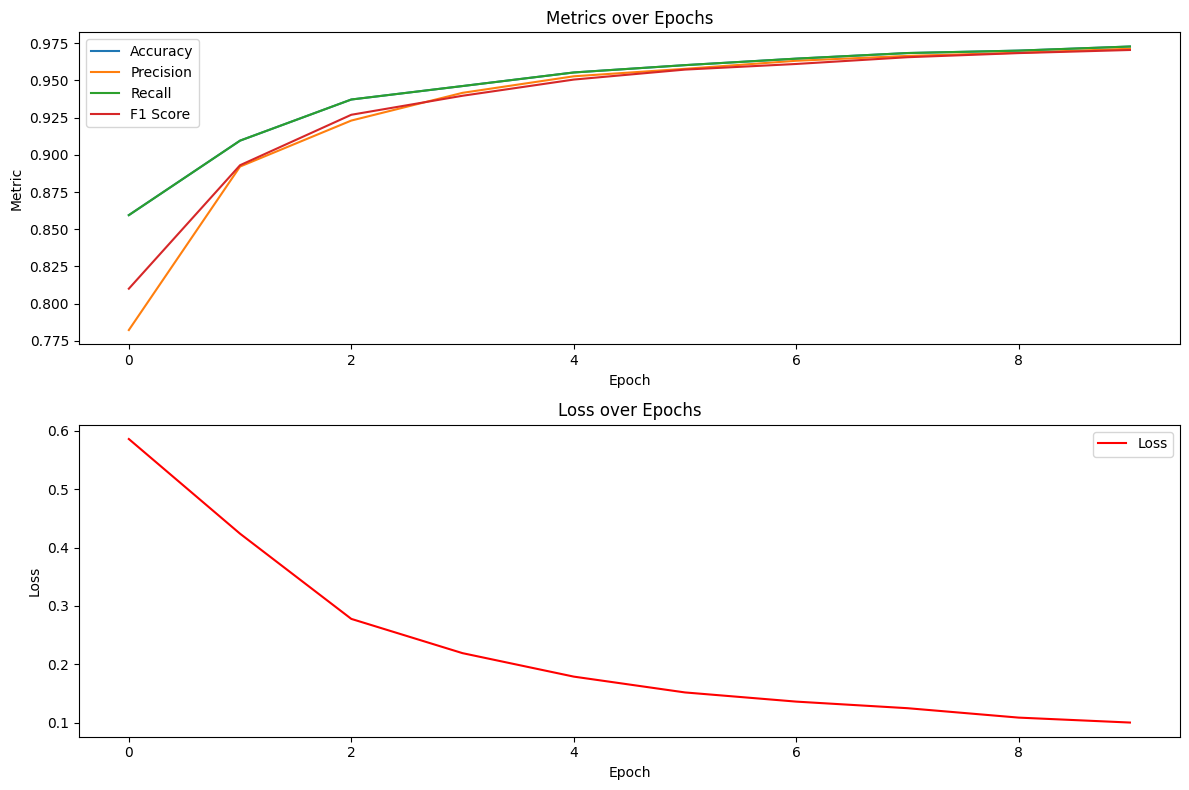

In [11]:
plot_metrics(epoch_acc, epoch_prc, epoch_rec, epoch_f1, epoch_losses, "lstm_metrics")

# LSTM with Attention Experiment
### Description
Use the ECG dataset and stratified k-fold cross validation to train the LSTM+Attention model and evaluate its performance.

### Steps
1. set up the LSTM+Attention model
1. train the LSTM+Attention model
1. evaluate performance with accuracy, F1 score, precision, recall

In [12]:
epoch_acc, epoch_prc, epoch_rec, epoch_f1, epoch_losses = [], [], [], [], []

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset, dataset_y)):
    print(f"FOLD {fold}")
    print("--------------------------------")

    # store metrics of each fold
    accuracies, precisions, recalls, f1_scores, losses = [], [], [], [], []

    # split data
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # data loaders for training and testing data in this fold
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_subsampler)

    # set parameters
    input_dim = 1         # ECG data is univariate, so the input dimension is 1
    hidden_dim = 128
    num_layers = 2
    num_classes = 5

    # initialize model for this fold
    model = AttentionLSTM(input_dim, hidden_dim, num_layers, num_classes)
    model.to(device)
    print(model)

    # loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)


    # train
    for epoch in range(num_epochs):
        model.train()
        batch_losses = []

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

            if (i+1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        # store metrics
        accuracy, precision, recall, f1, _, _ = evaluate(model, test_loader)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        # Accumulate metrics for each epoch across folds
        if fold == 0:
            # Initialize lists in the first fold
            epoch_acc.append(accuracy)
            epoch_prc.append(precision)
            epoch_rec.append(recall)
            epoch_f1.append(f1)
            epoch_losses.append(batch_losses)
        else:
            # Add to existing totals for subsequent folds
            epoch_acc[epoch] += accuracy
            epoch_prc[epoch] += precision
            epoch_rec[epoch] += recall
            epoch_f1[epoch] += f1
            epoch_losses[epoch].extend(batch_losses)

# Average metrics across all folds for each epoch
epoch_acc = [x / k_folds for x in epoch_acc]
epoch_prc = [x / k_folds for x in epoch_prc]
epoch_rec = [x / k_folds for x in epoch_rec]
epoch_f1 = [x / k_folds for x in epoch_f1]
epoch_losses = [sum(x) / len(x) for x in epoch_losses]

# Print average metrics for each epoch
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} - Avg Accuracy: {epoch_acc[epoch]}, Avg Precision: {epoch_prc[epoch]}, Avg Recall: {epoch_rec[epoch]}, Avg F1 Score: {epoch_f1[epoch]}, Avg Loss: {epoch_losses[epoch]}")

FOLD 0
--------------------------------
AttentionLSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (attention): SelfAttention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.5263
Epoch [1/10], Step [200/3079], Loss: 0.7729
Epoch [1/10], Step [300/3079], Loss: 0.7220
Epoch [1/10], Step [400/3079], Loss: 0.7636
Epoch [1/10], Step [500/3079], Loss: 0.3893
Epoch [1/10], Step [600/3079], Loss: 0.6928
Epoch [1/10], Step [700/3079], Loss: 0.3682
Epoch [1/10], Step [800/3079], Loss: 0.1864
Epoch [1/10], Step [900/3079], Loss: 0.5627
Epoch [1/10], Step [1000/3079], Loss: 0.2310
Epoch [1/10], Step [1100/3079], Loss: 0.3327
Epoch [1/10], Step [1200/3079], Loss: 0.4685
Epoch [1/10], Step [1300/3079], Loss: 0.4952
Epoch [1/10], Step [140

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:04:54,019 - root - INFO - Accuracy: 92.77%
2023-12-09 00:04:54,020 - root - INFO - Precision: 0.9142
2023-12-09 00:04:54,021 - root - INFO - Recall: 0.9277
2023-12-09 00:04:54,021 - root - INFO - F1 Score: 0.9107


Epoch [2/10], Step [100/3079], Loss: 0.3746
Epoch [2/10], Step [200/3079], Loss: 0.4507
Epoch [2/10], Step [300/3079], Loss: 0.2913
Epoch [2/10], Step [400/3079], Loss: 0.4420
Epoch [2/10], Step [500/3079], Loss: 0.2992
Epoch [2/10], Step [600/3079], Loss: 0.2682
Epoch [2/10], Step [700/3079], Loss: 0.0577
Epoch [2/10], Step [800/3079], Loss: 0.2171
Epoch [2/10], Step [900/3079], Loss: 0.5250
Epoch [2/10], Step [1000/3079], Loss: 0.4448
Epoch [2/10], Step [1100/3079], Loss: 0.2304
Epoch [2/10], Step [1200/3079], Loss: 0.2948
Epoch [2/10], Step [1300/3079], Loss: 0.2963
Epoch [2/10], Step [1400/3079], Loss: 0.2578
Epoch [2/10], Step [1500/3079], Loss: 0.2142
Epoch [2/10], Step [1600/3079], Loss: 0.2146
Epoch [2/10], Step [1700/3079], Loss: 0.0905
Epoch [2/10], Step [1800/3079], Loss: 0.1752
Epoch [2/10], Step [1900/3079], Loss: 0.4979
Epoch [2/10], Step [2000/3079], Loss: 0.0632
Epoch [2/10], Step [2100/3079], Loss: 0.3912
Epoch [2/10], Step [2200/3079], Loss: 0.2600
Epoch [2/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:05:10,729 - root - INFO - Accuracy: 94.93%
2023-12-09 00:05:10,730 - root - INFO - Precision: 0.9410
2023-12-09 00:05:10,731 - root - INFO - Recall: 0.9493
2023-12-09 00:05:10,732 - root - INFO - F1 Score: 0.9439


Epoch [3/10], Step [100/3079], Loss: 0.0603
Epoch [3/10], Step [200/3079], Loss: 0.1139
Epoch [3/10], Step [300/3079], Loss: 0.1095
Epoch [3/10], Step [400/3079], Loss: 0.0905
Epoch [3/10], Step [500/3079], Loss: 0.4485
Epoch [3/10], Step [600/3079], Loss: 0.0865
Epoch [3/10], Step [700/3079], Loss: 0.1017
Epoch [3/10], Step [800/3079], Loss: 0.2802
Epoch [3/10], Step [900/3079], Loss: 0.0430
Epoch [3/10], Step [1000/3079], Loss: 0.2619
Epoch [3/10], Step [1100/3079], Loss: 0.0865
Epoch [3/10], Step [1200/3079], Loss: 0.1087
Epoch [3/10], Step [1300/3079], Loss: 0.2105
Epoch [3/10], Step [1400/3079], Loss: 0.1475
Epoch [3/10], Step [1500/3079], Loss: 0.0280
Epoch [3/10], Step [1600/3079], Loss: 0.0758
Epoch [3/10], Step [1700/3079], Loss: 0.0473
Epoch [3/10], Step [1800/3079], Loss: 0.1673
Epoch [3/10], Step [1900/3079], Loss: 0.2153
Epoch [3/10], Step [2000/3079], Loss: 0.0264
Epoch [3/10], Step [2100/3079], Loss: 0.3533
Epoch [3/10], Step [2200/3079], Loss: 0.1155
Epoch [3/10], Step 

2023-12-09 00:05:27,444 - root - INFO - Accuracy: 96.02%
2023-12-09 00:05:27,445 - root - INFO - Precision: 0.9591
2023-12-09 00:05:27,446 - root - INFO - Recall: 0.9602
2023-12-09 00:05:27,447 - root - INFO - F1 Score: 0.9554


Epoch [4/10], Step [100/3079], Loss: 0.0928
Epoch [4/10], Step [200/3079], Loss: 0.3080
Epoch [4/10], Step [300/3079], Loss: 0.1800
Epoch [4/10], Step [400/3079], Loss: 0.4368
Epoch [4/10], Step [500/3079], Loss: 0.0643
Epoch [4/10], Step [600/3079], Loss: 0.0353
Epoch [4/10], Step [700/3079], Loss: 0.0272
Epoch [4/10], Step [800/3079], Loss: 0.1582
Epoch [4/10], Step [900/3079], Loss: 0.2657
Epoch [4/10], Step [1000/3079], Loss: 0.4838
Epoch [4/10], Step [1100/3079], Loss: 0.1670
Epoch [4/10], Step [1200/3079], Loss: 0.1961
Epoch [4/10], Step [1300/3079], Loss: 0.3513
Epoch [4/10], Step [1400/3079], Loss: 0.0944
Epoch [4/10], Step [1500/3079], Loss: 0.1715
Epoch [4/10], Step [1600/3079], Loss: 0.0861
Epoch [4/10], Step [1700/3079], Loss: 0.0922
Epoch [4/10], Step [1800/3079], Loss: 0.1928
Epoch [4/10], Step [1900/3079], Loss: 0.0981
Epoch [4/10], Step [2000/3079], Loss: 0.1426
Epoch [4/10], Step [2100/3079], Loss: 0.0193
Epoch [4/10], Step [2200/3079], Loss: 0.0594
Epoch [4/10], Step 

2023-12-09 00:05:44,149 - root - INFO - Accuracy: 96.90%
2023-12-09 00:05:44,150 - root - INFO - Precision: 0.9682
2023-12-09 00:05:44,151 - root - INFO - Recall: 0.9690
2023-12-09 00:05:44,153 - root - INFO - F1 Score: 0.9676


Epoch [5/10], Step [100/3079], Loss: 0.2096
Epoch [5/10], Step [200/3079], Loss: 0.0347
Epoch [5/10], Step [300/3079], Loss: 0.1059
Epoch [5/10], Step [400/3079], Loss: 0.0869
Epoch [5/10], Step [500/3079], Loss: 0.1710
Epoch [5/10], Step [600/3079], Loss: 0.1394
Epoch [5/10], Step [700/3079], Loss: 0.0676
Epoch [5/10], Step [800/3079], Loss: 0.1262
Epoch [5/10], Step [900/3079], Loss: 0.0952
Epoch [5/10], Step [1000/3079], Loss: 0.0288
Epoch [5/10], Step [1100/3079], Loss: 0.1078
Epoch [5/10], Step [1200/3079], Loss: 0.0454
Epoch [5/10], Step [1300/3079], Loss: 0.0880
Epoch [5/10], Step [1400/3079], Loss: 0.0046
Epoch [5/10], Step [1500/3079], Loss: 0.1196
Epoch [5/10], Step [1600/3079], Loss: 0.2611
Epoch [5/10], Step [1700/3079], Loss: 0.0785
Epoch [5/10], Step [1800/3079], Loss: 0.1303
Epoch [5/10], Step [1900/3079], Loss: 0.2872
Epoch [5/10], Step [2000/3079], Loss: 0.0537
Epoch [5/10], Step [2100/3079], Loss: 0.1219
Epoch [5/10], Step [2200/3079], Loss: 0.0065
Epoch [5/10], Step 

2023-12-09 00:06:00,830 - root - INFO - Accuracy: 97.17%
2023-12-09 00:06:00,831 - root - INFO - Precision: 0.9702
2023-12-09 00:06:00,832 - root - INFO - Recall: 0.9717
2023-12-09 00:06:00,833 - root - INFO - F1 Score: 0.9700


Epoch [6/10], Step [100/3079], Loss: 0.0261
Epoch [6/10], Step [200/3079], Loss: 0.0648
Epoch [6/10], Step [300/3079], Loss: 0.1215
Epoch [6/10], Step [400/3079], Loss: 0.1798
Epoch [6/10], Step [500/3079], Loss: 0.0431
Epoch [6/10], Step [600/3079], Loss: 0.0871
Epoch [6/10], Step [700/3079], Loss: 0.0503
Epoch [6/10], Step [800/3079], Loss: 0.1272
Epoch [6/10], Step [900/3079], Loss: 0.0404
Epoch [6/10], Step [1000/3079], Loss: 0.0492
Epoch [6/10], Step [1100/3079], Loss: 0.0943
Epoch [6/10], Step [1200/3079], Loss: 0.1548
Epoch [6/10], Step [1300/3079], Loss: 0.1996
Epoch [6/10], Step [1400/3079], Loss: 0.0795
Epoch [6/10], Step [1500/3079], Loss: 0.0399
Epoch [6/10], Step [1600/3079], Loss: 0.0303
Epoch [6/10], Step [1700/3079], Loss: 0.0246
Epoch [6/10], Step [1800/3079], Loss: 0.0204
Epoch [6/10], Step [1900/3079], Loss: 0.1649
Epoch [6/10], Step [2000/3079], Loss: 0.0412
Epoch [6/10], Step [2100/3079], Loss: 0.1984
Epoch [6/10], Step [2200/3079], Loss: 0.2954
Epoch [6/10], Step 

2023-12-09 00:06:17,572 - root - INFO - Accuracy: 97.37%
2023-12-09 00:06:17,574 - root - INFO - Precision: 0.9732
2023-12-09 00:06:17,574 - root - INFO - Recall: 0.9737
2023-12-09 00:06:17,575 - root - INFO - F1 Score: 0.9729


Epoch [7/10], Step [100/3079], Loss: 0.1731
Epoch [7/10], Step [200/3079], Loss: 0.0049
Epoch [7/10], Step [300/3079], Loss: 0.0425
Epoch [7/10], Step [400/3079], Loss: 0.0356
Epoch [7/10], Step [500/3079], Loss: 0.0913
Epoch [7/10], Step [600/3079], Loss: 0.2390
Epoch [7/10], Step [700/3079], Loss: 0.0088
Epoch [7/10], Step [800/3079], Loss: 0.2231
Epoch [7/10], Step [900/3079], Loss: 0.1576
Epoch [7/10], Step [1000/3079], Loss: 0.0315
Epoch [7/10], Step [1100/3079], Loss: 0.0356
Epoch [7/10], Step [1200/3079], Loss: 0.0317
Epoch [7/10], Step [1300/3079], Loss: 0.0873
Epoch [7/10], Step [1400/3079], Loss: 0.0926
Epoch [7/10], Step [1500/3079], Loss: 0.0164
Epoch [7/10], Step [1600/3079], Loss: 0.0094
Epoch [7/10], Step [1700/3079], Loss: 0.0853
Epoch [7/10], Step [1800/3079], Loss: 0.1870
Epoch [7/10], Step [1900/3079], Loss: 0.2432
Epoch [7/10], Step [2000/3079], Loss: 0.0101
Epoch [7/10], Step [2100/3079], Loss: 0.0096
Epoch [7/10], Step [2200/3079], Loss: 0.0988
Epoch [7/10], Step 

2023-12-09 00:06:34,324 - root - INFO - Accuracy: 97.99%
2023-12-09 00:06:34,325 - root - INFO - Precision: 0.9797
2023-12-09 00:06:34,326 - root - INFO - Recall: 0.9799
2023-12-09 00:06:34,327 - root - INFO - F1 Score: 0.9786


Epoch [8/10], Step [100/3079], Loss: 0.0323
Epoch [8/10], Step [200/3079], Loss: 0.1039
Epoch [8/10], Step [300/3079], Loss: 0.0197
Epoch [8/10], Step [400/3079], Loss: 0.0074
Epoch [8/10], Step [500/3079], Loss: 0.1447
Epoch [8/10], Step [600/3079], Loss: 0.0219
Epoch [8/10], Step [700/3079], Loss: 0.1926
Epoch [8/10], Step [800/3079], Loss: 0.0447
Epoch [8/10], Step [900/3079], Loss: 0.0025
Epoch [8/10], Step [1000/3079], Loss: 0.0035
Epoch [8/10], Step [1100/3079], Loss: 0.0118
Epoch [8/10], Step [1200/3079], Loss: 0.0617
Epoch [8/10], Step [1300/3079], Loss: 0.0764
Epoch [8/10], Step [1400/3079], Loss: 0.0080
Epoch [8/10], Step [1500/3079], Loss: 0.1524
Epoch [8/10], Step [1600/3079], Loss: 0.3235
Epoch [8/10], Step [1700/3079], Loss: 0.1144
Epoch [8/10], Step [1800/3079], Loss: 0.0138
Epoch [8/10], Step [1900/3079], Loss: 0.0328
Epoch [8/10], Step [2000/3079], Loss: 0.0313
Epoch [8/10], Step [2100/3079], Loss: 0.0386
Epoch [8/10], Step [2200/3079], Loss: 0.2672
Epoch [8/10], Step 

2023-12-09 00:06:50,860 - root - INFO - Accuracy: 97.57%
2023-12-09 00:06:50,861 - root - INFO - Precision: 0.9755
2023-12-09 00:06:50,862 - root - INFO - Recall: 0.9757
2023-12-09 00:06:50,863 - root - INFO - F1 Score: 0.9746


Epoch [9/10], Step [100/3079], Loss: 0.0383
Epoch [9/10], Step [200/3079], Loss: 0.0098
Epoch [9/10], Step [300/3079], Loss: 0.0092
Epoch [9/10], Step [400/3079], Loss: 0.0866
Epoch [9/10], Step [500/3079], Loss: 0.2812
Epoch [9/10], Step [600/3079], Loss: 0.3815
Epoch [9/10], Step [700/3079], Loss: 0.0533
Epoch [9/10], Step [800/3079], Loss: 0.0057
Epoch [9/10], Step [900/3079], Loss: 0.0210
Epoch [9/10], Step [1000/3079], Loss: 0.1161
Epoch [9/10], Step [1100/3079], Loss: 0.1855
Epoch [9/10], Step [1200/3079], Loss: 0.0028
Epoch [9/10], Step [1300/3079], Loss: 0.0483
Epoch [9/10], Step [1400/3079], Loss: 0.2202
Epoch [9/10], Step [1500/3079], Loss: 0.0128
Epoch [9/10], Step [1600/3079], Loss: 0.0620
Epoch [9/10], Step [1700/3079], Loss: 0.0455
Epoch [9/10], Step [1800/3079], Loss: 0.0192
Epoch [9/10], Step [1900/3079], Loss: 0.2994
Epoch [9/10], Step [2000/3079], Loss: 0.2219
Epoch [9/10], Step [2100/3079], Loss: 0.1676
Epoch [9/10], Step [2200/3079], Loss: 0.0410
Epoch [9/10], Step 

2023-12-09 00:07:07,493 - root - INFO - Accuracy: 97.42%
2023-12-09 00:07:07,494 - root - INFO - Precision: 0.9747
2023-12-09 00:07:07,495 - root - INFO - Recall: 0.9742
2023-12-09 00:07:07,496 - root - INFO - F1 Score: 0.9730


Epoch [10/10], Step [100/3079], Loss: 0.0964
Epoch [10/10], Step [200/3079], Loss: 0.0172
Epoch [10/10], Step [300/3079], Loss: 0.0859
Epoch [10/10], Step [400/3079], Loss: 0.0011
Epoch [10/10], Step [500/3079], Loss: 0.0127
Epoch [10/10], Step [600/3079], Loss: 0.1536
Epoch [10/10], Step [700/3079], Loss: 0.1415
Epoch [10/10], Step [800/3079], Loss: 0.0786
Epoch [10/10], Step [900/3079], Loss: 0.0221
Epoch [10/10], Step [1000/3079], Loss: 0.0133
Epoch [10/10], Step [1100/3079], Loss: 0.0396
Epoch [10/10], Step [1200/3079], Loss: 0.0952
Epoch [10/10], Step [1300/3079], Loss: 0.0136
Epoch [10/10], Step [1400/3079], Loss: 0.0162
Epoch [10/10], Step [1500/3079], Loss: 0.0288
Epoch [10/10], Step [1600/3079], Loss: 0.0312
Epoch [10/10], Step [1700/3079], Loss: 0.2160
Epoch [10/10], Step [1800/3079], Loss: 0.1937
Epoch [10/10], Step [1900/3079], Loss: 0.1088
Epoch [10/10], Step [2000/3079], Loss: 0.0065
Epoch [10/10], Step [2100/3079], Loss: 0.0142
Epoch [10/10], Step [2200/3079], Loss: 0.25

2023-12-09 00:07:24,114 - root - INFO - Accuracy: 97.63%
2023-12-09 00:07:24,116 - root - INFO - Precision: 0.9767
2023-12-09 00:07:24,116 - root - INFO - Recall: 0.9763
2023-12-09 00:07:24,117 - root - INFO - F1 Score: 0.9750


FOLD 1
--------------------------------
AttentionLSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (attention): SelfAttention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.8364
Epoch [1/10], Step [200/3079], Loss: 0.7051
Epoch [1/10], Step [300/3079], Loss: 0.5107
Epoch [1/10], Step [400/3079], Loss: 0.7949
Epoch [1/10], Step [500/3079], Loss: 0.4158
Epoch [1/10], Step [600/3079], Loss: 0.4679
Epoch [1/10], Step [700/3079], Loss: 0.4089
Epoch [1/10], Step [800/3079], Loss: 0.8244
Epoch [1/10], Step [900/3079], Loss: 0.6881
Epoch [1/10], Step [1000/3079], Loss: 0.4716
Epoch [1/10], Step [1100/3079], Loss: 0.6479
Epoch [1/10], Step [1200/3079], Loss: 0.7135
Epoch [1/10], Step [1300/3079], Loss: 0.4637
Epoch [1/10], Step [140

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:07:40,593 - root - INFO - Accuracy: 91.27%
2023-12-09 00:07:40,594 - root - INFO - Precision: 0.9022
2023-12-09 00:07:40,595 - root - INFO - Recall: 0.9127
2023-12-09 00:07:40,596 - root - INFO - F1 Score: 0.8964


Epoch [2/10], Step [100/3079], Loss: 0.3256
Epoch [2/10], Step [200/3079], Loss: 0.3813
Epoch [2/10], Step [300/3079], Loss: 0.2962
Epoch [2/10], Step [400/3079], Loss: 0.1232
Epoch [2/10], Step [500/3079], Loss: 0.2212
Epoch [2/10], Step [600/3079], Loss: 0.6080
Epoch [2/10], Step [700/3079], Loss: 0.3893
Epoch [2/10], Step [800/3079], Loss: 0.2271
Epoch [2/10], Step [900/3079], Loss: 0.2009
Epoch [2/10], Step [1000/3079], Loss: 0.3585
Epoch [2/10], Step [1100/3079], Loss: 0.3424
Epoch [2/10], Step [1200/3079], Loss: 0.1266
Epoch [2/10], Step [1300/3079], Loss: 0.1183
Epoch [2/10], Step [1400/3079], Loss: 0.0682
Epoch [2/10], Step [1500/3079], Loss: 0.2665
Epoch [2/10], Step [1600/3079], Loss: 0.0345
Epoch [2/10], Step [1700/3079], Loss: 0.2373
Epoch [2/10], Step [1800/3079], Loss: 0.1029
Epoch [2/10], Step [1900/3079], Loss: 0.0681
Epoch [2/10], Step [2000/3079], Loss: 0.0268
Epoch [2/10], Step [2100/3079], Loss: 0.1393
Epoch [2/10], Step [2200/3079], Loss: 0.4025
Epoch [2/10], Step 

2023-12-09 00:07:57,123 - root - INFO - Accuracy: 93.61%
2023-12-09 00:07:57,124 - root - INFO - Precision: 0.9342
2023-12-09 00:07:57,125 - root - INFO - Recall: 0.9361
2023-12-09 00:07:57,126 - root - INFO - F1 Score: 0.9239


Epoch [3/10], Step [100/3079], Loss: 0.5035
Epoch [3/10], Step [200/3079], Loss: 0.2231
Epoch [3/10], Step [300/3079], Loss: 0.2705
Epoch [3/10], Step [400/3079], Loss: 0.0439
Epoch [3/10], Step [500/3079], Loss: 0.2821
Epoch [3/10], Step [600/3079], Loss: 0.0383
Epoch [3/10], Step [700/3079], Loss: 0.1671
Epoch [3/10], Step [800/3079], Loss: 0.3237
Epoch [3/10], Step [900/3079], Loss: 0.3221
Epoch [3/10], Step [1000/3079], Loss: 0.0638
Epoch [3/10], Step [1100/3079], Loss: 0.1653
Epoch [3/10], Step [1200/3079], Loss: 0.0607
Epoch [3/10], Step [1300/3079], Loss: 0.0710
Epoch [3/10], Step [1400/3079], Loss: 0.1827
Epoch [3/10], Step [1500/3079], Loss: 0.0237
Epoch [3/10], Step [1600/3079], Loss: 0.3266
Epoch [3/10], Step [1700/3079], Loss: 0.1178
Epoch [3/10], Step [1800/3079], Loss: 0.2838
Epoch [3/10], Step [1900/3079], Loss: 0.3038
Epoch [3/10], Step [2000/3079], Loss: 0.0641
Epoch [3/10], Step [2100/3079], Loss: 0.0504
Epoch [3/10], Step [2200/3079], Loss: 0.5502
Epoch [3/10], Step 

2023-12-09 00:08:13,710 - root - INFO - Accuracy: 96.05%
2023-12-09 00:08:13,711 - root - INFO - Precision: 0.9592
2023-12-09 00:08:13,713 - root - INFO - Recall: 0.9605
2023-12-09 00:08:13,714 - root - INFO - F1 Score: 0.9594


Epoch [4/10], Step [100/3079], Loss: 0.1270
Epoch [4/10], Step [200/3079], Loss: 0.0808
Epoch [4/10], Step [300/3079], Loss: 0.0389
Epoch [4/10], Step [400/3079], Loss: 0.0638
Epoch [4/10], Step [500/3079], Loss: 0.1859
Epoch [4/10], Step [600/3079], Loss: 0.2407
Epoch [4/10], Step [700/3079], Loss: 0.1867
Epoch [4/10], Step [800/3079], Loss: 0.0140
Epoch [4/10], Step [900/3079], Loss: 0.2669
Epoch [4/10], Step [1000/3079], Loss: 0.1040
Epoch [4/10], Step [1100/3079], Loss: 0.1541
Epoch [4/10], Step [1200/3079], Loss: 0.1908
Epoch [4/10], Step [1300/3079], Loss: 0.1398
Epoch [4/10], Step [1400/3079], Loss: 0.0391
Epoch [4/10], Step [1500/3079], Loss: 0.0196
Epoch [4/10], Step [1600/3079], Loss: 0.1228
Epoch [4/10], Step [1700/3079], Loss: 0.0856
Epoch [4/10], Step [1800/3079], Loss: 0.0701
Epoch [4/10], Step [1900/3079], Loss: 0.1222
Epoch [4/10], Step [2000/3079], Loss: 0.0822
Epoch [4/10], Step [2100/3079], Loss: 0.0302
Epoch [4/10], Step [2200/3079], Loss: 0.1305
Epoch [4/10], Step 

2023-12-09 00:08:30,294 - root - INFO - Accuracy: 96.45%
2023-12-09 00:08:30,296 - root - INFO - Precision: 0.9640
2023-12-09 00:08:30,297 - root - INFO - Recall: 0.9645
2023-12-09 00:08:30,298 - root - INFO - F1 Score: 0.9600


Epoch [5/10], Step [100/3079], Loss: 0.0331
Epoch [5/10], Step [200/3079], Loss: 0.1332
Epoch [5/10], Step [300/3079], Loss: 0.2526
Epoch [5/10], Step [400/3079], Loss: 0.1323
Epoch [5/10], Step [500/3079], Loss: 0.0163
Epoch [5/10], Step [600/3079], Loss: 0.2575
Epoch [5/10], Step [700/3079], Loss: 0.1226
Epoch [5/10], Step [800/3079], Loss: 0.1183
Epoch [5/10], Step [900/3079], Loss: 0.2718
Epoch [5/10], Step [1000/3079], Loss: 0.1681
Epoch [5/10], Step [1100/3079], Loss: 0.1730
Epoch [5/10], Step [1200/3079], Loss: 0.2645
Epoch [5/10], Step [1300/3079], Loss: 0.0939
Epoch [5/10], Step [1400/3079], Loss: 0.0308
Epoch [5/10], Step [1500/3079], Loss: 0.0414
Epoch [5/10], Step [1600/3079], Loss: 0.0649
Epoch [5/10], Step [1700/3079], Loss: 0.0542
Epoch [5/10], Step [1800/3079], Loss: 0.0113
Epoch [5/10], Step [1900/3079], Loss: 0.1758
Epoch [5/10], Step [2000/3079], Loss: 0.1199
Epoch [5/10], Step [2100/3079], Loss: 0.2451
Epoch [5/10], Step [2200/3079], Loss: 0.1804
Epoch [5/10], Step 

2023-12-09 00:08:46,888 - root - INFO - Accuracy: 96.79%
2023-12-09 00:08:46,889 - root - INFO - Precision: 0.9672
2023-12-09 00:08:46,890 - root - INFO - Recall: 0.9679
2023-12-09 00:08:46,891 - root - INFO - F1 Score: 0.9650


Epoch [6/10], Step [100/3079], Loss: 0.1144
Epoch [6/10], Step [200/3079], Loss: 0.1209
Epoch [6/10], Step [300/3079], Loss: 0.0570
Epoch [6/10], Step [400/3079], Loss: 0.0276
Epoch [6/10], Step [500/3079], Loss: 0.0027
Epoch [6/10], Step [600/3079], Loss: 0.3225
Epoch [6/10], Step [700/3079], Loss: 0.0524
Epoch [6/10], Step [800/3079], Loss: 0.0971
Epoch [6/10], Step [900/3079], Loss: 0.0220
Epoch [6/10], Step [1000/3079], Loss: 0.1749
Epoch [6/10], Step [1100/3079], Loss: 0.0079
Epoch [6/10], Step [1200/3079], Loss: 0.0506
Epoch [6/10], Step [1300/3079], Loss: 0.0226
Epoch [6/10], Step [1400/3079], Loss: 0.2133
Epoch [6/10], Step [1500/3079], Loss: 0.1413
Epoch [6/10], Step [1600/3079], Loss: 0.2427
Epoch [6/10], Step [1700/3079], Loss: 0.0349
Epoch [6/10], Step [1800/3079], Loss: 0.0689
Epoch [6/10], Step [1900/3079], Loss: 0.0557
Epoch [6/10], Step [2000/3079], Loss: 0.0090
Epoch [6/10], Step [2100/3079], Loss: 0.0778
Epoch [6/10], Step [2200/3079], Loss: 0.3368
Epoch [6/10], Step 

2023-12-09 00:09:03,488 - root - INFO - Accuracy: 97.86%
2023-12-09 00:09:03,489 - root - INFO - Precision: 0.9783
2023-12-09 00:09:03,490 - root - INFO - Recall: 0.9786
2023-12-09 00:09:03,491 - root - INFO - F1 Score: 0.9773


Epoch [7/10], Step [100/3079], Loss: 0.0037
Epoch [7/10], Step [200/3079], Loss: 0.0094
Epoch [7/10], Step [300/3079], Loss: 0.0236
Epoch [7/10], Step [400/3079], Loss: 0.0271
Epoch [7/10], Step [500/3079], Loss: 0.1155
Epoch [7/10], Step [600/3079], Loss: 0.1332
Epoch [7/10], Step [700/3079], Loss: 0.0196
Epoch [7/10], Step [800/3079], Loss: 0.0138
Epoch [7/10], Step [900/3079], Loss: 0.0645
Epoch [7/10], Step [1000/3079], Loss: 0.0951
Epoch [7/10], Step [1100/3079], Loss: 0.0166
Epoch [7/10], Step [1200/3079], Loss: 0.0099
Epoch [7/10], Step [1300/3079], Loss: 0.1161
Epoch [7/10], Step [1400/3079], Loss: 0.2766
Epoch [7/10], Step [1500/3079], Loss: 0.0062
Epoch [7/10], Step [1600/3079], Loss: 0.1375
Epoch [7/10], Step [1700/3079], Loss: 0.0080
Epoch [7/10], Step [1800/3079], Loss: 0.0652
Epoch [7/10], Step [1900/3079], Loss: 0.0047
Epoch [7/10], Step [2000/3079], Loss: 0.0279
Epoch [7/10], Step [2100/3079], Loss: 0.0239
Epoch [7/10], Step [2200/3079], Loss: 0.0636
Epoch [7/10], Step 

2023-12-09 00:09:20,115 - root - INFO - Accuracy: 97.22%
2023-12-09 00:09:20,117 - root - INFO - Precision: 0.9719
2023-12-09 00:09:20,117 - root - INFO - Recall: 0.9722
2023-12-09 00:09:20,118 - root - INFO - F1 Score: 0.9719


Epoch [8/10], Step [100/3079], Loss: 0.1640
Epoch [8/10], Step [200/3079], Loss: 0.0110
Epoch [8/10], Step [300/3079], Loss: 0.0058
Epoch [8/10], Step [400/3079], Loss: 0.0176
Epoch [8/10], Step [500/3079], Loss: 0.3754
Epoch [8/10], Step [600/3079], Loss: 0.0110
Epoch [8/10], Step [700/3079], Loss: 0.0695
Epoch [8/10], Step [800/3079], Loss: 0.0259
Epoch [8/10], Step [900/3079], Loss: 0.0332
Epoch [8/10], Step [1000/3079], Loss: 0.1252
Epoch [8/10], Step [1100/3079], Loss: 0.0170
Epoch [8/10], Step [1200/3079], Loss: 0.2433
Epoch [8/10], Step [1300/3079], Loss: 0.1702
Epoch [8/10], Step [1400/3079], Loss: 0.0052
Epoch [8/10], Step [1500/3079], Loss: 0.0885
Epoch [8/10], Step [1600/3079], Loss: 0.0370
Epoch [8/10], Step [1700/3079], Loss: 0.0288
Epoch [8/10], Step [1800/3079], Loss: 0.0266
Epoch [8/10], Step [1900/3079], Loss: 0.0109
Epoch [8/10], Step [2000/3079], Loss: 0.0725
Epoch [8/10], Step [2100/3079], Loss: 0.0224
Epoch [8/10], Step [2200/3079], Loss: 0.0038
Epoch [8/10], Step 

2023-12-09 00:09:36,561 - root - INFO - Accuracy: 97.73%
2023-12-09 00:09:36,562 - root - INFO - Precision: 0.9774
2023-12-09 00:09:36,563 - root - INFO - Recall: 0.9773
2023-12-09 00:09:36,564 - root - INFO - F1 Score: 0.9769


Epoch [9/10], Step [100/3079], Loss: 0.2524
Epoch [9/10], Step [200/3079], Loss: 0.0275
Epoch [9/10], Step [300/3079], Loss: 0.1205
Epoch [9/10], Step [400/3079], Loss: 0.0095
Epoch [9/10], Step [500/3079], Loss: 0.0159
Epoch [9/10], Step [600/3079], Loss: 0.0099
Epoch [9/10], Step [700/3079], Loss: 0.0891
Epoch [9/10], Step [800/3079], Loss: 0.0099
Epoch [9/10], Step [900/3079], Loss: 0.0243
Epoch [9/10], Step [1000/3079], Loss: 0.0679
Epoch [9/10], Step [1100/3079], Loss: 0.1057
Epoch [9/10], Step [1200/3079], Loss: 0.0655
Epoch [9/10], Step [1300/3079], Loss: 0.1283
Epoch [9/10], Step [1400/3079], Loss: 0.0210
Epoch [9/10], Step [1500/3079], Loss: 0.1322
Epoch [9/10], Step [1600/3079], Loss: 0.0312
Epoch [9/10], Step [1700/3079], Loss: 0.1102
Epoch [9/10], Step [1800/3079], Loss: 0.0148
Epoch [9/10], Step [1900/3079], Loss: 0.0115
Epoch [9/10], Step [2000/3079], Loss: 0.0017
Epoch [9/10], Step [2100/3079], Loss: 0.0963
Epoch [9/10], Step [2200/3079], Loss: 0.2084
Epoch [9/10], Step 

2023-12-09 00:09:53,146 - root - INFO - Accuracy: 97.82%
2023-12-09 00:09:53,147 - root - INFO - Precision: 0.9778
2023-12-09 00:09:53,148 - root - INFO - Recall: 0.9782
2023-12-09 00:09:53,151 - root - INFO - F1 Score: 0.9776


Epoch [10/10], Step [100/3079], Loss: 0.1866
Epoch [10/10], Step [200/3079], Loss: 0.0072
Epoch [10/10], Step [300/3079], Loss: 0.0091
Epoch [10/10], Step [400/3079], Loss: 0.0737
Epoch [10/10], Step [500/3079], Loss: 0.0414
Epoch [10/10], Step [600/3079], Loss: 0.0552
Epoch [10/10], Step [700/3079], Loss: 0.1432
Epoch [10/10], Step [800/3079], Loss: 0.0189
Epoch [10/10], Step [900/3079], Loss: 0.1092
Epoch [10/10], Step [1000/3079], Loss: 0.0761
Epoch [10/10], Step [1100/3079], Loss: 0.1452
Epoch [10/10], Step [1200/3079], Loss: 0.0293
Epoch [10/10], Step [1300/3079], Loss: 0.1324
Epoch [10/10], Step [1400/3079], Loss: 0.0363
Epoch [10/10], Step [1500/3079], Loss: 0.2066
Epoch [10/10], Step [1600/3079], Loss: 0.2899
Epoch [10/10], Step [1700/3079], Loss: 0.0486
Epoch [10/10], Step [1800/3079], Loss: 0.0663
Epoch [10/10], Step [1900/3079], Loss: 0.1948
Epoch [10/10], Step [2000/3079], Loss: 0.0029
Epoch [10/10], Step [2100/3079], Loss: 0.0394
Epoch [10/10], Step [2200/3079], Loss: 0.00

2023-12-09 00:10:09,792 - root - INFO - Accuracy: 97.75%
2023-12-09 00:10:09,793 - root - INFO - Precision: 0.9775
2023-12-09 00:10:09,794 - root - INFO - Recall: 0.9775
2023-12-09 00:10:09,794 - root - INFO - F1 Score: 0.9769


FOLD 2
--------------------------------
AttentionLSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (attention): SelfAttention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.7178
Epoch [1/10], Step [200/3079], Loss: 0.5819
Epoch [1/10], Step [300/3079], Loss: 0.5072
Epoch [1/10], Step [400/3079], Loss: 0.6595
Epoch [1/10], Step [500/3079], Loss: 0.5950
Epoch [1/10], Step [600/3079], Loss: 0.4879
Epoch [1/10], Step [700/3079], Loss: 0.4085
Epoch [1/10], Step [800/3079], Loss: 0.5711
Epoch [1/10], Step [900/3079], Loss: 0.3968
Epoch [1/10], Step [1000/3079], Loss: 0.3723
Epoch [1/10], Step [1100/3079], Loss: 0.4287
Epoch [1/10], Step [1200/3079], Loss: 0.2328
Epoch [1/10], Step [1300/3079], Loss: 0.3846
Epoch [1/10], Step [140

2023-12-09 00:10:26,298 - root - INFO - Accuracy: 93.69%
2023-12-09 00:10:26,299 - root - INFO - Precision: 0.9307
2023-12-09 00:10:26,300 - root - INFO - Recall: 0.9369
2023-12-09 00:10:26,301 - root - INFO - F1 Score: 0.9282


Epoch [2/10], Step [100/3079], Loss: 0.5665
Epoch [2/10], Step [200/3079], Loss: 0.1729
Epoch [2/10], Step [300/3079], Loss: 0.0294
Epoch [2/10], Step [400/3079], Loss: 0.1240
Epoch [2/10], Step [500/3079], Loss: 0.0565
Epoch [2/10], Step [600/3079], Loss: 0.1302
Epoch [2/10], Step [700/3079], Loss: 0.1428
Epoch [2/10], Step [800/3079], Loss: 0.2831
Epoch [2/10], Step [900/3079], Loss: 0.1354
Epoch [2/10], Step [1000/3079], Loss: 0.4648
Epoch [2/10], Step [1100/3079], Loss: 0.2539
Epoch [2/10], Step [1200/3079], Loss: 0.3742
Epoch [2/10], Step [1300/3079], Loss: 0.1874
Epoch [2/10], Step [1400/3079], Loss: 0.3027
Epoch [2/10], Step [1500/3079], Loss: 0.1087
Epoch [2/10], Step [1600/3079], Loss: 0.3322
Epoch [2/10], Step [1700/3079], Loss: 0.2094
Epoch [2/10], Step [1800/3079], Loss: 0.1513
Epoch [2/10], Step [1900/3079], Loss: 0.1522
Epoch [2/10], Step [2000/3079], Loss: 0.0315
Epoch [2/10], Step [2100/3079], Loss: 0.0710
Epoch [2/10], Step [2200/3079], Loss: 0.0969
Epoch [2/10], Step 

2023-12-09 00:10:42,894 - root - INFO - Accuracy: 94.59%
2023-12-09 00:10:42,895 - root - INFO - Precision: 0.9440
2023-12-09 00:10:42,896 - root - INFO - Recall: 0.9459
2023-12-09 00:10:42,897 - root - INFO - F1 Score: 0.9370


Epoch [3/10], Step [100/3079], Loss: 0.0726
Epoch [3/10], Step [200/3079], Loss: 0.1938
Epoch [3/10], Step [300/3079], Loss: 0.0382
Epoch [3/10], Step [400/3079], Loss: 0.1298
Epoch [3/10], Step [500/3079], Loss: 0.1170
Epoch [3/10], Step [600/3079], Loss: 0.2589
Epoch [3/10], Step [700/3079], Loss: 0.1653
Epoch [3/10], Step [800/3079], Loss: 0.1618
Epoch [3/10], Step [900/3079], Loss: 0.0296
Epoch [3/10], Step [1000/3079], Loss: 0.1475
Epoch [3/10], Step [1100/3079], Loss: 0.2177
Epoch [3/10], Step [1200/3079], Loss: 0.1992
Epoch [3/10], Step [1300/3079], Loss: 0.4907
Epoch [3/10], Step [1400/3079], Loss: 0.0370
Epoch [3/10], Step [1500/3079], Loss: 0.0947
Epoch [3/10], Step [1600/3079], Loss: 0.0377
Epoch [3/10], Step [1700/3079], Loss: 0.0471
Epoch [3/10], Step [1800/3079], Loss: 0.0276
Epoch [3/10], Step [1900/3079], Loss: 0.2846
Epoch [3/10], Step [2000/3079], Loss: 0.1497
Epoch [3/10], Step [2100/3079], Loss: 0.3705
Epoch [3/10], Step [2200/3079], Loss: 0.1891
Epoch [3/10], Step 

2023-12-09 00:10:59,453 - root - INFO - Accuracy: 96.46%
2023-12-09 00:10:59,454 - root - INFO - Precision: 0.9630
2023-12-09 00:10:59,455 - root - INFO - Recall: 0.9646
2023-12-09 00:10:59,456 - root - INFO - F1 Score: 0.9620


Epoch [4/10], Step [100/3079], Loss: 0.4524
Epoch [4/10], Step [200/3079], Loss: 0.1568
Epoch [4/10], Step [300/3079], Loss: 0.0598
Epoch [4/10], Step [400/3079], Loss: 0.0851
Epoch [4/10], Step [500/3079], Loss: 0.2747
Epoch [4/10], Step [600/3079], Loss: 0.0357
Epoch [4/10], Step [700/3079], Loss: 0.0294
Epoch [4/10], Step [800/3079], Loss: 0.0423
Epoch [4/10], Step [900/3079], Loss: 0.0268
Epoch [4/10], Step [1000/3079], Loss: 0.0290
Epoch [4/10], Step [1100/3079], Loss: 0.0810
Epoch [4/10], Step [1200/3079], Loss: 0.0336
Epoch [4/10], Step [1300/3079], Loss: 0.1391
Epoch [4/10], Step [1400/3079], Loss: 0.1168
Epoch [4/10], Step [1500/3079], Loss: 0.0233
Epoch [4/10], Step [1600/3079], Loss: 0.0097
Epoch [4/10], Step [1700/3079], Loss: 0.0142
Epoch [4/10], Step [1800/3079], Loss: 0.0692
Epoch [4/10], Step [1900/3079], Loss: 0.0324
Epoch [4/10], Step [2000/3079], Loss: 0.0401
Epoch [4/10], Step [2100/3079], Loss: 0.1009
Epoch [4/10], Step [2200/3079], Loss: 0.1628
Epoch [4/10], Step 

2023-12-09 00:11:16,064 - root - INFO - Accuracy: 96.96%
2023-12-09 00:11:16,065 - root - INFO - Precision: 0.9684
2023-12-09 00:11:16,066 - root - INFO - Recall: 0.9696
2023-12-09 00:11:16,067 - root - INFO - F1 Score: 0.9676


Epoch [5/10], Step [100/3079], Loss: 0.1310
Epoch [5/10], Step [200/3079], Loss: 0.1454
Epoch [5/10], Step [300/3079], Loss: 0.0808
Epoch [5/10], Step [400/3079], Loss: 0.0102
Epoch [5/10], Step [500/3079], Loss: 0.0233
Epoch [5/10], Step [600/3079], Loss: 0.0970
Epoch [5/10], Step [700/3079], Loss: 0.0716
Epoch [5/10], Step [800/3079], Loss: 0.0133
Epoch [5/10], Step [900/3079], Loss: 0.1250
Epoch [5/10], Step [1000/3079], Loss: 0.0781
Epoch [5/10], Step [1100/3079], Loss: 0.0172
Epoch [5/10], Step [1200/3079], Loss: 0.0633
Epoch [5/10], Step [1300/3079], Loss: 0.0724
Epoch [5/10], Step [1400/3079], Loss: 0.3359
Epoch [5/10], Step [1500/3079], Loss: 0.0504
Epoch [5/10], Step [1600/3079], Loss: 0.0316
Epoch [5/10], Step [1700/3079], Loss: 0.0971
Epoch [5/10], Step [1800/3079], Loss: 0.0169
Epoch [5/10], Step [1900/3079], Loss: 0.0622
Epoch [5/10], Step [2000/3079], Loss: 0.0903
Epoch [5/10], Step [2100/3079], Loss: 0.0220
Epoch [5/10], Step [2200/3079], Loss: 0.1770
Epoch [5/10], Step 

2023-12-09 00:11:32,679 - root - INFO - Accuracy: 96.77%
2023-12-09 00:11:32,680 - root - INFO - Precision: 0.9681
2023-12-09 00:11:32,681 - root - INFO - Recall: 0.9677
2023-12-09 00:11:32,682 - root - INFO - F1 Score: 0.9663


Epoch [6/10], Step [100/3079], Loss: 0.0084
Epoch [6/10], Step [200/3079], Loss: 0.0248
Epoch [6/10], Step [300/3079], Loss: 0.2047
Epoch [6/10], Step [400/3079], Loss: 0.0217
Epoch [6/10], Step [500/3079], Loss: 0.0099
Epoch [6/10], Step [600/3079], Loss: 0.1938
Epoch [6/10], Step [700/3079], Loss: 0.1062
Epoch [6/10], Step [800/3079], Loss: 0.0310
Epoch [6/10], Step [900/3079], Loss: 0.1316
Epoch [6/10], Step [1000/3079], Loss: 0.0509
Epoch [6/10], Step [1100/3079], Loss: 0.1881
Epoch [6/10], Step [1200/3079], Loss: 0.3119
Epoch [6/10], Step [1300/3079], Loss: 0.1811
Epoch [6/10], Step [1400/3079], Loss: 0.0699
Epoch [6/10], Step [1500/3079], Loss: 0.0817
Epoch [6/10], Step [1600/3079], Loss: 0.0916
Epoch [6/10], Step [1700/3079], Loss: 0.0212
Epoch [6/10], Step [1800/3079], Loss: 0.0445
Epoch [6/10], Step [1900/3079], Loss: 0.0140
Epoch [6/10], Step [2000/3079], Loss: 0.0214
Epoch [6/10], Step [2100/3079], Loss: 0.1803
Epoch [6/10], Step [2200/3079], Loss: 0.0272
Epoch [6/10], Step 

2023-12-09 00:11:49,286 - root - INFO - Accuracy: 97.13%
2023-12-09 00:11:49,287 - root - INFO - Precision: 0.9706
2023-12-09 00:11:49,288 - root - INFO - Recall: 0.9713
2023-12-09 00:11:49,289 - root - INFO - F1 Score: 0.9691


Epoch [7/10], Step [100/3079], Loss: 0.1932
Epoch [7/10], Step [200/3079], Loss: 0.0660
Epoch [7/10], Step [300/3079], Loss: 0.1085
Epoch [7/10], Step [400/3079], Loss: 0.0953
Epoch [7/10], Step [500/3079], Loss: 0.0418
Epoch [7/10], Step [600/3079], Loss: 0.1355
Epoch [7/10], Step [700/3079], Loss: 0.1179
Epoch [7/10], Step [800/3079], Loss: 0.1330
Epoch [7/10], Step [900/3079], Loss: 0.0149
Epoch [7/10], Step [1000/3079], Loss: 0.1609
Epoch [7/10], Step [1100/3079], Loss: 0.2014
Epoch [7/10], Step [1200/3079], Loss: 0.0144
Epoch [7/10], Step [1300/3079], Loss: 0.2166
Epoch [7/10], Step [1400/3079], Loss: 0.1666
Epoch [7/10], Step [1500/3079], Loss: 0.0050
Epoch [7/10], Step [1600/3079], Loss: 0.0186
Epoch [7/10], Step [1700/3079], Loss: 0.0150
Epoch [7/10], Step [1800/3079], Loss: 0.0468
Epoch [7/10], Step [1900/3079], Loss: 0.0403
Epoch [7/10], Step [2000/3079], Loss: 0.0181
Epoch [7/10], Step [2100/3079], Loss: 0.0429
Epoch [7/10], Step [2200/3079], Loss: 0.1914
Epoch [7/10], Step 

2023-12-09 00:12:05,879 - root - INFO - Accuracy: 97.57%
2023-12-09 00:12:05,880 - root - INFO - Precision: 0.9748
2023-12-09 00:12:05,881 - root - INFO - Recall: 0.9757
2023-12-09 00:12:05,882 - root - INFO - F1 Score: 0.9748


Epoch [8/10], Step [100/3079], Loss: 0.3061
Epoch [8/10], Step [200/3079], Loss: 0.0243
Epoch [8/10], Step [300/3079], Loss: 0.0528
Epoch [8/10], Step [400/3079], Loss: 0.0497
Epoch [8/10], Step [500/3079], Loss: 0.1036
Epoch [8/10], Step [600/3079], Loss: 0.0700
Epoch [8/10], Step [700/3079], Loss: 0.0240
Epoch [8/10], Step [800/3079], Loss: 0.0069
Epoch [8/10], Step [900/3079], Loss: 0.0042
Epoch [8/10], Step [1000/3079], Loss: 0.0651
Epoch [8/10], Step [1100/3079], Loss: 0.0065
Epoch [8/10], Step [1200/3079], Loss: 0.0080
Epoch [8/10], Step [1300/3079], Loss: 0.0020
Epoch [8/10], Step [1400/3079], Loss: 0.0065
Epoch [8/10], Step [1500/3079], Loss: 0.1685
Epoch [8/10], Step [1600/3079], Loss: 0.0203
Epoch [8/10], Step [1700/3079], Loss: 0.0167
Epoch [8/10], Step [1800/3079], Loss: 0.0159
Epoch [8/10], Step [1900/3079], Loss: 0.0990
Epoch [8/10], Step [2000/3079], Loss: 0.1682
Epoch [8/10], Step [2100/3079], Loss: 0.0015
Epoch [8/10], Step [2200/3079], Loss: 0.0150
Epoch [8/10], Step 

2023-12-09 00:12:22,485 - root - INFO - Accuracy: 97.61%
2023-12-09 00:12:22,486 - root - INFO - Precision: 0.9755
2023-12-09 00:12:22,487 - root - INFO - Recall: 0.9761
2023-12-09 00:12:22,488 - root - INFO - F1 Score: 0.9751


Epoch [9/10], Step [100/3079], Loss: 0.1318
Epoch [9/10], Step [200/3079], Loss: 0.1754
Epoch [9/10], Step [300/3079], Loss: 0.0520
Epoch [9/10], Step [400/3079], Loss: 0.5330
Epoch [9/10], Step [500/3079], Loss: 0.1288
Epoch [9/10], Step [600/3079], Loss: 0.0114
Epoch [9/10], Step [700/3079], Loss: 0.0772
Epoch [9/10], Step [800/3079], Loss: 0.0034
Epoch [9/10], Step [900/3079], Loss: 0.0209
Epoch [9/10], Step [1000/3079], Loss: 0.0577
Epoch [9/10], Step [1100/3079], Loss: 0.0102
Epoch [9/10], Step [1200/3079], Loss: 0.0184
Epoch [9/10], Step [1300/3079], Loss: 0.3996
Epoch [9/10], Step [1400/3079], Loss: 0.0061
Epoch [9/10], Step [1500/3079], Loss: 0.0843
Epoch [9/10], Step [1600/3079], Loss: 0.0117
Epoch [9/10], Step [1700/3079], Loss: 0.0816
Epoch [9/10], Step [1800/3079], Loss: 0.1794
Epoch [9/10], Step [1900/3079], Loss: 0.0075
Epoch [9/10], Step [2000/3079], Loss: 0.0090
Epoch [9/10], Step [2100/3079], Loss: 0.0953
Epoch [9/10], Step [2200/3079], Loss: 0.0309
Epoch [9/10], Step 

2023-12-09 00:12:38,920 - root - INFO - Accuracy: 97.76%
2023-12-09 00:12:38,921 - root - INFO - Precision: 0.9773
2023-12-09 00:12:38,922 - root - INFO - Recall: 0.9776
2023-12-09 00:12:38,923 - root - INFO - F1 Score: 0.9763


Epoch [10/10], Step [100/3079], Loss: 0.0073
Epoch [10/10], Step [200/3079], Loss: 0.0575
Epoch [10/10], Step [300/3079], Loss: 0.0204
Epoch [10/10], Step [400/3079], Loss: 0.0171
Epoch [10/10], Step [500/3079], Loss: 0.1967
Epoch [10/10], Step [600/3079], Loss: 0.0065
Epoch [10/10], Step [700/3079], Loss: 0.0461
Epoch [10/10], Step [800/3079], Loss: 0.0019
Epoch [10/10], Step [900/3079], Loss: 0.1782
Epoch [10/10], Step [1000/3079], Loss: 0.0263
Epoch [10/10], Step [1100/3079], Loss: 0.0300
Epoch [10/10], Step [1200/3079], Loss: 0.0023
Epoch [10/10], Step [1300/3079], Loss: 0.0440
Epoch [10/10], Step [1400/3079], Loss: 0.2197
Epoch [10/10], Step [1500/3079], Loss: 0.0465
Epoch [10/10], Step [1600/3079], Loss: 0.0360
Epoch [10/10], Step [1700/3079], Loss: 0.0159
Epoch [10/10], Step [1800/3079], Loss: 0.0053
Epoch [10/10], Step [1900/3079], Loss: 0.0005
Epoch [10/10], Step [2000/3079], Loss: 0.0216
Epoch [10/10], Step [2100/3079], Loss: 0.0251
Epoch [10/10], Step [2200/3079], Loss: 0.11

2023-12-09 00:12:55,522 - root - INFO - Accuracy: 98.02%
2023-12-09 00:12:55,524 - root - INFO - Precision: 0.9796
2023-12-09 00:12:55,525 - root - INFO - Recall: 0.9802
2023-12-09 00:12:55,526 - root - INFO - F1 Score: 0.9790


FOLD 3
--------------------------------
AttentionLSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (attention): SelfAttention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.5091
Epoch [1/10], Step [200/3079], Loss: 0.6044
Epoch [1/10], Step [300/3079], Loss: 0.7571
Epoch [1/10], Step [400/3079], Loss: 0.3789
Epoch [1/10], Step [500/3079], Loss: 0.4761
Epoch [1/10], Step [600/3079], Loss: 0.6895
Epoch [1/10], Step [700/3079], Loss: 0.6764
Epoch [1/10], Step [800/3079], Loss: 0.5182
Epoch [1/10], Step [900/3079], Loss: 0.9034
Epoch [1/10], Step [1000/3079], Loss: 0.5991
Epoch [1/10], Step [1100/3079], Loss: 0.4544
Epoch [1/10], Step [1200/3079], Loss: 0.1927
Epoch [1/10], Step [1300/3079], Loss: 0.5031
Epoch [1/10], Step [140

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:13:11,988 - root - INFO - Accuracy: 91.06%
2023-12-09 00:13:11,989 - root - INFO - Precision: 0.9086
2023-12-09 00:13:11,990 - root - INFO - Recall: 0.9106
2023-12-09 00:13:11,991 - root - INFO - F1 Score: 0.8880


Epoch [2/10], Step [100/3079], Loss: 0.5429
Epoch [2/10], Step [200/3079], Loss: 0.2745
Epoch [2/10], Step [300/3079], Loss: 0.0492
Epoch [2/10], Step [400/3079], Loss: 0.3791
Epoch [2/10], Step [500/3079], Loss: 0.3302
Epoch [2/10], Step [600/3079], Loss: 0.6276
Epoch [2/10], Step [700/3079], Loss: 0.1377
Epoch [2/10], Step [800/3079], Loss: 0.2751
Epoch [2/10], Step [900/3079], Loss: 0.4388
Epoch [2/10], Step [1000/3079], Loss: 0.1817
Epoch [2/10], Step [1100/3079], Loss: 0.1485
Epoch [2/10], Step [1200/3079], Loss: 0.1493
Epoch [2/10], Step [1300/3079], Loss: 0.2276
Epoch [2/10], Step [1400/3079], Loss: 0.2282
Epoch [2/10], Step [1500/3079], Loss: 0.1008
Epoch [2/10], Step [1600/3079], Loss: 0.0862
Epoch [2/10], Step [1700/3079], Loss: 0.1721
Epoch [2/10], Step [1800/3079], Loss: 0.2072
Epoch [2/10], Step [1900/3079], Loss: 0.2635
Epoch [2/10], Step [2000/3079], Loss: 0.3859
Epoch [2/10], Step [2100/3079], Loss: 0.2991
Epoch [2/10], Step [2200/3079], Loss: 0.0750
Epoch [2/10], Step 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:13:28,556 - root - INFO - Accuracy: 94.76%
2023-12-09 00:13:28,557 - root - INFO - Precision: 0.9399
2023-12-09 00:13:28,558 - root - INFO - Recall: 0.9476
2023-12-09 00:13:28,559 - root - INFO - F1 Score: 0.9417


Epoch [3/10], Step [100/3079], Loss: 0.1728
Epoch [3/10], Step [200/3079], Loss: 0.2866
Epoch [3/10], Step [300/3079], Loss: 0.1003
Epoch [3/10], Step [400/3079], Loss: 0.0257
Epoch [3/10], Step [500/3079], Loss: 0.3535
Epoch [3/10], Step [600/3079], Loss: 0.5512
Epoch [3/10], Step [700/3079], Loss: 0.1308
Epoch [3/10], Step [800/3079], Loss: 0.4079
Epoch [3/10], Step [900/3079], Loss: 0.2261
Epoch [3/10], Step [1000/3079], Loss: 0.0162
Epoch [3/10], Step [1100/3079], Loss: 0.0574
Epoch [3/10], Step [1200/3079], Loss: 0.2080
Epoch [3/10], Step [1300/3079], Loss: 0.0886
Epoch [3/10], Step [1400/3079], Loss: 0.1484
Epoch [3/10], Step [1500/3079], Loss: 0.0527
Epoch [3/10], Step [1600/3079], Loss: 0.4310
Epoch [3/10], Step [1700/3079], Loss: 0.0557
Epoch [3/10], Step [1800/3079], Loss: 0.1291
Epoch [3/10], Step [1900/3079], Loss: 0.0883
Epoch [3/10], Step [2000/3079], Loss: 0.1162
Epoch [3/10], Step [2100/3079], Loss: 0.0776
Epoch [3/10], Step [2200/3079], Loss: 0.2996
Epoch [3/10], Step 

2023-12-09 00:13:45,141 - root - INFO - Accuracy: 94.72%
2023-12-09 00:13:45,143 - root - INFO - Precision: 0.9477
2023-12-09 00:13:45,143 - root - INFO - Recall: 0.9472
2023-12-09 00:13:45,144 - root - INFO - F1 Score: 0.9411


Epoch [4/10], Step [100/3079], Loss: 0.1839
Epoch [4/10], Step [200/3079], Loss: 0.1450
Epoch [4/10], Step [300/3079], Loss: 0.0363
Epoch [4/10], Step [400/3079], Loss: 0.2105
Epoch [4/10], Step [500/3079], Loss: 0.1904
Epoch [4/10], Step [600/3079], Loss: 0.0984
Epoch [4/10], Step [700/3079], Loss: 0.0481
Epoch [4/10], Step [800/3079], Loss: 0.1750
Epoch [4/10], Step [900/3079], Loss: 0.1098
Epoch [4/10], Step [1000/3079], Loss: 0.0542
Epoch [4/10], Step [1100/3079], Loss: 0.2271
Epoch [4/10], Step [1200/3079], Loss: 0.1225
Epoch [4/10], Step [1300/3079], Loss: 0.0462
Epoch [4/10], Step [1400/3079], Loss: 0.1247
Epoch [4/10], Step [1500/3079], Loss: 0.0376
Epoch [4/10], Step [1600/3079], Loss: 0.4369
Epoch [4/10], Step [1700/3079], Loss: 0.0840
Epoch [4/10], Step [1800/3079], Loss: 0.1546
Epoch [4/10], Step [1900/3079], Loss: 0.0765
Epoch [4/10], Step [2000/3079], Loss: 0.1467
Epoch [4/10], Step [2100/3079], Loss: 0.1867
Epoch [4/10], Step [2200/3079], Loss: 0.0402
Epoch [4/10], Step 

2023-12-09 00:14:01,712 - root - INFO - Accuracy: 96.69%
2023-12-09 00:14:01,713 - root - INFO - Precision: 0.9654
2023-12-09 00:14:01,714 - root - INFO - Recall: 0.9669
2023-12-09 00:14:01,715 - root - INFO - F1 Score: 0.9656


Epoch [5/10], Step [100/3079], Loss: 0.1511
Epoch [5/10], Step [200/3079], Loss: 0.0430
Epoch [5/10], Step [300/3079], Loss: 0.0815
Epoch [5/10], Step [400/3079], Loss: 0.0853
Epoch [5/10], Step [500/3079], Loss: 0.3134
Epoch [5/10], Step [600/3079], Loss: 0.1977
Epoch [5/10], Step [700/3079], Loss: 0.1330
Epoch [5/10], Step [800/3079], Loss: 0.1098
Epoch [5/10], Step [900/3079], Loss: 0.2541
Epoch [5/10], Step [1000/3079], Loss: 0.0094
Epoch [5/10], Step [1100/3079], Loss: 0.0293
Epoch [5/10], Step [1200/3079], Loss: 0.0607
Epoch [5/10], Step [1300/3079], Loss: 0.0057
Epoch [5/10], Step [1400/3079], Loss: 0.0474
Epoch [5/10], Step [1500/3079], Loss: 0.0774
Epoch [5/10], Step [1600/3079], Loss: 0.1559
Epoch [5/10], Step [1700/3079], Loss: 0.0976
Epoch [5/10], Step [1800/3079], Loss: 0.3681
Epoch [5/10], Step [1900/3079], Loss: 0.0803
Epoch [5/10], Step [2000/3079], Loss: 0.0829
Epoch [5/10], Step [2100/3079], Loss: 0.0198
Epoch [5/10], Step [2200/3079], Loss: 0.5702
Epoch [5/10], Step 

2023-12-09 00:14:18,266 - root - INFO - Accuracy: 96.25%
2023-12-09 00:14:18,267 - root - INFO - Precision: 0.9626
2023-12-09 00:14:18,268 - root - INFO - Recall: 0.9625
2023-12-09 00:14:18,269 - root - INFO - F1 Score: 0.9621


Epoch [6/10], Step [100/3079], Loss: 0.1680
Epoch [6/10], Step [200/3079], Loss: 0.0331
Epoch [6/10], Step [300/3079], Loss: 0.0873
Epoch [6/10], Step [400/3079], Loss: 0.0458
Epoch [6/10], Step [500/3079], Loss: 0.0544
Epoch [6/10], Step [600/3079], Loss: 0.1679
Epoch [6/10], Step [700/3079], Loss: 0.1528
Epoch [6/10], Step [800/3079], Loss: 0.3783
Epoch [6/10], Step [900/3079], Loss: 0.1648
Epoch [6/10], Step [1000/3079], Loss: 0.1435
Epoch [6/10], Step [1100/3079], Loss: 0.0232
Epoch [6/10], Step [1200/3079], Loss: 0.1845
Epoch [6/10], Step [1300/3079], Loss: 0.0694
Epoch [6/10], Step [1400/3079], Loss: 0.0397
Epoch [6/10], Step [1500/3079], Loss: 0.0930
Epoch [6/10], Step [1600/3079], Loss: 0.1515
Epoch [6/10], Step [1700/3079], Loss: 0.0162
Epoch [6/10], Step [1800/3079], Loss: 0.1199
Epoch [6/10], Step [1900/3079], Loss: 0.1036
Epoch [6/10], Step [2000/3079], Loss: 0.0643
Epoch [6/10], Step [2100/3079], Loss: 0.1317
Epoch [6/10], Step [2200/3079], Loss: 0.0103
Epoch [6/10], Step 

2023-12-09 00:14:34,696 - root - INFO - Accuracy: 97.10%
2023-12-09 00:14:34,697 - root - INFO - Precision: 0.9703
2023-12-09 00:14:34,697 - root - INFO - Recall: 0.9710
2023-12-09 00:14:34,698 - root - INFO - F1 Score: 0.9703


Epoch [7/10], Step [100/3079], Loss: 0.3102
Epoch [7/10], Step [200/3079], Loss: 0.0329
Epoch [7/10], Step [300/3079], Loss: 0.1627
Epoch [7/10], Step [400/3079], Loss: 0.0054
Epoch [7/10], Step [500/3079], Loss: 0.0718
Epoch [7/10], Step [600/3079], Loss: 0.0343
Epoch [7/10], Step [700/3079], Loss: 0.1068
Epoch [7/10], Step [800/3079], Loss: 0.0899
Epoch [7/10], Step [900/3079], Loss: 0.1237
Epoch [7/10], Step [1000/3079], Loss: 0.2577
Epoch [7/10], Step [1100/3079], Loss: 0.1358
Epoch [7/10], Step [1200/3079], Loss: 0.1796
Epoch [7/10], Step [1300/3079], Loss: 0.1777
Epoch [7/10], Step [1400/3079], Loss: 0.0331
Epoch [7/10], Step [1500/3079], Loss: 0.1120
Epoch [7/10], Step [1600/3079], Loss: 0.0478
Epoch [7/10], Step [1700/3079], Loss: 0.0404
Epoch [7/10], Step [1800/3079], Loss: 0.0190
Epoch [7/10], Step [1900/3079], Loss: 0.2568
Epoch [7/10], Step [2000/3079], Loss: 0.1502
Epoch [7/10], Step [2100/3079], Loss: 0.3250
Epoch [7/10], Step [2200/3079], Loss: 0.1309
Epoch [7/10], Step 

2023-12-09 00:14:51,298 - root - INFO - Accuracy: 97.53%
2023-12-09 00:14:51,299 - root - INFO - Precision: 0.9748
2023-12-09 00:14:51,300 - root - INFO - Recall: 0.9753
2023-12-09 00:14:51,301 - root - INFO - F1 Score: 0.9746


Epoch [8/10], Step [100/3079], Loss: 0.0351
Epoch [8/10], Step [200/3079], Loss: 0.0095
Epoch [8/10], Step [300/3079], Loss: 0.0089
Epoch [8/10], Step [400/3079], Loss: 0.0091
Epoch [8/10], Step [500/3079], Loss: 0.0635
Epoch [8/10], Step [600/3079], Loss: 0.1444
Epoch [8/10], Step [700/3079], Loss: 0.1178
Epoch [8/10], Step [800/3079], Loss: 0.1915
Epoch [8/10], Step [900/3079], Loss: 0.0992
Epoch [8/10], Step [1000/3079], Loss: 0.0036
Epoch [8/10], Step [1100/3079], Loss: 0.0790
Epoch [8/10], Step [1200/3079], Loss: 0.1723
Epoch [8/10], Step [1300/3079], Loss: 0.0182
Epoch [8/10], Step [1400/3079], Loss: 0.0130
Epoch [8/10], Step [1500/3079], Loss: 0.1851
Epoch [8/10], Step [1600/3079], Loss: 0.0367
Epoch [8/10], Step [1700/3079], Loss: 0.1423
Epoch [8/10], Step [1800/3079], Loss: 0.0335
Epoch [8/10], Step [1900/3079], Loss: 0.0323
Epoch [8/10], Step [2000/3079], Loss: 0.1628
Epoch [8/10], Step [2100/3079], Loss: 0.1006
Epoch [8/10], Step [2200/3079], Loss: 0.1546
Epoch [8/10], Step 

2023-12-09 00:15:07,891 - root - INFO - Accuracy: 97.45%
2023-12-09 00:15:07,892 - root - INFO - Precision: 0.9738
2023-12-09 00:15:07,893 - root - INFO - Recall: 0.9745
2023-12-09 00:15:07,894 - root - INFO - F1 Score: 0.9739


Epoch [9/10], Step [100/3079], Loss: 0.3792
Epoch [9/10], Step [200/3079], Loss: 0.0412
Epoch [9/10], Step [300/3079], Loss: 0.0825
Epoch [9/10], Step [400/3079], Loss: 0.0292
Epoch [9/10], Step [500/3079], Loss: 0.0092
Epoch [9/10], Step [600/3079], Loss: 0.2436
Epoch [9/10], Step [700/3079], Loss: 0.0394
Epoch [9/10], Step [800/3079], Loss: 0.0990
Epoch [9/10], Step [900/3079], Loss: 0.0699
Epoch [9/10], Step [1000/3079], Loss: 0.0135
Epoch [9/10], Step [1100/3079], Loss: 0.1240
Epoch [9/10], Step [1200/3079], Loss: 0.0071
Epoch [9/10], Step [1300/3079], Loss: 0.0192
Epoch [9/10], Step [1400/3079], Loss: 0.0149
Epoch [9/10], Step [1500/3079], Loss: 0.0788
Epoch [9/10], Step [1600/3079], Loss: 0.0218
Epoch [9/10], Step [1700/3079], Loss: 0.0813
Epoch [9/10], Step [1800/3079], Loss: 0.1505
Epoch [9/10], Step [1900/3079], Loss: 0.0377
Epoch [9/10], Step [2000/3079], Loss: 0.0345
Epoch [9/10], Step [2100/3079], Loss: 0.0142
Epoch [9/10], Step [2200/3079], Loss: 0.0677
Epoch [9/10], Step 

2023-12-09 00:15:24,462 - root - INFO - Accuracy: 97.83%
2023-12-09 00:15:24,463 - root - INFO - Precision: 0.9781
2023-12-09 00:15:24,464 - root - INFO - Recall: 0.9783
2023-12-09 00:15:24,465 - root - INFO - F1 Score: 0.9777


Epoch [10/10], Step [100/3079], Loss: 0.0358
Epoch [10/10], Step [200/3079], Loss: 0.0883
Epoch [10/10], Step [300/3079], Loss: 0.0150
Epoch [10/10], Step [400/3079], Loss: 0.4307
Epoch [10/10], Step [500/3079], Loss: 0.0027
Epoch [10/10], Step [600/3079], Loss: 0.0180
Epoch [10/10], Step [700/3079], Loss: 0.0097
Epoch [10/10], Step [800/3079], Loss: 0.0298
Epoch [10/10], Step [900/3079], Loss: 0.3908
Epoch [10/10], Step [1000/3079], Loss: 0.0599
Epoch [10/10], Step [1100/3079], Loss: 0.1722
Epoch [10/10], Step [1200/3079], Loss: 0.0027
Epoch [10/10], Step [1300/3079], Loss: 0.1356
Epoch [10/10], Step [1400/3079], Loss: 0.0456
Epoch [10/10], Step [1500/3079], Loss: 0.0187
Epoch [10/10], Step [1600/3079], Loss: 0.1889
Epoch [10/10], Step [1700/3079], Loss: 0.0078
Epoch [10/10], Step [1800/3079], Loss: 0.0528
Epoch [10/10], Step [1900/3079], Loss: 0.1464
Epoch [10/10], Step [2000/3079], Loss: 0.2850
Epoch [10/10], Step [2100/3079], Loss: 0.0074
Epoch [10/10], Step [2200/3079], Loss: 0.00

2023-12-09 00:15:41,051 - root - INFO - Accuracy: 97.45%
2023-12-09 00:15:41,052 - root - INFO - Precision: 0.9748
2023-12-09 00:15:41,053 - root - INFO - Recall: 0.9745
2023-12-09 00:15:41,054 - root - INFO - F1 Score: 0.9725


FOLD 4
--------------------------------
AttentionLSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (attention): SelfAttention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.8324
Epoch [1/10], Step [200/3079], Loss: 0.5970
Epoch [1/10], Step [300/3079], Loss: 0.6081
Epoch [1/10], Step [400/3079], Loss: 0.7253
Epoch [1/10], Step [500/3079], Loss: 0.8095
Epoch [1/10], Step [600/3079], Loss: 0.8477
Epoch [1/10], Step [700/3079], Loss: 0.7408
Epoch [1/10], Step [800/3079], Loss: 1.1588
Epoch [1/10], Step [900/3079], Loss: 0.5630
Epoch [1/10], Step [1000/3079], Loss: 0.6297
Epoch [1/10], Step [1100/3079], Loss: 0.5819
Epoch [1/10], Step [1200/3079], Loss: 0.2777
Epoch [1/10], Step [1300/3079], Loss: 0.3799
Epoch [1/10], Step [140

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:15:57,533 - root - INFO - Accuracy: 91.91%
2023-12-09 00:15:57,534 - root - INFO - Precision: 0.9058
2023-12-09 00:15:57,535 - root - INFO - Recall: 0.9191
2023-12-09 00:15:57,536 - root - INFO - F1 Score: 0.9038


Epoch [2/10], Step [100/3079], Loss: 0.4372
Epoch [2/10], Step [200/3079], Loss: 0.4440
Epoch [2/10], Step [300/3079], Loss: 0.4282
Epoch [2/10], Step [400/3079], Loss: 0.0994
Epoch [2/10], Step [500/3079], Loss: 0.2609
Epoch [2/10], Step [600/3079], Loss: 0.1078
Epoch [2/10], Step [700/3079], Loss: 0.1624
Epoch [2/10], Step [800/3079], Loss: 0.3213
Epoch [2/10], Step [900/3079], Loss: 0.5570
Epoch [2/10], Step [1000/3079], Loss: 0.0452
Epoch [2/10], Step [1100/3079], Loss: 0.4190
Epoch [2/10], Step [1200/3079], Loss: 0.3646
Epoch [2/10], Step [1300/3079], Loss: 0.1114
Epoch [2/10], Step [1400/3079], Loss: 0.4442
Epoch [2/10], Step [1500/3079], Loss: 0.2287
Epoch [2/10], Step [1600/3079], Loss: 0.1267
Epoch [2/10], Step [1700/3079], Loss: 0.3470
Epoch [2/10], Step [1800/3079], Loss: 0.0503
Epoch [2/10], Step [1900/3079], Loss: 0.0146
Epoch [2/10], Step [2000/3079], Loss: 0.1880
Epoch [2/10], Step [2100/3079], Loss: 0.1129
Epoch [2/10], Step [2200/3079], Loss: 0.0450
Epoch [2/10], Step 

2023-12-09 00:16:14,146 - root - INFO - Accuracy: 94.91%
2023-12-09 00:16:14,147 - root - INFO - Precision: 0.9471
2023-12-09 00:16:14,148 - root - INFO - Recall: 0.9491
2023-12-09 00:16:14,149 - root - INFO - F1 Score: 0.9446


Epoch [3/10], Step [100/3079], Loss: 0.2164
Epoch [3/10], Step [200/3079], Loss: 0.0496
Epoch [3/10], Step [300/3079], Loss: 0.4554
Epoch [3/10], Step [400/3079], Loss: 0.0683
Epoch [3/10], Step [500/3079], Loss: 0.0789
Epoch [3/10], Step [600/3079], Loss: 0.4113
Epoch [3/10], Step [700/3079], Loss: 0.0291
Epoch [3/10], Step [800/3079], Loss: 0.0545
Epoch [3/10], Step [900/3079], Loss: 0.0534
Epoch [3/10], Step [1000/3079], Loss: 0.0393
Epoch [3/10], Step [1100/3079], Loss: 0.2196
Epoch [3/10], Step [1200/3079], Loss: 0.1103
Epoch [3/10], Step [1300/3079], Loss: 0.1384
Epoch [3/10], Step [1400/3079], Loss: 0.0767
Epoch [3/10], Step [1500/3079], Loss: 0.1034
Epoch [3/10], Step [1600/3079], Loss: 0.0325
Epoch [3/10], Step [1700/3079], Loss: 0.0983
Epoch [3/10], Step [1800/3079], Loss: 0.0462
Epoch [3/10], Step [1900/3079], Loss: 0.2570
Epoch [3/10], Step [2000/3079], Loss: 0.0397
Epoch [3/10], Step [2100/3079], Loss: 0.2105
Epoch [3/10], Step [2200/3079], Loss: 0.2744
Epoch [3/10], Step 

2023-12-09 00:16:30,738 - root - INFO - Accuracy: 96.42%
2023-12-09 00:16:30,739 - root - INFO - Precision: 0.9628
2023-12-09 00:16:30,741 - root - INFO - Recall: 0.9642
2023-12-09 00:16:30,741 - root - INFO - F1 Score: 0.9624


Epoch [4/10], Step [100/3079], Loss: 0.1831
Epoch [4/10], Step [200/3079], Loss: 0.3375
Epoch [4/10], Step [300/3079], Loss: 0.0239
Epoch [4/10], Step [400/3079], Loss: 0.0812
Epoch [4/10], Step [500/3079], Loss: 0.3332
Epoch [4/10], Step [600/3079], Loss: 0.1666
Epoch [4/10], Step [700/3079], Loss: 0.1688
Epoch [4/10], Step [800/3079], Loss: 0.1090
Epoch [4/10], Step [900/3079], Loss: 0.0417
Epoch [4/10], Step [1000/3079], Loss: 0.2454
Epoch [4/10], Step [1100/3079], Loss: 0.3141
Epoch [4/10], Step [1200/3079], Loss: 0.0168
Epoch [4/10], Step [1300/3079], Loss: 0.0231
Epoch [4/10], Step [1400/3079], Loss: 0.0781
Epoch [4/10], Step [1500/3079], Loss: 0.2216
Epoch [4/10], Step [1600/3079], Loss: 0.1386
Epoch [4/10], Step [1700/3079], Loss: 0.0896
Epoch [4/10], Step [1800/3079], Loss: 0.1419
Epoch [4/10], Step [1900/3079], Loss: 0.2585
Epoch [4/10], Step [2000/3079], Loss: 0.3139
Epoch [4/10], Step [2100/3079], Loss: 0.0404
Epoch [4/10], Step [2200/3079], Loss: 0.0179
Epoch [4/10], Step 

2023-12-09 00:16:47,357 - root - INFO - Accuracy: 96.76%
2023-12-09 00:16:47,358 - root - INFO - Precision: 0.9673
2023-12-09 00:16:47,359 - root - INFO - Recall: 0.9676
2023-12-09 00:16:47,360 - root - INFO - F1 Score: 0.9670


Epoch [5/10], Step [100/3079], Loss: 0.3766
Epoch [5/10], Step [200/3079], Loss: 0.0635
Epoch [5/10], Step [300/3079], Loss: 0.0341
Epoch [5/10], Step [400/3079], Loss: 0.2052
Epoch [5/10], Step [500/3079], Loss: 0.6214
Epoch [5/10], Step [600/3079], Loss: 0.0295
Epoch [5/10], Step [700/3079], Loss: 0.0469
Epoch [5/10], Step [800/3079], Loss: 0.0109
Epoch [5/10], Step [900/3079], Loss: 0.0292
Epoch [5/10], Step [1000/3079], Loss: 0.0066
Epoch [5/10], Step [1100/3079], Loss: 0.0314
Epoch [5/10], Step [1200/3079], Loss: 0.1466
Epoch [5/10], Step [1300/3079], Loss: 0.0886
Epoch [5/10], Step [1400/3079], Loss: 0.0175
Epoch [5/10], Step [1500/3079], Loss: 0.0713
Epoch [5/10], Step [1600/3079], Loss: 0.0336
Epoch [5/10], Step [1700/3079], Loss: 0.0588
Epoch [5/10], Step [1800/3079], Loss: 0.0060
Epoch [5/10], Step [1900/3079], Loss: 0.0599
Epoch [5/10], Step [2000/3079], Loss: 0.0123
Epoch [5/10], Step [2100/3079], Loss: 0.1857
Epoch [5/10], Step [2200/3079], Loss: 0.1598
Epoch [5/10], Step 

2023-12-09 00:17:03,793 - root - INFO - Accuracy: 97.28%
2023-12-09 00:17:03,794 - root - INFO - Precision: 0.9718
2023-12-09 00:17:03,795 - root - INFO - Recall: 0.9728
2023-12-09 00:17:03,796 - root - INFO - F1 Score: 0.9718


Epoch [6/10], Step [100/3079], Loss: 0.0202
Epoch [6/10], Step [200/3079], Loss: 0.0424
Epoch [6/10], Step [300/3079], Loss: 0.0253
Epoch [6/10], Step [400/3079], Loss: 0.0554
Epoch [6/10], Step [500/3079], Loss: 0.2663
Epoch [6/10], Step [600/3079], Loss: 0.0034
Epoch [6/10], Step [700/3079], Loss: 0.0691
Epoch [6/10], Step [800/3079], Loss: 0.0079
Epoch [6/10], Step [900/3079], Loss: 0.0115
Epoch [6/10], Step [1000/3079], Loss: 0.0638
Epoch [6/10], Step [1100/3079], Loss: 0.1176
Epoch [6/10], Step [1200/3079], Loss: 0.0056
Epoch [6/10], Step [1300/3079], Loss: 0.0588
Epoch [6/10], Step [1400/3079], Loss: 0.0555
Epoch [6/10], Step [1500/3079], Loss: 0.0573
Epoch [6/10], Step [1600/3079], Loss: 0.1091
Epoch [6/10], Step [1700/3079], Loss: 0.0143
Epoch [6/10], Step [1800/3079], Loss: 0.1048
Epoch [6/10], Step [1900/3079], Loss: 0.0179
Epoch [6/10], Step [2000/3079], Loss: 0.1228
Epoch [6/10], Step [2100/3079], Loss: 0.1680
Epoch [6/10], Step [2200/3079], Loss: 0.0447
Epoch [6/10], Step 

2023-12-09 00:17:20,403 - root - INFO - Accuracy: 97.63%
2023-12-09 00:17:20,405 - root - INFO - Precision: 0.9752
2023-12-09 00:17:20,406 - root - INFO - Recall: 0.9763
2023-12-09 00:17:20,407 - root - INFO - F1 Score: 0.9750


Epoch [7/10], Step [100/3079], Loss: 0.0458
Epoch [7/10], Step [200/3079], Loss: 0.0842
Epoch [7/10], Step [300/3079], Loss: 0.1432
Epoch [7/10], Step [400/3079], Loss: 0.0734
Epoch [7/10], Step [500/3079], Loss: 0.3209
Epoch [7/10], Step [600/3079], Loss: 0.1160
Epoch [7/10], Step [700/3079], Loss: 0.0279
Epoch [7/10], Step [800/3079], Loss: 0.1134
Epoch [7/10], Step [900/3079], Loss: 0.0071
Epoch [7/10], Step [1000/3079], Loss: 0.1707
Epoch [7/10], Step [1100/3079], Loss: 0.0433
Epoch [7/10], Step [1200/3079], Loss: 0.1168
Epoch [7/10], Step [1300/3079], Loss: 0.2140
Epoch [7/10], Step [1400/3079], Loss: 0.0635
Epoch [7/10], Step [1500/3079], Loss: 0.1036
Epoch [7/10], Step [1600/3079], Loss: 0.1829
Epoch [7/10], Step [1700/3079], Loss: 0.1325
Epoch [7/10], Step [1800/3079], Loss: 0.2202
Epoch [7/10], Step [1900/3079], Loss: 0.0558
Epoch [7/10], Step [2000/3079], Loss: 0.0166
Epoch [7/10], Step [2100/3079], Loss: 0.2068
Epoch [7/10], Step [2200/3079], Loss: 0.0068
Epoch [7/10], Step 

2023-12-09 00:17:37,011 - root - INFO - Accuracy: 97.34%
2023-12-09 00:17:37,013 - root - INFO - Precision: 0.9727
2023-12-09 00:17:37,015 - root - INFO - Recall: 0.9734
2023-12-09 00:17:37,016 - root - INFO - F1 Score: 0.9721


Epoch [8/10], Step [100/3079], Loss: 0.0257
Epoch [8/10], Step [200/3079], Loss: 0.0093
Epoch [8/10], Step [300/3079], Loss: 0.0057
Epoch [8/10], Step [400/3079], Loss: 0.0081
Epoch [8/10], Step [500/3079], Loss: 0.0765
Epoch [8/10], Step [600/3079], Loss: 0.0422
Epoch [8/10], Step [700/3079], Loss: 0.0085
Epoch [8/10], Step [800/3079], Loss: 0.0264
Epoch [8/10], Step [900/3079], Loss: 0.0087
Epoch [8/10], Step [1000/3079], Loss: 0.4164
Epoch [8/10], Step [1100/3079], Loss: 0.1078
Epoch [8/10], Step [1200/3079], Loss: 0.0051
Epoch [8/10], Step [1300/3079], Loss: 0.0290
Epoch [8/10], Step [1400/3079], Loss: 0.1249
Epoch [8/10], Step [1500/3079], Loss: 0.0417
Epoch [8/10], Step [1600/3079], Loss: 0.0739
Epoch [8/10], Step [1700/3079], Loss: 0.1024
Epoch [8/10], Step [1800/3079], Loss: 0.2385
Epoch [8/10], Step [1900/3079], Loss: 0.0378
Epoch [8/10], Step [2000/3079], Loss: 0.0145
Epoch [8/10], Step [2100/3079], Loss: 0.0087
Epoch [8/10], Step [2200/3079], Loss: 0.1094
Epoch [8/10], Step 

2023-12-09 00:17:53,645 - root - INFO - Accuracy: 97.98%
2023-12-09 00:17:53,646 - root - INFO - Precision: 0.9794
2023-12-09 00:17:53,647 - root - INFO - Recall: 0.9798
2023-12-09 00:17:53,648 - root - INFO - F1 Score: 0.9787


Epoch [9/10], Step [100/3079], Loss: 0.0343
Epoch [9/10], Step [200/3079], Loss: 0.1804
Epoch [9/10], Step [300/3079], Loss: 0.0024
Epoch [9/10], Step [400/3079], Loss: 0.0042
Epoch [9/10], Step [500/3079], Loss: 0.0228
Epoch [9/10], Step [600/3079], Loss: 0.1451
Epoch [9/10], Step [700/3079], Loss: 0.0077
Epoch [9/10], Step [800/3079], Loss: 0.0885
Epoch [9/10], Step [900/3079], Loss: 0.0459
Epoch [9/10], Step [1000/3079], Loss: 0.0164
Epoch [9/10], Step [1100/3079], Loss: 0.0069
Epoch [9/10], Step [1200/3079], Loss: 0.2549
Epoch [9/10], Step [1300/3079], Loss: 0.0256
Epoch [9/10], Step [1400/3079], Loss: 0.0595
Epoch [9/10], Step [1500/3079], Loss: 0.2360
Epoch [9/10], Step [1600/3079], Loss: 0.2046
Epoch [9/10], Step [1700/3079], Loss: 0.0035
Epoch [9/10], Step [1800/3079], Loss: 0.0527
Epoch [9/10], Step [1900/3079], Loss: 0.0395
Epoch [9/10], Step [2000/3079], Loss: 0.0908
Epoch [9/10], Step [2100/3079], Loss: 0.1471
Epoch [9/10], Step [2200/3079], Loss: 0.0036
Epoch [9/10], Step 

2023-12-09 00:18:10,268 - root - INFO - Accuracy: 97.93%
2023-12-09 00:18:10,269 - root - INFO - Precision: 0.9785
2023-12-09 00:18:10,270 - root - INFO - Recall: 0.9793
2023-12-09 00:18:10,273 - root - INFO - F1 Score: 0.9785


Epoch [10/10], Step [100/3079], Loss: 0.2121
Epoch [10/10], Step [200/3079], Loss: 0.0030
Epoch [10/10], Step [300/3079], Loss: 0.0044
Epoch [10/10], Step [400/3079], Loss: 0.1462
Epoch [10/10], Step [500/3079], Loss: 0.0093
Epoch [10/10], Step [600/3079], Loss: 0.0862
Epoch [10/10], Step [700/3079], Loss: 0.0043
Epoch [10/10], Step [800/3079], Loss: 0.0802
Epoch [10/10], Step [900/3079], Loss: 0.0064
Epoch [10/10], Step [1000/3079], Loss: 0.0244
Epoch [10/10], Step [1100/3079], Loss: 0.0193
Epoch [10/10], Step [1200/3079], Loss: 0.0221
Epoch [10/10], Step [1300/3079], Loss: 0.2349
Epoch [10/10], Step [1400/3079], Loss: 0.0206
Epoch [10/10], Step [1500/3079], Loss: 0.1651
Epoch [10/10], Step [1600/3079], Loss: 0.1304
Epoch [10/10], Step [1700/3079], Loss: 0.0184
Epoch [10/10], Step [1800/3079], Loss: 0.0365
Epoch [10/10], Step [1900/3079], Loss: 0.1545
Epoch [10/10], Step [2000/3079], Loss: 0.1970
Epoch [10/10], Step [2100/3079], Loss: 0.0174
Epoch [10/10], Step [2200/3079], Loss: 0.18

2023-12-09 00:18:26,903 - root - INFO - Accuracy: 97.69%
2023-12-09 00:18:26,904 - root - INFO - Precision: 0.9765
2023-12-09 00:18:26,905 - root - INFO - Recall: 0.9769
2023-12-09 00:18:26,906 - root - INFO - F1 Score: 0.9753


FOLD 5
--------------------------------
AttentionLSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (attention): SelfAttention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.6977
Epoch [1/10], Step [200/3079], Loss: 0.7380
Epoch [1/10], Step [300/3079], Loss: 0.4190
Epoch [1/10], Step [400/3079], Loss: 0.5839
Epoch [1/10], Step [500/3079], Loss: 0.6407
Epoch [1/10], Step [600/3079], Loss: 1.0645
Epoch [1/10], Step [700/3079], Loss: 0.6067
Epoch [1/10], Step [800/3079], Loss: 1.1859
Epoch [1/10], Step [900/3079], Loss: 0.4417
Epoch [1/10], Step [1000/3079], Loss: 0.5397
Epoch [1/10], Step [1100/3079], Loss: 0.3430
Epoch [1/10], Step [1200/3079], Loss: 0.3540
Epoch [1/10], Step [1300/3079], Loss: 0.3051
Epoch [1/10], Step [140

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:18:43,267 - root - INFO - Accuracy: 91.68%
2023-12-09 00:18:43,268 - root - INFO - Precision: 0.8834
2023-12-09 00:18:43,269 - root - INFO - Recall: 0.9168
2023-12-09 00:18:43,270 - root - INFO - F1 Score: 0.8978


Epoch [2/10], Step [100/3079], Loss: 0.1253
Epoch [2/10], Step [200/3079], Loss: 0.1976
Epoch [2/10], Step [300/3079], Loss: 0.4548
Epoch [2/10], Step [400/3079], Loss: 0.3437
Epoch [2/10], Step [500/3079], Loss: 0.3779
Epoch [2/10], Step [600/3079], Loss: 0.1379
Epoch [2/10], Step [700/3079], Loss: 0.2177
Epoch [2/10], Step [800/3079], Loss: 0.1893
Epoch [2/10], Step [900/3079], Loss: 0.0685
Epoch [2/10], Step [1000/3079], Loss: 0.1772
Epoch [2/10], Step [1100/3079], Loss: 0.1586
Epoch [2/10], Step [1200/3079], Loss: 0.0103
Epoch [2/10], Step [1300/3079], Loss: 0.2004
Epoch [2/10], Step [1400/3079], Loss: 0.1101
Epoch [2/10], Step [1500/3079], Loss: 0.1825
Epoch [2/10], Step [1600/3079], Loss: 0.2873
Epoch [2/10], Step [1700/3079], Loss: 0.2103
Epoch [2/10], Step [1800/3079], Loss: 0.1823
Epoch [2/10], Step [1900/3079], Loss: 0.2679
Epoch [2/10], Step [2000/3079], Loss: 0.2693
Epoch [2/10], Step [2100/3079], Loss: 0.0202
Epoch [2/10], Step [2200/3079], Loss: 0.1505
Epoch [2/10], Step 

2023-12-09 00:18:59,847 - root - INFO - Accuracy: 94.81%
2023-12-09 00:18:59,849 - root - INFO - Precision: 0.9468
2023-12-09 00:18:59,850 - root - INFO - Recall: 0.9481
2023-12-09 00:18:59,851 - root - INFO - F1 Score: 0.9412


Epoch [3/10], Step [100/3079], Loss: 0.3013
Epoch [3/10], Step [200/3079], Loss: 0.1079
Epoch [3/10], Step [300/3079], Loss: 0.1785
Epoch [3/10], Step [400/3079], Loss: 0.1105
Epoch [3/10], Step [500/3079], Loss: 0.0439
Epoch [3/10], Step [600/3079], Loss: 0.2235
Epoch [3/10], Step [700/3079], Loss: 0.1736
Epoch [3/10], Step [800/3079], Loss: 0.3602
Epoch [3/10], Step [900/3079], Loss: 0.1024
Epoch [3/10], Step [1000/3079], Loss: 0.0917
Epoch [3/10], Step [1100/3079], Loss: 0.0509
Epoch [3/10], Step [1200/3079], Loss: 0.0071
Epoch [3/10], Step [1300/3079], Loss: 0.0911
Epoch [3/10], Step [1400/3079], Loss: 0.1014
Epoch [3/10], Step [1500/3079], Loss: 0.2429
Epoch [3/10], Step [1600/3079], Loss: 0.1632
Epoch [3/10], Step [1700/3079], Loss: 0.0091
Epoch [3/10], Step [1800/3079], Loss: 0.0296
Epoch [3/10], Step [1900/3079], Loss: 0.0237
Epoch [3/10], Step [2000/3079], Loss: 0.0922
Epoch [3/10], Step [2100/3079], Loss: 0.1398
Epoch [3/10], Step [2200/3079], Loss: 0.0385
Epoch [3/10], Step 

2023-12-09 00:19:16,434 - root - INFO - Accuracy: 95.71%
2023-12-09 00:19:16,435 - root - INFO - Precision: 0.9574
2023-12-09 00:19:16,436 - root - INFO - Recall: 0.9571
2023-12-09 00:19:16,437 - root - INFO - F1 Score: 0.9524


Epoch [4/10], Step [100/3079], Loss: 0.4070
Epoch [4/10], Step [200/3079], Loss: 0.0238
Epoch [4/10], Step [300/3079], Loss: 0.0145
Epoch [4/10], Step [400/3079], Loss: 0.1003
Epoch [4/10], Step [500/3079], Loss: 0.1770
Epoch [4/10], Step [600/3079], Loss: 0.0642
Epoch [4/10], Step [700/3079], Loss: 0.0709
Epoch [4/10], Step [800/3079], Loss: 0.1639
Epoch [4/10], Step [900/3079], Loss: 0.2971
Epoch [4/10], Step [1000/3079], Loss: 0.2713
Epoch [4/10], Step [1100/3079], Loss: 0.1065
Epoch [4/10], Step [1200/3079], Loss: 0.3907
Epoch [4/10], Step [1300/3079], Loss: 0.0596
Epoch [4/10], Step [1400/3079], Loss: 0.0989
Epoch [4/10], Step [1500/3079], Loss: 0.0943
Epoch [4/10], Step [1600/3079], Loss: 0.1294
Epoch [4/10], Step [1700/3079], Loss: 0.1879
Epoch [4/10], Step [1800/3079], Loss: 0.0169
Epoch [4/10], Step [1900/3079], Loss: 0.0590
Epoch [4/10], Step [2000/3079], Loss: 0.0358
Epoch [4/10], Step [2100/3079], Loss: 0.2783
Epoch [4/10], Step [2200/3079], Loss: 0.1749
Epoch [4/10], Step 

2023-12-09 00:19:33,038 - root - INFO - Accuracy: 96.73%
2023-12-09 00:19:33,040 - root - INFO - Precision: 0.9663
2023-12-09 00:19:33,040 - root - INFO - Recall: 0.9673
2023-12-09 00:19:33,041 - root - INFO - F1 Score: 0.9663


Epoch [5/10], Step [100/3079], Loss: 0.3458
Epoch [5/10], Step [200/3079], Loss: 0.0984
Epoch [5/10], Step [300/3079], Loss: 0.0523
Epoch [5/10], Step [400/3079], Loss: 0.0929
Epoch [5/10], Step [500/3079], Loss: 0.2849
Epoch [5/10], Step [600/3079], Loss: 0.0479
Epoch [5/10], Step [700/3079], Loss: 0.0977
Epoch [5/10], Step [800/3079], Loss: 0.0702
Epoch [5/10], Step [900/3079], Loss: 0.0285
Epoch [5/10], Step [1000/3079], Loss: 0.0710
Epoch [5/10], Step [1100/3079], Loss: 0.1524
Epoch [5/10], Step [1200/3079], Loss: 0.0827
Epoch [5/10], Step [1300/3079], Loss: 0.0796
Epoch [5/10], Step [1400/3079], Loss: 0.3782
Epoch [5/10], Step [1500/3079], Loss: 0.1008
Epoch [5/10], Step [1600/3079], Loss: 0.0436
Epoch [5/10], Step [1700/3079], Loss: 0.0135
Epoch [5/10], Step [1800/3079], Loss: 0.0306
Epoch [5/10], Step [1900/3079], Loss: 0.0465
Epoch [5/10], Step [2000/3079], Loss: 0.0487
Epoch [5/10], Step [2100/3079], Loss: 0.0270
Epoch [5/10], Step [2200/3079], Loss: 0.0943
Epoch [5/10], Step 

2023-12-09 00:19:49,674 - root - INFO - Accuracy: 97.11%
2023-12-09 00:19:49,675 - root - INFO - Precision: 0.9710
2023-12-09 00:19:49,676 - root - INFO - Recall: 0.9711
2023-12-09 00:19:49,677 - root - INFO - F1 Score: 0.9700


Epoch [6/10], Step [100/3079], Loss: 0.0527
Epoch [6/10], Step [200/3079], Loss: 0.0321
Epoch [6/10], Step [300/3079], Loss: 0.0124
Epoch [6/10], Step [400/3079], Loss: 0.1338
Epoch [6/10], Step [500/3079], Loss: 0.0399
Epoch [6/10], Step [600/3079], Loss: 0.0953
Epoch [6/10], Step [700/3079], Loss: 0.0302
Epoch [6/10], Step [800/3079], Loss: 0.0486
Epoch [6/10], Step [900/3079], Loss: 0.0827
Epoch [6/10], Step [1000/3079], Loss: 0.0131
Epoch [6/10], Step [1100/3079], Loss: 0.1797
Epoch [6/10], Step [1200/3079], Loss: 0.0908
Epoch [6/10], Step [1300/3079], Loss: 0.1579
Epoch [6/10], Step [1400/3079], Loss: 0.1014
Epoch [6/10], Step [1500/3079], Loss: 0.0462
Epoch [6/10], Step [1600/3079], Loss: 0.0760
Epoch [6/10], Step [1700/3079], Loss: 0.0404
Epoch [6/10], Step [1800/3079], Loss: 0.0666
Epoch [6/10], Step [1900/3079], Loss: 0.2213
Epoch [6/10], Step [2000/3079], Loss: 0.3510
Epoch [6/10], Step [2100/3079], Loss: 0.0769
Epoch [6/10], Step [2200/3079], Loss: 0.1828
Epoch [6/10], Step 

2023-12-09 00:20:06,338 - root - INFO - Accuracy: 96.85%
2023-12-09 00:20:06,339 - root - INFO - Precision: 0.9677
2023-12-09 00:20:06,340 - root - INFO - Recall: 0.9685
2023-12-09 00:20:06,341 - root - INFO - F1 Score: 0.9666


Epoch [7/10], Step [100/3079], Loss: 0.1610
Epoch [7/10], Step [200/3079], Loss: 0.0091
Epoch [7/10], Step [300/3079], Loss: 0.1173
Epoch [7/10], Step [400/3079], Loss: 0.0805
Epoch [7/10], Step [500/3079], Loss: 0.1467
Epoch [7/10], Step [600/3079], Loss: 0.1772
Epoch [7/10], Step [700/3079], Loss: 0.0759
Epoch [7/10], Step [800/3079], Loss: 0.0222
Epoch [7/10], Step [900/3079], Loss: 0.0852
Epoch [7/10], Step [1000/3079], Loss: 0.2728
Epoch [7/10], Step [1100/3079], Loss: 0.2927
Epoch [7/10], Step [1200/3079], Loss: 0.1533
Epoch [7/10], Step [1300/3079], Loss: 0.0268
Epoch [7/10], Step [1400/3079], Loss: 0.0819
Epoch [7/10], Step [1500/3079], Loss: 0.0231
Epoch [7/10], Step [1600/3079], Loss: 0.1025
Epoch [7/10], Step [1700/3079], Loss: 0.2102
Epoch [7/10], Step [1800/3079], Loss: 0.0122
Epoch [7/10], Step [1900/3079], Loss: 0.1568
Epoch [7/10], Step [2000/3079], Loss: 0.0202
Epoch [7/10], Step [2100/3079], Loss: 0.0625
Epoch [7/10], Step [2200/3079], Loss: 0.0036
Epoch [7/10], Step 

2023-12-09 00:20:23,712 - root - INFO - Accuracy: 97.16%
2023-12-09 00:20:23,713 - root - INFO - Precision: 0.9722
2023-12-09 00:20:23,714 - root - INFO - Recall: 0.9716
2023-12-09 00:20:23,715 - root - INFO - F1 Score: 0.9715


Epoch [8/10], Step [100/3079], Loss: 0.0101
Epoch [8/10], Step [200/3079], Loss: 0.0375
Epoch [8/10], Step [300/3079], Loss: 0.0829
Epoch [8/10], Step [400/3079], Loss: 0.0677
Epoch [8/10], Step [500/3079], Loss: 0.0218
Epoch [8/10], Step [600/3079], Loss: 0.0088
Epoch [8/10], Step [700/3079], Loss: 0.1370
Epoch [8/10], Step [800/3079], Loss: 0.0101
Epoch [8/10], Step [900/3079], Loss: 0.0613
Epoch [8/10], Step [1000/3079], Loss: 0.0097
Epoch [8/10], Step [1100/3079], Loss: 0.0691
Epoch [8/10], Step [1200/3079], Loss: 0.1995
Epoch [8/10], Step [1300/3079], Loss: 0.0672
Epoch [8/10], Step [1400/3079], Loss: 0.3373
Epoch [8/10], Step [1500/3079], Loss: 0.0240
Epoch [8/10], Step [1600/3079], Loss: 0.0259
Epoch [8/10], Step [1700/3079], Loss: 0.1195
Epoch [8/10], Step [1800/3079], Loss: 0.0097
Epoch [8/10], Step [1900/3079], Loss: 0.0178
Epoch [8/10], Step [2000/3079], Loss: 0.0302
Epoch [8/10], Step [2100/3079], Loss: 0.0059
Epoch [8/10], Step [2200/3079], Loss: 0.0542
Epoch [8/10], Step 

2023-12-09 00:20:40,503 - root - INFO - Accuracy: 97.60%
2023-12-09 00:20:40,504 - root - INFO - Precision: 0.9758
2023-12-09 00:20:40,505 - root - INFO - Recall: 0.9760
2023-12-09 00:20:40,506 - root - INFO - F1 Score: 0.9752


Epoch [9/10], Step [100/3079], Loss: 0.1783
Epoch [9/10], Step [200/3079], Loss: 0.0415
Epoch [9/10], Step [300/3079], Loss: 0.2404
Epoch [9/10], Step [400/3079], Loss: 0.1189
Epoch [9/10], Step [500/3079], Loss: 0.0466
Epoch [9/10], Step [600/3079], Loss: 0.0802
Epoch [9/10], Step [700/3079], Loss: 0.0650
Epoch [9/10], Step [800/3079], Loss: 0.0568
Epoch [9/10], Step [900/3079], Loss: 0.0247
Epoch [9/10], Step [1000/3079], Loss: 0.0482
Epoch [9/10], Step [1100/3079], Loss: 0.1315
Epoch [9/10], Step [1200/3079], Loss: 0.0750
Epoch [9/10], Step [1300/3079], Loss: 0.1208
Epoch [9/10], Step [1400/3079], Loss: 0.0030
Epoch [9/10], Step [1500/3079], Loss: 0.0223
Epoch [9/10], Step [1600/3079], Loss: 0.0160
Epoch [9/10], Step [1700/3079], Loss: 0.1427
Epoch [9/10], Step [1800/3079], Loss: 0.1825
Epoch [9/10], Step [1900/3079], Loss: 0.0161
Epoch [9/10], Step [2000/3079], Loss: 0.0274
Epoch [9/10], Step [2100/3079], Loss: 0.0120
Epoch [9/10], Step [2200/3079], Loss: 0.0096
Epoch [9/10], Step 

2023-12-09 00:20:57,140 - root - INFO - Accuracy: 97.65%
2023-12-09 00:20:57,141 - root - INFO - Precision: 0.9764
2023-12-09 00:20:57,142 - root - INFO - Recall: 0.9765
2023-12-09 00:20:57,143 - root - INFO - F1 Score: 0.9753


Epoch [10/10], Step [100/3079], Loss: 0.0503
Epoch [10/10], Step [200/3079], Loss: 0.0637
Epoch [10/10], Step [300/3079], Loss: 0.0301
Epoch [10/10], Step [400/3079], Loss: 0.0098
Epoch [10/10], Step [500/3079], Loss: 0.0493
Epoch [10/10], Step [600/3079], Loss: 0.1583
Epoch [10/10], Step [700/3079], Loss: 0.1291
Epoch [10/10], Step [800/3079], Loss: 0.1921
Epoch [10/10], Step [900/3079], Loss: 0.0256
Epoch [10/10], Step [1000/3079], Loss: 0.0390
Epoch [10/10], Step [1100/3079], Loss: 0.0134
Epoch [10/10], Step [1200/3079], Loss: 0.0468
Epoch [10/10], Step [1300/3079], Loss: 0.0876
Epoch [10/10], Step [1400/3079], Loss: 0.0067
Epoch [10/10], Step [1500/3079], Loss: 0.0129
Epoch [10/10], Step [1600/3079], Loss: 0.2773
Epoch [10/10], Step [1700/3079], Loss: 0.0386
Epoch [10/10], Step [1800/3079], Loss: 0.0426
Epoch [10/10], Step [1900/3079], Loss: 0.0100
Epoch [10/10], Step [2000/3079], Loss: 0.0446
Epoch [10/10], Step [2100/3079], Loss: 0.0106
Epoch [10/10], Step [2200/3079], Loss: 0.01

2023-12-09 00:21:13,783 - root - INFO - Accuracy: 97.81%
2023-12-09 00:21:13,784 - root - INFO - Precision: 0.9775
2023-12-09 00:21:13,785 - root - INFO - Recall: 0.9781
2023-12-09 00:21:13,786 - root - INFO - F1 Score: 0.9774


FOLD 6
--------------------------------
AttentionLSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (attention): SelfAttention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.9122
Epoch [1/10], Step [200/3079], Loss: 0.5249
Epoch [1/10], Step [300/3079], Loss: 0.9056
Epoch [1/10], Step [400/3079], Loss: 0.5025
Epoch [1/10], Step [500/3079], Loss: 0.5042
Epoch [1/10], Step [600/3079], Loss: 0.3769
Epoch [1/10], Step [700/3079], Loss: 0.5658
Epoch [1/10], Step [800/3079], Loss: 0.7001
Epoch [1/10], Step [900/3079], Loss: 0.6288
Epoch [1/10], Step [1000/3079], Loss: 0.5354
Epoch [1/10], Step [1100/3079], Loss: 0.4310
Epoch [1/10], Step [1200/3079], Loss: 0.2927
Epoch [1/10], Step [1300/3079], Loss: 0.5252
Epoch [1/10], Step [140

2023-12-09 00:21:30,265 - root - INFO - Accuracy: 93.10%
2023-12-09 00:21:30,266 - root - INFO - Precision: 0.9239
2023-12-09 00:21:30,267 - root - INFO - Recall: 0.9310
2023-12-09 00:21:30,268 - root - INFO - F1 Score: 0.9201


Epoch [2/10], Step [100/3079], Loss: 0.0923
Epoch [2/10], Step [200/3079], Loss: 0.2066
Epoch [2/10], Step [300/3079], Loss: 0.0203
Epoch [2/10], Step [400/3079], Loss: 0.1955
Epoch [2/10], Step [500/3079], Loss: 0.0722
Epoch [2/10], Step [600/3079], Loss: 0.4782
Epoch [2/10], Step [700/3079], Loss: 0.0681
Epoch [2/10], Step [800/3079], Loss: 0.3298
Epoch [2/10], Step [900/3079], Loss: 0.2837
Epoch [2/10], Step [1000/3079], Loss: 0.3802
Epoch [2/10], Step [1100/3079], Loss: 0.1485
Epoch [2/10], Step [1200/3079], Loss: 0.0889
Epoch [2/10], Step [1300/3079], Loss: 0.1735
Epoch [2/10], Step [1400/3079], Loss: 0.2053
Epoch [2/10], Step [1500/3079], Loss: 0.1139
Epoch [2/10], Step [1600/3079], Loss: 0.1199
Epoch [2/10], Step [1700/3079], Loss: 0.2790
Epoch [2/10], Step [1800/3079], Loss: 0.2712
Epoch [2/10], Step [1900/3079], Loss: 0.1485
Epoch [2/10], Step [2000/3079], Loss: 0.2378
Epoch [2/10], Step [2100/3079], Loss: 0.0758
Epoch [2/10], Step [2200/3079], Loss: 0.2897
Epoch [2/10], Step 

2023-12-09 00:21:46,857 - root - INFO - Accuracy: 93.79%
2023-12-09 00:21:46,859 - root - INFO - Precision: 0.9335
2023-12-09 00:21:46,860 - root - INFO - Recall: 0.9379
2023-12-09 00:21:46,861 - root - INFO - F1 Score: 0.9289


Epoch [3/10], Step [100/3079], Loss: 0.4342
Epoch [3/10], Step [200/3079], Loss: 0.1242
Epoch [3/10], Step [300/3079], Loss: 0.0979
Epoch [3/10], Step [400/3079], Loss: 0.3247
Epoch [3/10], Step [500/3079], Loss: 0.1219
Epoch [3/10], Step [600/3079], Loss: 0.0433
Epoch [3/10], Step [700/3079], Loss: 0.0548
Epoch [3/10], Step [800/3079], Loss: 0.0459
Epoch [3/10], Step [900/3079], Loss: 0.0857
Epoch [3/10], Step [1000/3079], Loss: 0.3158
Epoch [3/10], Step [1100/3079], Loss: 0.1642
Epoch [3/10], Step [1200/3079], Loss: 0.0818
Epoch [3/10], Step [1300/3079], Loss: 0.2554
Epoch [3/10], Step [1400/3079], Loss: 0.1683
Epoch [3/10], Step [1500/3079], Loss: 0.2713
Epoch [3/10], Step [1600/3079], Loss: 0.3146
Epoch [3/10], Step [1700/3079], Loss: 0.3248
Epoch [3/10], Step [1800/3079], Loss: 0.2715
Epoch [3/10], Step [1900/3079], Loss: 0.3061
Epoch [3/10], Step [2000/3079], Loss: 0.1644
Epoch [3/10], Step [2100/3079], Loss: 0.2495
Epoch [3/10], Step [2200/3079], Loss: 0.1003
Epoch [3/10], Step 

2023-12-09 00:22:03,504 - root - INFO - Accuracy: 95.74%
2023-12-09 00:22:03,505 - root - INFO - Precision: 0.9551
2023-12-09 00:22:03,506 - root - INFO - Recall: 0.9574
2023-12-09 00:22:03,507 - root - INFO - F1 Score: 0.9521


Epoch [4/10], Step [100/3079], Loss: 0.2107
Epoch [4/10], Step [200/3079], Loss: 0.2088
Epoch [4/10], Step [300/3079], Loss: 0.0188
Epoch [4/10], Step [400/3079], Loss: 0.2635
Epoch [4/10], Step [500/3079], Loss: 0.0608
Epoch [4/10], Step [600/3079], Loss: 0.0255
Epoch [4/10], Step [700/3079], Loss: 0.0710
Epoch [4/10], Step [800/3079], Loss: 0.0749
Epoch [4/10], Step [900/3079], Loss: 0.0473
Epoch [4/10], Step [1000/3079], Loss: 0.0805
Epoch [4/10], Step [1100/3079], Loss: 0.0790
Epoch [4/10], Step [1200/3079], Loss: 0.1462
Epoch [4/10], Step [1300/3079], Loss: 0.0951
Epoch [4/10], Step [1400/3079], Loss: 0.2922
Epoch [4/10], Step [1500/3079], Loss: 0.0871
Epoch [4/10], Step [1600/3079], Loss: 0.0257
Epoch [4/10], Step [1700/3079], Loss: 0.0644
Epoch [4/10], Step [1800/3079], Loss: 0.1142
Epoch [4/10], Step [1900/3079], Loss: 0.0912
Epoch [4/10], Step [2000/3079], Loss: 0.4295
Epoch [4/10], Step [2100/3079], Loss: 0.0646
Epoch [4/10], Step [2200/3079], Loss: 0.0963
Epoch [4/10], Step 

2023-12-09 00:22:20,229 - root - INFO - Accuracy: 96.80%
2023-12-09 00:22:20,230 - root - INFO - Precision: 0.9674
2023-12-09 00:22:20,231 - root - INFO - Recall: 0.9680
2023-12-09 00:22:20,231 - root - INFO - F1 Score: 0.9658


Epoch [5/10], Step [100/3079], Loss: 0.0877
Epoch [5/10], Step [200/3079], Loss: 0.0592
Epoch [5/10], Step [300/3079], Loss: 0.0171
Epoch [5/10], Step [400/3079], Loss: 0.0900
Epoch [5/10], Step [500/3079], Loss: 0.0318
Epoch [5/10], Step [600/3079], Loss: 0.0166
Epoch [5/10], Step [700/3079], Loss: 0.0215
Epoch [5/10], Step [800/3079], Loss: 0.0223
Epoch [5/10], Step [900/3079], Loss: 0.0102
Epoch [5/10], Step [1000/3079], Loss: 0.0631
Epoch [5/10], Step [1100/3079], Loss: 0.0888
Epoch [5/10], Step [1200/3079], Loss: 0.2749
Epoch [5/10], Step [1300/3079], Loss: 0.2890
Epoch [5/10], Step [1400/3079], Loss: 0.0119
Epoch [5/10], Step [1500/3079], Loss: 0.0844
Epoch [5/10], Step [1600/3079], Loss: 0.0050
Epoch [5/10], Step [1700/3079], Loss: 0.0269
Epoch [5/10], Step [1800/3079], Loss: 0.0439
Epoch [5/10], Step [1900/3079], Loss: 0.1316
Epoch [5/10], Step [2000/3079], Loss: 0.1294
Epoch [5/10], Step [2100/3079], Loss: 0.0169
Epoch [5/10], Step [2200/3079], Loss: 0.0117
Epoch [5/10], Step 

2023-12-09 00:22:37,037 - root - INFO - Accuracy: 96.86%
2023-12-09 00:22:37,039 - root - INFO - Precision: 0.9673
2023-12-09 00:22:37,039 - root - INFO - Recall: 0.9686
2023-12-09 00:22:37,041 - root - INFO - F1 Score: 0.9669


Epoch [6/10], Step [100/3079], Loss: 0.1262
Epoch [6/10], Step [200/3079], Loss: 0.0174
Epoch [6/10], Step [300/3079], Loss: 0.0900
Epoch [6/10], Step [400/3079], Loss: 0.1869
Epoch [6/10], Step [500/3079], Loss: 0.0271
Epoch [6/10], Step [600/3079], Loss: 0.0184
Epoch [6/10], Step [700/3079], Loss: 0.0643
Epoch [6/10], Step [800/3079], Loss: 0.0744
Epoch [6/10], Step [900/3079], Loss: 0.0697
Epoch [6/10], Step [1000/3079], Loss: 0.3685
Epoch [6/10], Step [1100/3079], Loss: 0.1006
Epoch [6/10], Step [1200/3079], Loss: 0.0350
Epoch [6/10], Step [1300/3079], Loss: 0.0924
Epoch [6/10], Step [1400/3079], Loss: 0.0200
Epoch [6/10], Step [1500/3079], Loss: 0.1415
Epoch [6/10], Step [1600/3079], Loss: 0.0362
Epoch [6/10], Step [1700/3079], Loss: 0.3816
Epoch [6/10], Step [1800/3079], Loss: 0.0356
Epoch [6/10], Step [1900/3079], Loss: 0.0163
Epoch [6/10], Step [2000/3079], Loss: 0.1716
Epoch [6/10], Step [2100/3079], Loss: 0.0774
Epoch [6/10], Step [2200/3079], Loss: 0.0280
Epoch [6/10], Step 

2023-12-09 00:22:53,761 - root - INFO - Accuracy: 97.30%
2023-12-09 00:22:53,762 - root - INFO - Precision: 0.9724
2023-12-09 00:22:53,763 - root - INFO - Recall: 0.9730
2023-12-09 00:22:53,764 - root - INFO - F1 Score: 0.9719


Epoch [7/10], Step [100/3079], Loss: 0.2462
Epoch [7/10], Step [200/3079], Loss: 0.1789
Epoch [7/10], Step [300/3079], Loss: 0.0123
Epoch [7/10], Step [400/3079], Loss: 0.1633
Epoch [7/10], Step [500/3079], Loss: 0.1317
Epoch [7/10], Step [600/3079], Loss: 0.0198
Epoch [7/10], Step [700/3079], Loss: 0.1459
Epoch [7/10], Step [800/3079], Loss: 0.1613
Epoch [7/10], Step [900/3079], Loss: 0.0148
Epoch [7/10], Step [1000/3079], Loss: 0.0187
Epoch [7/10], Step [1100/3079], Loss: 0.0100
Epoch [7/10], Step [1200/3079], Loss: 0.0399
Epoch [7/10], Step [1300/3079], Loss: 0.0202
Epoch [7/10], Step [1400/3079], Loss: 0.0074
Epoch [7/10], Step [1500/3079], Loss: 0.2152
Epoch [7/10], Step [1600/3079], Loss: 0.0366
Epoch [7/10], Step [1700/3079], Loss: 0.0163
Epoch [7/10], Step [1800/3079], Loss: 0.0281
Epoch [7/10], Step [1900/3079], Loss: 0.0115
Epoch [7/10], Step [2000/3079], Loss: 0.0185
Epoch [7/10], Step [2100/3079], Loss: 0.1391
Epoch [7/10], Step [2200/3079], Loss: 0.0048
Epoch [7/10], Step 

2023-12-09 00:23:10,443 - root - INFO - Accuracy: 97.56%
2023-12-09 00:23:10,445 - root - INFO - Precision: 0.9751
2023-12-09 00:23:10,446 - root - INFO - Recall: 0.9756
2023-12-09 00:23:10,448 - root - INFO - F1 Score: 0.9752


Epoch [8/10], Step [100/3079], Loss: 0.0369
Epoch [8/10], Step [200/3079], Loss: 0.0768
Epoch [8/10], Step [300/3079], Loss: 0.0538
Epoch [8/10], Step [400/3079], Loss: 0.1087
Epoch [8/10], Step [500/3079], Loss: 0.0147
Epoch [8/10], Step [600/3079], Loss: 0.2402
Epoch [8/10], Step [700/3079], Loss: 0.1544
Epoch [8/10], Step [800/3079], Loss: 0.2686
Epoch [8/10], Step [900/3079], Loss: 0.0285
Epoch [8/10], Step [1000/3079], Loss: 0.2903
Epoch [8/10], Step [1100/3079], Loss: 0.0814
Epoch [8/10], Step [1200/3079], Loss: 0.1625
Epoch [8/10], Step [1300/3079], Loss: 0.0188
Epoch [8/10], Step [1400/3079], Loss: 0.4930
Epoch [8/10], Step [1500/3079], Loss: 0.0197
Epoch [8/10], Step [1600/3079], Loss: 0.0400
Epoch [8/10], Step [1700/3079], Loss: 0.0606
Epoch [8/10], Step [1800/3079], Loss: 0.0614
Epoch [8/10], Step [1900/3079], Loss: 0.1197
Epoch [8/10], Step [2000/3079], Loss: 0.0429
Epoch [8/10], Step [2100/3079], Loss: 0.1464
Epoch [8/10], Step [2200/3079], Loss: 0.0212
Epoch [8/10], Step 

2023-12-09 00:23:27,084 - root - INFO - Accuracy: 97.57%
2023-12-09 00:23:27,086 - root - INFO - Precision: 0.9748
2023-12-09 00:23:27,086 - root - INFO - Recall: 0.9757
2023-12-09 00:23:27,088 - root - INFO - F1 Score: 0.9750


Epoch [9/10], Step [100/3079], Loss: 0.1231
Epoch [9/10], Step [200/3079], Loss: 0.0071
Epoch [9/10], Step [300/3079], Loss: 0.0059
Epoch [9/10], Step [400/3079], Loss: 0.0130
Epoch [9/10], Step [500/3079], Loss: 0.1829
Epoch [9/10], Step [600/3079], Loss: 0.0160
Epoch [9/10], Step [700/3079], Loss: 0.1970
Epoch [9/10], Step [800/3079], Loss: 0.0123
Epoch [9/10], Step [900/3079], Loss: 0.1122
Epoch [9/10], Step [1000/3079], Loss: 0.0223
Epoch [9/10], Step [1100/3079], Loss: 0.0556
Epoch [9/10], Step [1200/3079], Loss: 0.2916
Epoch [9/10], Step [1300/3079], Loss: 0.0273
Epoch [9/10], Step [1400/3079], Loss: 0.0356
Epoch [9/10], Step [1500/3079], Loss: 0.1304
Epoch [9/10], Step [1600/3079], Loss: 0.0109
Epoch [9/10], Step [1700/3079], Loss: 0.0027
Epoch [9/10], Step [1800/3079], Loss: 0.1708
Epoch [9/10], Step [1900/3079], Loss: 0.2121
Epoch [9/10], Step [2000/3079], Loss: 0.1937
Epoch [9/10], Step [2100/3079], Loss: 0.0043
Epoch [9/10], Step [2200/3079], Loss: 0.0113
Epoch [9/10], Step 

2023-12-09 00:23:43,593 - root - INFO - Accuracy: 97.65%
2023-12-09 00:23:43,595 - root - INFO - Precision: 0.9758
2023-12-09 00:23:43,595 - root - INFO - Recall: 0.9765
2023-12-09 00:23:43,596 - root - INFO - F1 Score: 0.9754


Epoch [10/10], Step [100/3079], Loss: 0.2899
Epoch [10/10], Step [200/3079], Loss: 0.0375
Epoch [10/10], Step [300/3079], Loss: 0.0192
Epoch [10/10], Step [400/3079], Loss: 0.0124
Epoch [10/10], Step [500/3079], Loss: 0.0062
Epoch [10/10], Step [600/3079], Loss: 0.0551
Epoch [10/10], Step [700/3079], Loss: 0.1230
Epoch [10/10], Step [800/3079], Loss: 0.0183
Epoch [10/10], Step [900/3079], Loss: 0.0049
Epoch [10/10], Step [1000/3079], Loss: 0.0912
Epoch [10/10], Step [1100/3079], Loss: 0.0776
Epoch [10/10], Step [1200/3079], Loss: 0.0061
Epoch [10/10], Step [1300/3079], Loss: 0.0080
Epoch [10/10], Step [1400/3079], Loss: 0.1894
Epoch [10/10], Step [1500/3079], Loss: 0.4447
Epoch [10/10], Step [1600/3079], Loss: 0.0877
Epoch [10/10], Step [1700/3079], Loss: 0.4237
Epoch [10/10], Step [1800/3079], Loss: 0.0029
Epoch [10/10], Step [1900/3079], Loss: 0.0176
Epoch [10/10], Step [2000/3079], Loss: 0.0590
Epoch [10/10], Step [2100/3079], Loss: 0.0585
Epoch [10/10], Step [2200/3079], Loss: 0.13

2023-12-09 00:24:00,335 - root - INFO - Accuracy: 97.78%
2023-12-09 00:24:00,336 - root - INFO - Precision: 0.9772
2023-12-09 00:24:00,337 - root - INFO - Recall: 0.9778
2023-12-09 00:24:00,338 - root - INFO - F1 Score: 0.9771


FOLD 7
--------------------------------
AttentionLSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (attention): SelfAttention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.6591
Epoch [1/10], Step [200/3079], Loss: 0.6818
Epoch [1/10], Step [300/3079], Loss: 0.2700
Epoch [1/10], Step [400/3079], Loss: 0.2841
Epoch [1/10], Step [500/3079], Loss: 0.6619
Epoch [1/10], Step [600/3079], Loss: 0.8284
Epoch [1/10], Step [700/3079], Loss: 0.4481
Epoch [1/10], Step [800/3079], Loss: 0.5713
Epoch [1/10], Step [900/3079], Loss: 0.6951
Epoch [1/10], Step [1000/3079], Loss: 0.3640
Epoch [1/10], Step [1100/3079], Loss: 0.5655
Epoch [1/10], Step [1200/3079], Loss: 0.2110
Epoch [1/10], Step [1300/3079], Loss: 0.1627
Epoch [1/10], Step [140

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:24:16,936 - root - INFO - Accuracy: 91.88%
2023-12-09 00:24:16,937 - root - INFO - Precision: 0.9133
2023-12-09 00:24:16,938 - root - INFO - Recall: 0.9188
2023-12-09 00:24:16,939 - root - INFO - F1 Score: 0.9076


Epoch [2/10], Step [100/3079], Loss: 0.4183
Epoch [2/10], Step [200/3079], Loss: 0.4399
Epoch [2/10], Step [300/3079], Loss: 0.2481
Epoch [2/10], Step [400/3079], Loss: 0.1296
Epoch [2/10], Step [500/3079], Loss: 0.0915
Epoch [2/10], Step [600/3079], Loss: 0.1968
Epoch [2/10], Step [700/3079], Loss: 0.1877
Epoch [2/10], Step [800/3079], Loss: 0.0396
Epoch [2/10], Step [900/3079], Loss: 0.0761
Epoch [2/10], Step [1000/3079], Loss: 0.1758
Epoch [2/10], Step [1100/3079], Loss: 0.1971
Epoch [2/10], Step [1200/3079], Loss: 0.0360
Epoch [2/10], Step [1300/3079], Loss: 0.0965
Epoch [2/10], Step [1400/3079], Loss: 0.1014
Epoch [2/10], Step [1500/3079], Loss: 0.5831
Epoch [2/10], Step [1600/3079], Loss: 0.1032
Epoch [2/10], Step [1700/3079], Loss: 0.1582
Epoch [2/10], Step [1800/3079], Loss: 0.0768
Epoch [2/10], Step [1900/3079], Loss: 0.3725
Epoch [2/10], Step [2000/3079], Loss: 0.0658
Epoch [2/10], Step [2100/3079], Loss: 0.0788
Epoch [2/10], Step [2200/3079], Loss: 0.0940
Epoch [2/10], Step 

2023-12-09 00:24:33,595 - root - INFO - Accuracy: 94.83%
2023-12-09 00:24:33,596 - root - INFO - Precision: 0.9466
2023-12-09 00:24:33,597 - root - INFO - Recall: 0.9483
2023-12-09 00:24:33,598 - root - INFO - F1 Score: 0.9380


Epoch [3/10], Step [100/3079], Loss: 0.1442
Epoch [3/10], Step [200/3079], Loss: 0.0628
Epoch [3/10], Step [300/3079], Loss: 0.2990
Epoch [3/10], Step [400/3079], Loss: 0.2138
Epoch [3/10], Step [500/3079], Loss: 0.0626
Epoch [3/10], Step [600/3079], Loss: 0.1397
Epoch [3/10], Step [700/3079], Loss: 0.1159
Epoch [3/10], Step [800/3079], Loss: 0.1972
Epoch [3/10], Step [900/3079], Loss: 0.2409
Epoch [3/10], Step [1000/3079], Loss: 0.5572
Epoch [3/10], Step [1100/3079], Loss: 0.1053
Epoch [3/10], Step [1200/3079], Loss: 0.1718
Epoch [3/10], Step [1300/3079], Loss: 0.0462
Epoch [3/10], Step [1400/3079], Loss: 0.2660
Epoch [3/10], Step [1500/3079], Loss: 0.0124
Epoch [3/10], Step [1600/3079], Loss: 0.4423
Epoch [3/10], Step [1700/3079], Loss: 0.1472
Epoch [3/10], Step [1800/3079], Loss: 0.0311
Epoch [3/10], Step [1900/3079], Loss: 0.0519
Epoch [3/10], Step [2000/3079], Loss: 0.3269
Epoch [3/10], Step [2100/3079], Loss: 0.0506
Epoch [3/10], Step [2200/3079], Loss: 0.2969
Epoch [3/10], Step 

2023-12-09 00:24:50,240 - root - INFO - Accuracy: 96.35%
2023-12-09 00:24:50,241 - root - INFO - Precision: 0.9621
2023-12-09 00:24:50,242 - root - INFO - Recall: 0.9635
2023-12-09 00:24:50,243 - root - INFO - F1 Score: 0.9615


Epoch [4/10], Step [100/3079], Loss: 0.0357
Epoch [4/10], Step [200/3079], Loss: 0.0738
Epoch [4/10], Step [300/3079], Loss: 0.0666
Epoch [4/10], Step [400/3079], Loss: 0.0210
Epoch [4/10], Step [500/3079], Loss: 0.0617
Epoch [4/10], Step [600/3079], Loss: 0.0220
Epoch [4/10], Step [700/3079], Loss: 0.1364
Epoch [4/10], Step [800/3079], Loss: 0.0377
Epoch [4/10], Step [900/3079], Loss: 0.1180
Epoch [4/10], Step [1000/3079], Loss: 0.0156
Epoch [4/10], Step [1100/3079], Loss: 0.0422
Epoch [4/10], Step [1200/3079], Loss: 0.2555
Epoch [4/10], Step [1300/3079], Loss: 0.0710
Epoch [4/10], Step [1400/3079], Loss: 0.1682
Epoch [4/10], Step [1500/3079], Loss: 0.0342
Epoch [4/10], Step [1600/3079], Loss: 0.0790
Epoch [4/10], Step [1700/3079], Loss: 0.0593
Epoch [4/10], Step [1800/3079], Loss: 0.0430
Epoch [4/10], Step [1900/3079], Loss: 0.3274
Epoch [4/10], Step [2000/3079], Loss: 0.1097
Epoch [4/10], Step [2100/3079], Loss: 0.1652
Epoch [4/10], Step [2200/3079], Loss: 0.0769
Epoch [4/10], Step 

2023-12-09 00:25:06,940 - root - INFO - Accuracy: 96.76%
2023-12-09 00:25:06,941 - root - INFO - Precision: 0.9667
2023-12-09 00:25:06,942 - root - INFO - Recall: 0.9676
2023-12-09 00:25:06,943 - root - INFO - F1 Score: 0.9647


Epoch [5/10], Step [100/3079], Loss: 0.1665
Epoch [5/10], Step [200/3079], Loss: 0.0513
Epoch [5/10], Step [300/3079], Loss: 0.0790
Epoch [5/10], Step [400/3079], Loss: 0.0322
Epoch [5/10], Step [500/3079], Loss: 0.3195
Epoch [5/10], Step [600/3079], Loss: 0.1227
Epoch [5/10], Step [700/3079], Loss: 0.1549
Epoch [5/10], Step [800/3079], Loss: 0.0591
Epoch [5/10], Step [900/3079], Loss: 0.0294
Epoch [5/10], Step [1000/3079], Loss: 0.0563
Epoch [5/10], Step [1100/3079], Loss: 0.0225
Epoch [5/10], Step [1200/3079], Loss: 0.0422
Epoch [5/10], Step [1300/3079], Loss: 0.0163
Epoch [5/10], Step [1400/3079], Loss: 0.0150
Epoch [5/10], Step [1500/3079], Loss: 0.1729
Epoch [5/10], Step [1600/3079], Loss: 0.0203
Epoch [5/10], Step [1700/3079], Loss: 0.0417
Epoch [5/10], Step [1800/3079], Loss: 0.0459
Epoch [5/10], Step [1900/3079], Loss: 0.1310
Epoch [5/10], Step [2000/3079], Loss: 0.1283
Epoch [5/10], Step [2100/3079], Loss: 0.2580
Epoch [5/10], Step [2200/3079], Loss: 0.0135
Epoch [5/10], Step 

2023-12-09 00:25:23,685 - root - INFO - Accuracy: 97.30%
2023-12-09 00:25:23,686 - root - INFO - Precision: 0.9724
2023-12-09 00:25:23,688 - root - INFO - Recall: 0.9730
2023-12-09 00:25:23,689 - root - INFO - F1 Score: 0.9716


Epoch [6/10], Step [100/3079], Loss: 0.1927
Epoch [6/10], Step [200/3079], Loss: 0.0431
Epoch [6/10], Step [300/3079], Loss: 0.1100
Epoch [6/10], Step [400/3079], Loss: 0.0222
Epoch [6/10], Step [500/3079], Loss: 0.0292
Epoch [6/10], Step [600/3079], Loss: 0.0135
Epoch [6/10], Step [700/3079], Loss: 0.0026
Epoch [6/10], Step [800/3079], Loss: 0.2199
Epoch [6/10], Step [900/3079], Loss: 0.0573
Epoch [6/10], Step [1000/3079], Loss: 0.1901
Epoch [6/10], Step [1100/3079], Loss: 0.0706
Epoch [6/10], Step [1200/3079], Loss: 0.0161
Epoch [6/10], Step [1300/3079], Loss: 0.2733
Epoch [6/10], Step [1400/3079], Loss: 0.0429
Epoch [6/10], Step [1500/3079], Loss: 0.0306
Epoch [6/10], Step [1600/3079], Loss: 0.2517
Epoch [6/10], Step [1700/3079], Loss: 0.2956
Epoch [6/10], Step [1800/3079], Loss: 0.0070
Epoch [6/10], Step [1900/3079], Loss: 0.1138
Epoch [6/10], Step [2000/3079], Loss: 0.1093
Epoch [6/10], Step [2100/3079], Loss: 0.0128
Epoch [6/10], Step [2200/3079], Loss: 0.0249
Epoch [6/10], Step 

2023-12-09 00:25:40,243 - root - INFO - Accuracy: 97.25%
2023-12-09 00:25:40,244 - root - INFO - Precision: 0.9716
2023-12-09 00:25:40,244 - root - INFO - Recall: 0.9725
2023-12-09 00:25:40,245 - root - INFO - F1 Score: 0.9705


Epoch [7/10], Step [100/3079], Loss: 0.1749
Epoch [7/10], Step [200/3079], Loss: 0.0906
Epoch [7/10], Step [300/3079], Loss: 0.0351
Epoch [7/10], Step [400/3079], Loss: 0.0419
Epoch [7/10], Step [500/3079], Loss: 0.6529
Epoch [7/10], Step [600/3079], Loss: 0.0994
Epoch [7/10], Step [700/3079], Loss: 0.0228
Epoch [7/10], Step [800/3079], Loss: 0.0844
Epoch [7/10], Step [900/3079], Loss: 0.1438
Epoch [7/10], Step [1000/3079], Loss: 0.0284
Epoch [7/10], Step [1100/3079], Loss: 0.0268
Epoch [7/10], Step [1200/3079], Loss: 0.1555
Epoch [7/10], Step [1300/3079], Loss: 0.0552
Epoch [7/10], Step [1400/3079], Loss: 0.0284
Epoch [7/10], Step [1500/3079], Loss: 0.0459
Epoch [7/10], Step [1600/3079], Loss: 0.2237
Epoch [7/10], Step [1700/3079], Loss: 0.0378
Epoch [7/10], Step [1800/3079], Loss: 0.0268
Epoch [7/10], Step [1900/3079], Loss: 0.0317
Epoch [7/10], Step [2000/3079], Loss: 0.0374
Epoch [7/10], Step [2100/3079], Loss: 0.0330
Epoch [7/10], Step [2200/3079], Loss: 0.0344
Epoch [7/10], Step 

2023-12-09 00:25:56,981 - root - INFO - Accuracy: 97.53%
2023-12-09 00:25:56,982 - root - INFO - Precision: 0.9746
2023-12-09 00:25:56,983 - root - INFO - Recall: 0.9753
2023-12-09 00:25:56,984 - root - INFO - F1 Score: 0.9743


Epoch [8/10], Step [100/3079], Loss: 0.0091
Epoch [8/10], Step [200/3079], Loss: 0.0127
Epoch [8/10], Step [300/3079], Loss: 0.0864
Epoch [8/10], Step [400/3079], Loss: 0.0940
Epoch [8/10], Step [500/3079], Loss: 0.0065
Epoch [8/10], Step [600/3079], Loss: 0.0439
Epoch [8/10], Step [700/3079], Loss: 0.0168
Epoch [8/10], Step [800/3079], Loss: 0.0400
Epoch [8/10], Step [900/3079], Loss: 0.0115
Epoch [8/10], Step [1000/3079], Loss: 0.1191
Epoch [8/10], Step [1100/3079], Loss: 0.0607
Epoch [8/10], Step [1200/3079], Loss: 0.0154
Epoch [8/10], Step [1300/3079], Loss: 0.0155
Epoch [8/10], Step [1400/3079], Loss: 0.4173
Epoch [8/10], Step [1500/3079], Loss: 0.0182
Epoch [8/10], Step [1600/3079], Loss: 0.0134
Epoch [8/10], Step [1700/3079], Loss: 0.0273
Epoch [8/10], Step [1800/3079], Loss: 0.0565
Epoch [8/10], Step [1900/3079], Loss: 0.2248
Epoch [8/10], Step [2000/3079], Loss: 0.0036
Epoch [8/10], Step [2100/3079], Loss: 0.0163
Epoch [8/10], Step [2200/3079], Loss: 0.0267
Epoch [8/10], Step 

2023-12-09 00:26:13,668 - root - INFO - Accuracy: 97.73%
2023-12-09 00:26:13,669 - root - INFO - Precision: 0.9766
2023-12-09 00:26:13,670 - root - INFO - Recall: 0.9773
2023-12-09 00:26:13,671 - root - INFO - F1 Score: 0.9759


Epoch [9/10], Step [100/3079], Loss: 0.0847
Epoch [9/10], Step [200/3079], Loss: 0.3480
Epoch [9/10], Step [300/3079], Loss: 0.1298
Epoch [9/10], Step [400/3079], Loss: 0.1147
Epoch [9/10], Step [500/3079], Loss: 0.1852
Epoch [9/10], Step [600/3079], Loss: 0.0801
Epoch [9/10], Step [700/3079], Loss: 0.0089
Epoch [9/10], Step [800/3079], Loss: 0.0672
Epoch [9/10], Step [900/3079], Loss: 0.0139
Epoch [9/10], Step [1000/3079], Loss: 0.0369
Epoch [9/10], Step [1100/3079], Loss: 0.1828
Epoch [9/10], Step [1200/3079], Loss: 0.2672
Epoch [9/10], Step [1300/3079], Loss: 0.3184
Epoch [9/10], Step [1400/3079], Loss: 0.0249
Epoch [9/10], Step [1500/3079], Loss: 0.1949
Epoch [9/10], Step [1600/3079], Loss: 0.1062
Epoch [9/10], Step [1700/3079], Loss: 0.1628
Epoch [9/10], Step [1800/3079], Loss: 0.0032
Epoch [9/10], Step [1900/3079], Loss: 0.0172
Epoch [9/10], Step [2000/3079], Loss: 0.0073
Epoch [9/10], Step [2100/3079], Loss: 0.1399
Epoch [9/10], Step [2200/3079], Loss: 0.0100
Epoch [9/10], Step 

2023-12-09 00:26:30,349 - root - INFO - Accuracy: 97.84%
2023-12-09 00:26:30,350 - root - INFO - Precision: 0.9779
2023-12-09 00:26:30,351 - root - INFO - Recall: 0.9784
2023-12-09 00:26:30,352 - root - INFO - F1 Score: 0.9778


Epoch [10/10], Step [100/3079], Loss: 0.0085
Epoch [10/10], Step [200/3079], Loss: 0.1381
Epoch [10/10], Step [300/3079], Loss: 0.1460
Epoch [10/10], Step [400/3079], Loss: 0.0060
Epoch [10/10], Step [500/3079], Loss: 0.0288
Epoch [10/10], Step [600/3079], Loss: 0.0047
Epoch [10/10], Step [700/3079], Loss: 0.0203
Epoch [10/10], Step [800/3079], Loss: 0.0273
Epoch [10/10], Step [900/3079], Loss: 0.0184
Epoch [10/10], Step [1000/3079], Loss: 0.1366
Epoch [10/10], Step [1100/3079], Loss: 0.0315
Epoch [10/10], Step [1200/3079], Loss: 0.0530
Epoch [10/10], Step [1300/3079], Loss: 0.0150
Epoch [10/10], Step [1400/3079], Loss: 0.0774
Epoch [10/10], Step [1500/3079], Loss: 0.0678
Epoch [10/10], Step [1600/3079], Loss: 0.0309
Epoch [10/10], Step [1700/3079], Loss: 0.2708
Epoch [10/10], Step [1800/3079], Loss: 0.1625
Epoch [10/10], Step [1900/3079], Loss: 0.0051
Epoch [10/10], Step [2000/3079], Loss: 0.0773
Epoch [10/10], Step [2100/3079], Loss: 0.2909
Epoch [10/10], Step [2200/3079], Loss: 0.01

2023-12-09 00:26:47,066 - root - INFO - Accuracy: 97.76%
2023-12-09 00:26:47,067 - root - INFO - Precision: 0.9772
2023-12-09 00:26:47,068 - root - INFO - Recall: 0.9776
2023-12-09 00:26:47,070 - root - INFO - F1 Score: 0.9771


FOLD 8
--------------------------------
AttentionLSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (attention): SelfAttention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.5645
Epoch [1/10], Step [200/3079], Loss: 0.7376
Epoch [1/10], Step [300/3079], Loss: 0.7058
Epoch [1/10], Step [400/3079], Loss: 0.7950
Epoch [1/10], Step [500/3079], Loss: 0.4502
Epoch [1/10], Step [600/3079], Loss: 0.3511
Epoch [1/10], Step [700/3079], Loss: 0.6146
Epoch [1/10], Step [800/3079], Loss: 0.1913
Epoch [1/10], Step [900/3079], Loss: 0.6552
Epoch [1/10], Step [1000/3079], Loss: 0.3977
Epoch [1/10], Step [1100/3079], Loss: 0.2385
Epoch [1/10], Step [1200/3079], Loss: 0.6691
Epoch [1/10], Step [1300/3079], Loss: 0.3262
Epoch [1/10], Step [140

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023-12-09 00:27:03,698 - root - INFO - Accuracy: 91.54%
2023-12-09 00:27:03,699 - root - INFO - Precision: 0.9017
2023-12-09 00:27:03,701 - root - INFO - Recall: 0.9154
2023-12-09 00:27:03,701 - root - INFO - F1 Score: 0.8996


Epoch [2/10], Step [100/3079], Loss: 0.2963
Epoch [2/10], Step [200/3079], Loss: 0.4041
Epoch [2/10], Step [300/3079], Loss: 0.2828
Epoch [2/10], Step [400/3079], Loss: 0.3152
Epoch [2/10], Step [500/3079], Loss: 0.1932
Epoch [2/10], Step [600/3079], Loss: 0.4846
Epoch [2/10], Step [700/3079], Loss: 0.1339
Epoch [2/10], Step [800/3079], Loss: 0.1816
Epoch [2/10], Step [900/3079], Loss: 0.1477
Epoch [2/10], Step [1000/3079], Loss: 0.5840
Epoch [2/10], Step [1100/3079], Loss: 0.3285
Epoch [2/10], Step [1200/3079], Loss: 0.4071
Epoch [2/10], Step [1300/3079], Loss: 0.2523
Epoch [2/10], Step [1400/3079], Loss: 0.1119
Epoch [2/10], Step [1500/3079], Loss: 0.1017
Epoch [2/10], Step [1600/3079], Loss: 0.0731
Epoch [2/10], Step [1700/3079], Loss: 0.3222
Epoch [2/10], Step [1800/3079], Loss: 0.0244
Epoch [2/10], Step [1900/3079], Loss: 0.4547
Epoch [2/10], Step [2000/3079], Loss: 0.5060
Epoch [2/10], Step [2100/3079], Loss: 0.0842
Epoch [2/10], Step [2200/3079], Loss: 0.3702
Epoch [2/10], Step 

2023-12-09 00:27:20,398 - root - INFO - Accuracy: 94.61%
2023-12-09 00:27:20,400 - root - INFO - Precision: 0.9437
2023-12-09 00:27:20,401 - root - INFO - Recall: 0.9461
2023-12-09 00:27:20,402 - root - INFO - F1 Score: 0.9396


Epoch [3/10], Step [100/3079], Loss: 0.1486
Epoch [3/10], Step [200/3079], Loss: 0.2521
Epoch [3/10], Step [300/3079], Loss: 0.1480
Epoch [3/10], Step [400/3079], Loss: 0.3882
Epoch [3/10], Step [500/3079], Loss: 0.0990
Epoch [3/10], Step [600/3079], Loss: 0.0977
Epoch [3/10], Step [700/3079], Loss: 0.2022
Epoch [3/10], Step [800/3079], Loss: 0.3176
Epoch [3/10], Step [900/3079], Loss: 0.1161
Epoch [3/10], Step [1000/3079], Loss: 0.2331
Epoch [3/10], Step [1100/3079], Loss: 0.1854
Epoch [3/10], Step [1200/3079], Loss: 0.4036
Epoch [3/10], Step [1300/3079], Loss: 0.0452
Epoch [3/10], Step [1400/3079], Loss: 0.2320
Epoch [3/10], Step [1500/3079], Loss: 0.6490
Epoch [3/10], Step [1600/3079], Loss: 0.0909
Epoch [3/10], Step [1700/3079], Loss: 0.1782
Epoch [3/10], Step [1800/3079], Loss: 0.1673
Epoch [3/10], Step [1900/3079], Loss: 0.1299
Epoch [3/10], Step [2000/3079], Loss: 0.3726
Epoch [3/10], Step [2100/3079], Loss: 0.1715
Epoch [3/10], Step [2200/3079], Loss: 0.0157
Epoch [3/10], Step 

2023-12-09 00:27:37,111 - root - INFO - Accuracy: 95.16%
2023-12-09 00:27:37,112 - root - INFO - Precision: 0.9512
2023-12-09 00:27:37,113 - root - INFO - Recall: 0.9516
2023-12-09 00:27:37,114 - root - INFO - F1 Score: 0.9482


Epoch [4/10], Step [100/3079], Loss: 0.0119
Epoch [4/10], Step [200/3079], Loss: 0.1901
Epoch [4/10], Step [300/3079], Loss: 0.3039
Epoch [4/10], Step [400/3079], Loss: 0.1063
Epoch [4/10], Step [500/3079], Loss: 0.2652
Epoch [4/10], Step [600/3079], Loss: 0.0717
Epoch [4/10], Step [700/3079], Loss: 0.2535
Epoch [4/10], Step [800/3079], Loss: 0.0741
Epoch [4/10], Step [900/3079], Loss: 0.1712
Epoch [4/10], Step [1000/3079], Loss: 0.0237
Epoch [4/10], Step [1100/3079], Loss: 0.5234
Epoch [4/10], Step [1200/3079], Loss: 0.2035
Epoch [4/10], Step [1300/3079], Loss: 0.1276
Epoch [4/10], Step [1400/3079], Loss: 0.0212
Epoch [4/10], Step [1500/3079], Loss: 0.1764
Epoch [4/10], Step [1600/3079], Loss: 0.0373
Epoch [4/10], Step [1700/3079], Loss: 0.1753
Epoch [4/10], Step [1800/3079], Loss: 0.2336
Epoch [4/10], Step [1900/3079], Loss: 0.2755
Epoch [4/10], Step [2000/3079], Loss: 0.1990
Epoch [4/10], Step [2100/3079], Loss: 0.1355
Epoch [4/10], Step [2200/3079], Loss: 0.2973
Epoch [4/10], Step 

2023-12-09 00:27:53,764 - root - INFO - Accuracy: 96.18%
2023-12-09 00:27:53,765 - root - INFO - Precision: 0.9621
2023-12-09 00:27:53,766 - root - INFO - Recall: 0.9618
2023-12-09 00:27:53,767 - root - INFO - F1 Score: 0.9546


Epoch [5/10], Step [100/3079], Loss: 0.0506
Epoch [5/10], Step [200/3079], Loss: 0.0289
Epoch [5/10], Step [300/3079], Loss: 0.1395
Epoch [5/10], Step [400/3079], Loss: 0.0291
Epoch [5/10], Step [500/3079], Loss: 0.0477
Epoch [5/10], Step [600/3079], Loss: 0.0266
Epoch [5/10], Step [700/3079], Loss: 0.1235
Epoch [5/10], Step [800/3079], Loss: 0.1040
Epoch [5/10], Step [900/3079], Loss: 0.2938
Epoch [5/10], Step [1000/3079], Loss: 0.1341
Epoch [5/10], Step [1100/3079], Loss: 0.1284
Epoch [5/10], Step [1200/3079], Loss: 0.0221
Epoch [5/10], Step [1300/3079], Loss: 0.1271
Epoch [5/10], Step [1400/3079], Loss: 0.1106
Epoch [5/10], Step [1500/3079], Loss: 0.0160
Epoch [5/10], Step [1600/3079], Loss: 0.1024
Epoch [5/10], Step [1700/3079], Loss: 0.0768
Epoch [5/10], Step [1800/3079], Loss: 0.1192
Epoch [5/10], Step [1900/3079], Loss: 0.0250
Epoch [5/10], Step [2000/3079], Loss: 0.1940
Epoch [5/10], Step [2100/3079], Loss: 0.1225
Epoch [5/10], Step [2200/3079], Loss: 0.0423
Epoch [5/10], Step 

2023-12-09 00:28:10,254 - root - INFO - Accuracy: 97.16%
2023-12-09 00:28:10,255 - root - INFO - Precision: 0.9711
2023-12-09 00:28:10,256 - root - INFO - Recall: 0.9716
2023-12-09 00:28:10,257 - root - INFO - F1 Score: 0.9712


Epoch [6/10], Step [100/3079], Loss: 0.1648
Epoch [6/10], Step [200/3079], Loss: 0.1537
Epoch [6/10], Step [300/3079], Loss: 0.0145
Epoch [6/10], Step [400/3079], Loss: 0.1535
Epoch [6/10], Step [500/3079], Loss: 0.1724
Epoch [6/10], Step [600/3079], Loss: 0.1679
Epoch [6/10], Step [700/3079], Loss: 0.1719
Epoch [6/10], Step [800/3079], Loss: 0.1580
Epoch [6/10], Step [900/3079], Loss: 0.0093
Epoch [6/10], Step [1000/3079], Loss: 0.0443
Epoch [6/10], Step [1100/3079], Loss: 0.0117
Epoch [6/10], Step [1200/3079], Loss: 0.0623
Epoch [6/10], Step [1300/3079], Loss: 0.0221
Epoch [6/10], Step [1400/3079], Loss: 0.1445
Epoch [6/10], Step [1500/3079], Loss: 0.0777
Epoch [6/10], Step [1600/3079], Loss: 0.1650
Epoch [6/10], Step [1700/3079], Loss: 0.0034
Epoch [6/10], Step [1800/3079], Loss: 0.0409
Epoch [6/10], Step [1900/3079], Loss: 0.1849
Epoch [6/10], Step [2000/3079], Loss: 0.2143
Epoch [6/10], Step [2100/3079], Loss: 0.0492
Epoch [6/10], Step [2200/3079], Loss: 0.0519
Epoch [6/10], Step 

2023-12-09 00:28:26,970 - root - INFO - Accuracy: 97.45%
2023-12-09 00:28:26,971 - root - INFO - Precision: 0.9738
2023-12-09 00:28:26,972 - root - INFO - Recall: 0.9745
2023-12-09 00:28:26,972 - root - INFO - F1 Score: 0.9731


Epoch [7/10], Step [100/3079], Loss: 0.0453
Epoch [7/10], Step [200/3079], Loss: 0.0311
Epoch [7/10], Step [300/3079], Loss: 0.2790
Epoch [7/10], Step [400/3079], Loss: 0.0634
Epoch [7/10], Step [500/3079], Loss: 0.0628
Epoch [7/10], Step [600/3079], Loss: 0.0696
Epoch [7/10], Step [700/3079], Loss: 0.4337
Epoch [7/10], Step [800/3079], Loss: 0.1161
Epoch [7/10], Step [900/3079], Loss: 0.0182
Epoch [7/10], Step [1000/3079], Loss: 0.0286
Epoch [7/10], Step [1100/3079], Loss: 0.0394
Epoch [7/10], Step [1200/3079], Loss: 0.0317
Epoch [7/10], Step [1300/3079], Loss: 0.0276
Epoch [7/10], Step [1400/3079], Loss: 0.1515
Epoch [7/10], Step [1500/3079], Loss: 0.4454
Epoch [7/10], Step [1600/3079], Loss: 0.0340
Epoch [7/10], Step [1700/3079], Loss: 0.0524
Epoch [7/10], Step [1800/3079], Loss: 0.0084
Epoch [7/10], Step [1900/3079], Loss: 0.0847
Epoch [7/10], Step [2000/3079], Loss: 0.1168
Epoch [7/10], Step [2100/3079], Loss: 0.0486
Epoch [7/10], Step [2200/3079], Loss: 0.1055
Epoch [7/10], Step 

2023-12-09 00:28:43,665 - root - INFO - Accuracy: 97.53%
2023-12-09 00:28:43,667 - root - INFO - Precision: 0.9755
2023-12-09 00:28:43,668 - root - INFO - Recall: 0.9753
2023-12-09 00:28:43,672 - root - INFO - F1 Score: 0.9731


Epoch [8/10], Step [100/3079], Loss: 0.1437
Epoch [8/10], Step [200/3079], Loss: 0.1169
Epoch [8/10], Step [300/3079], Loss: 0.1473
Epoch [8/10], Step [400/3079], Loss: 0.0559
Epoch [8/10], Step [500/3079], Loss: 0.1471
Epoch [8/10], Step [600/3079], Loss: 0.0282
Epoch [8/10], Step [700/3079], Loss: 0.0884
Epoch [8/10], Step [800/3079], Loss: 0.0314
Epoch [8/10], Step [900/3079], Loss: 0.0689
Epoch [8/10], Step [1000/3079], Loss: 0.0422
Epoch [8/10], Step [1100/3079], Loss: 0.0503
Epoch [8/10], Step [1200/3079], Loss: 0.1758
Epoch [8/10], Step [1300/3079], Loss: 0.1242
Epoch [8/10], Step [1400/3079], Loss: 0.3378
Epoch [8/10], Step [1500/3079], Loss: 0.1231
Epoch [8/10], Step [1600/3079], Loss: 0.2265
Epoch [8/10], Step [1700/3079], Loss: 0.0400
Epoch [8/10], Step [1800/3079], Loss: 0.0791
Epoch [8/10], Step [1900/3079], Loss: 0.0946
Epoch [8/10], Step [2000/3079], Loss: 0.0643
Epoch [8/10], Step [2100/3079], Loss: 0.0548
Epoch [8/10], Step [2200/3079], Loss: 0.0362
Epoch [8/10], Step 

2023-12-09 00:29:00,327 - root - INFO - Accuracy: 97.83%
2023-12-09 00:29:00,329 - root - INFO - Precision: 0.9782
2023-12-09 00:29:00,329 - root - INFO - Recall: 0.9783
2023-12-09 00:29:00,331 - root - INFO - F1 Score: 0.9767


Epoch [9/10], Step [100/3079], Loss: 0.3047
Epoch [9/10], Step [200/3079], Loss: 0.3035
Epoch [9/10], Step [300/3079], Loss: 0.1850
Epoch [9/10], Step [400/3079], Loss: 0.0515
Epoch [9/10], Step [500/3079], Loss: 0.2659
Epoch [9/10], Step [600/3079], Loss: 0.0069
Epoch [9/10], Step [700/3079], Loss: 0.1416
Epoch [9/10], Step [800/3079], Loss: 0.0158
Epoch [9/10], Step [900/3079], Loss: 0.0072
Epoch [9/10], Step [1000/3079], Loss: 0.0322
Epoch [9/10], Step [1100/3079], Loss: 0.0548
Epoch [9/10], Step [1200/3079], Loss: 0.5847
Epoch [9/10], Step [1300/3079], Loss: 0.0595
Epoch [9/10], Step [1400/3079], Loss: 0.0266
Epoch [9/10], Step [1500/3079], Loss: 0.0628
Epoch [9/10], Step [1600/3079], Loss: 0.1717
Epoch [9/10], Step [1700/3079], Loss: 0.1527
Epoch [9/10], Step [1800/3079], Loss: 0.0015
Epoch [9/10], Step [1900/3079], Loss: 0.0063
Epoch [9/10], Step [2000/3079], Loss: 0.0072
Epoch [9/10], Step [2100/3079], Loss: 0.0467
Epoch [9/10], Step [2200/3079], Loss: 0.0229
Epoch [9/10], Step 

2023-12-09 00:29:17,011 - root - INFO - Accuracy: 97.53%
2023-12-09 00:29:17,012 - root - INFO - Precision: 0.9748
2023-12-09 00:29:17,013 - root - INFO - Recall: 0.9753
2023-12-09 00:29:17,014 - root - INFO - F1 Score: 0.9731


Epoch [10/10], Step [100/3079], Loss: 0.0069
Epoch [10/10], Step [200/3079], Loss: 0.1059
Epoch [10/10], Step [300/3079], Loss: 0.0096
Epoch [10/10], Step [400/3079], Loss: 0.0192
Epoch [10/10], Step [500/3079], Loss: 0.1929
Epoch [10/10], Step [600/3079], Loss: 0.0122
Epoch [10/10], Step [700/3079], Loss: 0.0156
Epoch [10/10], Step [800/3079], Loss: 0.2311
Epoch [10/10], Step [900/3079], Loss: 0.1615
Epoch [10/10], Step [1000/3079], Loss: 0.0098
Epoch [10/10], Step [1100/3079], Loss: 0.2136
Epoch [10/10], Step [1200/3079], Loss: 0.0257
Epoch [10/10], Step [1300/3079], Loss: 0.0074
Epoch [10/10], Step [1400/3079], Loss: 0.1689
Epoch [10/10], Step [1500/3079], Loss: 0.0194
Epoch [10/10], Step [1600/3079], Loss: 0.1202
Epoch [10/10], Step [1700/3079], Loss: 0.0049
Epoch [10/10], Step [1800/3079], Loss: 0.2803
Epoch [10/10], Step [1900/3079], Loss: 0.0089
Epoch [10/10], Step [2000/3079], Loss: 0.0080
Epoch [10/10], Step [2100/3079], Loss: 0.0176
Epoch [10/10], Step [2200/3079], Loss: 0.05

2023-12-09 00:29:33,729 - root - INFO - Accuracy: 98.11%
2023-12-09 00:29:33,730 - root - INFO - Precision: 0.9806
2023-12-09 00:29:33,732 - root - INFO - Recall: 0.9811
2023-12-09 00:29:33,733 - root - INFO - F1 Score: 0.9806


FOLD 9
--------------------------------
AttentionLSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (attention): SelfAttention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Epoch [1/10], Step [100/3079], Loss: 0.7808
Epoch [1/10], Step [200/3079], Loss: 0.8948
Epoch [1/10], Step [300/3079], Loss: 0.3399
Epoch [1/10], Step [400/3079], Loss: 0.6714
Epoch [1/10], Step [500/3079], Loss: 1.0670
Epoch [1/10], Step [600/3079], Loss: 0.2983
Epoch [1/10], Step [700/3079], Loss: 0.5101
Epoch [1/10], Step [800/3079], Loss: 0.8651
Epoch [1/10], Step [900/3079], Loss: 0.4338
Epoch [1/10], Step [1000/3079], Loss: 0.7021
Epoch [1/10], Step [1100/3079], Loss: 0.4011
Epoch [1/10], Step [1200/3079], Loss: 0.4222
Epoch [1/10], Step [1300/3079], Loss: 0.1608
Epoch [1/10], Step [140

2023-12-09 00:29:50,163 - root - INFO - Accuracy: 92.43%
2023-12-09 00:29:50,164 - root - INFO - Precision: 0.9170
2023-12-09 00:29:50,165 - root - INFO - Recall: 0.9243
2023-12-09 00:29:50,166 - root - INFO - F1 Score: 0.9076


Epoch [2/10], Step [100/3079], Loss: 0.2165
Epoch [2/10], Step [200/3079], Loss: 0.2583
Epoch [2/10], Step [300/3079], Loss: 0.0978
Epoch [2/10], Step [400/3079], Loss: 0.7429
Epoch [2/10], Step [500/3079], Loss: 0.2294
Epoch [2/10], Step [600/3079], Loss: 0.3452
Epoch [2/10], Step [700/3079], Loss: 0.3993
Epoch [2/10], Step [800/3079], Loss: 0.2082
Epoch [2/10], Step [900/3079], Loss: 0.5159
Epoch [2/10], Step [1000/3079], Loss: 0.2493
Epoch [2/10], Step [1100/3079], Loss: 0.4189
Epoch [2/10], Step [1200/3079], Loss: 0.1001
Epoch [2/10], Step [1300/3079], Loss: 0.0351
Epoch [2/10], Step [1400/3079], Loss: 0.3205
Epoch [2/10], Step [1500/3079], Loss: 0.1987
Epoch [2/10], Step [1600/3079], Loss: 0.1826
Epoch [2/10], Step [1700/3079], Loss: 0.2146
Epoch [2/10], Step [1800/3079], Loss: 0.1952
Epoch [2/10], Step [1900/3079], Loss: 0.1332
Epoch [2/10], Step [2000/3079], Loss: 0.3055
Epoch [2/10], Step [2100/3079], Loss: 0.4108
Epoch [2/10], Step [2200/3079], Loss: 0.2841
Epoch [2/10], Step 

2023-12-09 00:30:06,794 - root - INFO - Accuracy: 94.54%
2023-12-09 00:30:06,795 - root - INFO - Precision: 0.9432
2023-12-09 00:30:06,796 - root - INFO - Recall: 0.9454
2023-12-09 00:30:06,797 - root - INFO - F1 Score: 0.9402


Epoch [3/10], Step [100/3079], Loss: 0.0720
Epoch [3/10], Step [200/3079], Loss: 0.1302
Epoch [3/10], Step [300/3079], Loss: 0.3203
Epoch [3/10], Step [400/3079], Loss: 0.1297
Epoch [3/10], Step [500/3079], Loss: 0.2873
Epoch [3/10], Step [600/3079], Loss: 0.3005
Epoch [3/10], Step [700/3079], Loss: 0.1665
Epoch [3/10], Step [800/3079], Loss: 0.0577
Epoch [3/10], Step [900/3079], Loss: 0.2735
Epoch [3/10], Step [1000/3079], Loss: 0.2499
Epoch [3/10], Step [1100/3079], Loss: 0.0803
Epoch [3/10], Step [1200/3079], Loss: 0.1399
Epoch [3/10], Step [1300/3079], Loss: 0.1086
Epoch [3/10], Step [1400/3079], Loss: 0.3299
Epoch [3/10], Step [1500/3079], Loss: 0.0772
Epoch [3/10], Step [1600/3079], Loss: 0.4772
Epoch [3/10], Step [1700/3079], Loss: 0.1679
Epoch [3/10], Step [1800/3079], Loss: 0.0892
Epoch [3/10], Step [1900/3079], Loss: 0.0457
Epoch [3/10], Step [2000/3079], Loss: 0.0852
Epoch [3/10], Step [2100/3079], Loss: 0.1307
Epoch [3/10], Step [2200/3079], Loss: 0.4907
Epoch [3/10], Step 

2023-12-09 00:30:23,477 - root - INFO - Accuracy: 95.91%
2023-12-09 00:30:23,479 - root - INFO - Precision: 0.9580
2023-12-09 00:30:23,480 - root - INFO - Recall: 0.9591
2023-12-09 00:30:23,481 - root - INFO - F1 Score: 0.9556


Epoch [4/10], Step [100/3079], Loss: 0.4211
Epoch [4/10], Step [200/3079], Loss: 0.1145
Epoch [4/10], Step [300/3079], Loss: 0.0182
Epoch [4/10], Step [400/3079], Loss: 0.1627
Epoch [4/10], Step [500/3079], Loss: 0.2337
Epoch [4/10], Step [600/3079], Loss: 0.0405
Epoch [4/10], Step [700/3079], Loss: 0.3896
Epoch [4/10], Step [800/3079], Loss: 0.1052
Epoch [4/10], Step [900/3079], Loss: 0.0369
Epoch [4/10], Step [1000/3079], Loss: 0.0690
Epoch [4/10], Step [1100/3079], Loss: 0.4844
Epoch [4/10], Step [1200/3079], Loss: 0.0281
Epoch [4/10], Step [1300/3079], Loss: 0.3928
Epoch [4/10], Step [1400/3079], Loss: 0.2374
Epoch [4/10], Step [1500/3079], Loss: 0.0467
Epoch [4/10], Step [1600/3079], Loss: 0.0394
Epoch [4/10], Step [1700/3079], Loss: 0.1218
Epoch [4/10], Step [1800/3079], Loss: 0.0478
Epoch [4/10], Step [1900/3079], Loss: 0.1692
Epoch [4/10], Step [2000/3079], Loss: 0.0347
Epoch [4/10], Step [2100/3079], Loss: 0.1363
Epoch [4/10], Step [2200/3079], Loss: 0.1752
Epoch [4/10], Step 

2023-12-09 00:30:40,163 - root - INFO - Accuracy: 97.16%
2023-12-09 00:30:40,164 - root - INFO - Precision: 0.9716
2023-12-09 00:30:40,165 - root - INFO - Recall: 0.9716
2023-12-09 00:30:40,166 - root - INFO - F1 Score: 0.9705


Epoch [5/10], Step [100/3079], Loss: 0.0142
Epoch [5/10], Step [200/3079], Loss: 0.0588
Epoch [5/10], Step [300/3079], Loss: 0.2803
Epoch [5/10], Step [400/3079], Loss: 0.1042
Epoch [5/10], Step [500/3079], Loss: 0.1526
Epoch [5/10], Step [600/3079], Loss: 0.1081
Epoch [5/10], Step [700/3079], Loss: 0.1462
Epoch [5/10], Step [800/3079], Loss: 0.1113
Epoch [5/10], Step [900/3079], Loss: 0.0163
Epoch [5/10], Step [1000/3079], Loss: 0.2984
Epoch [5/10], Step [1100/3079], Loss: 0.0681
Epoch [5/10], Step [1200/3079], Loss: 0.2477
Epoch [5/10], Step [1300/3079], Loss: 0.1601
Epoch [5/10], Step [1400/3079], Loss: 0.0157
Epoch [5/10], Step [1500/3079], Loss: 0.1163
Epoch [5/10], Step [1600/3079], Loss: 0.0428
Epoch [5/10], Step [1700/3079], Loss: 0.1781
Epoch [5/10], Step [1800/3079], Loss: 0.0356
Epoch [5/10], Step [1900/3079], Loss: 0.0216
Epoch [5/10], Step [2000/3079], Loss: 0.0280
Epoch [5/10], Step [2100/3079], Loss: 0.2159
Epoch [5/10], Step [2200/3079], Loss: 0.0468
Epoch [5/10], Step 

2023-12-09 00:30:56,784 - root - INFO - Accuracy: 97.30%
2023-12-09 00:30:56,785 - root - INFO - Precision: 0.9732
2023-12-09 00:30:56,786 - root - INFO - Recall: 0.9730
2023-12-09 00:30:56,787 - root - INFO - F1 Score: 0.9713


Epoch [6/10], Step [100/3079], Loss: 0.1961
Epoch [6/10], Step [200/3079], Loss: 0.0191
Epoch [6/10], Step [300/3079], Loss: 0.0238
Epoch [6/10], Step [400/3079], Loss: 0.0922
Epoch [6/10], Step [500/3079], Loss: 0.1220
Epoch [6/10], Step [600/3079], Loss: 0.1432
Epoch [6/10], Step [700/3079], Loss: 0.0549
Epoch [6/10], Step [800/3079], Loss: 0.0456
Epoch [6/10], Step [900/3079], Loss: 0.0901
Epoch [6/10], Step [1000/3079], Loss: 0.0107
Epoch [6/10], Step [1100/3079], Loss: 0.0415
Epoch [6/10], Step [1200/3079], Loss: 0.0235
Epoch [6/10], Step [1300/3079], Loss: 0.0304
Epoch [6/10], Step [1400/3079], Loss: 0.1531
Epoch [6/10], Step [1500/3079], Loss: 0.1431
Epoch [6/10], Step [1600/3079], Loss: 0.1137
Epoch [6/10], Step [1700/3079], Loss: 0.2000
Epoch [6/10], Step [1800/3079], Loss: 0.0167
Epoch [6/10], Step [1900/3079], Loss: 0.0102
Epoch [6/10], Step [2000/3079], Loss: 0.1781
Epoch [6/10], Step [2100/3079], Loss: 0.0563
Epoch [6/10], Step [2200/3079], Loss: 0.1161
Epoch [6/10], Step 

2023-12-09 00:31:13,432 - root - INFO - Accuracy: 97.51%
2023-12-09 00:31:13,433 - root - INFO - Precision: 0.9744
2023-12-09 00:31:13,435 - root - INFO - Recall: 0.9751
2023-12-09 00:31:13,436 - root - INFO - F1 Score: 0.9739


Epoch [7/10], Step [100/3079], Loss: 0.0330
Epoch [7/10], Step [200/3079], Loss: 0.0986
Epoch [7/10], Step [300/3079], Loss: 0.0096
Epoch [7/10], Step [400/3079], Loss: 0.1310
Epoch [7/10], Step [500/3079], Loss: 0.1120
Epoch [7/10], Step [600/3079], Loss: 0.0071
Epoch [7/10], Step [700/3079], Loss: 0.0996
Epoch [7/10], Step [800/3079], Loss: 0.0333
Epoch [7/10], Step [900/3079], Loss: 0.0601
Epoch [7/10], Step [1000/3079], Loss: 0.1883
Epoch [7/10], Step [1100/3079], Loss: 0.0943
Epoch [7/10], Step [1200/3079], Loss: 0.0117
Epoch [7/10], Step [1300/3079], Loss: 0.2089
Epoch [7/10], Step [1400/3079], Loss: 0.0321
Epoch [7/10], Step [1500/3079], Loss: 0.0847
Epoch [7/10], Step [1600/3079], Loss: 0.0094
Epoch [7/10], Step [1700/3079], Loss: 0.0208
Epoch [7/10], Step [1800/3079], Loss: 0.0437
Epoch [7/10], Step [1900/3079], Loss: 0.0193
Epoch [7/10], Step [2000/3079], Loss: 0.0092
Epoch [7/10], Step [2100/3079], Loss: 0.0121
Epoch [7/10], Step [2200/3079], Loss: 0.0918
Epoch [7/10], Step 

2023-12-09 00:31:30,331 - root - INFO - Accuracy: 97.79%
2023-12-09 00:31:30,332 - root - INFO - Precision: 0.9773
2023-12-09 00:31:30,333 - root - INFO - Recall: 0.9779
2023-12-09 00:31:30,335 - root - INFO - F1 Score: 0.9768


Epoch [8/10], Step [100/3079], Loss: 0.0042
Epoch [8/10], Step [200/3079], Loss: 0.0196
Epoch [8/10], Step [300/3079], Loss: 0.0345
Epoch [8/10], Step [400/3079], Loss: 0.3071
Epoch [8/10], Step [500/3079], Loss: 0.2628
Epoch [8/10], Step [600/3079], Loss: 0.0248
Epoch [8/10], Step [700/3079], Loss: 0.0079
Epoch [8/10], Step [800/3079], Loss: 0.1378
Epoch [8/10], Step [900/3079], Loss: 0.1710
Epoch [8/10], Step [1000/3079], Loss: 0.0353
Epoch [8/10], Step [1100/3079], Loss: 0.0304
Epoch [8/10], Step [1200/3079], Loss: 0.0108
Epoch [8/10], Step [1300/3079], Loss: 0.0185
Epoch [8/10], Step [1400/3079], Loss: 0.1595
Epoch [8/10], Step [1500/3079], Loss: 0.3411
Epoch [8/10], Step [1600/3079], Loss: 0.0015
Epoch [8/10], Step [1700/3079], Loss: 0.0071
Epoch [8/10], Step [1800/3079], Loss: 0.0082
Epoch [8/10], Step [1900/3079], Loss: 0.2314
Epoch [8/10], Step [2000/3079], Loss: 0.1465
Epoch [8/10], Step [2100/3079], Loss: 0.0615
Epoch [8/10], Step [2200/3079], Loss: 0.1942
Epoch [8/10], Step 

2023-12-09 00:31:47,392 - root - INFO - Accuracy: 97.76%
2023-12-09 00:31:47,394 - root - INFO - Precision: 0.9771
2023-12-09 00:31:47,395 - root - INFO - Recall: 0.9776
2023-12-09 00:31:47,396 - root - INFO - F1 Score: 0.9767


Epoch [9/10], Step [100/3079], Loss: 0.1590
Epoch [9/10], Step [200/3079], Loss: 0.0406
Epoch [9/10], Step [300/3079], Loss: 0.0326
Epoch [9/10], Step [400/3079], Loss: 0.0096
Epoch [9/10], Step [500/3079], Loss: 0.0019
Epoch [9/10], Step [600/3079], Loss: 0.1240
Epoch [9/10], Step [700/3079], Loss: 0.0170
Epoch [9/10], Step [800/3079], Loss: 0.0097
Epoch [9/10], Step [900/3079], Loss: 0.0084
Epoch [9/10], Step [1000/3079], Loss: 0.1999
Epoch [9/10], Step [1100/3079], Loss: 0.1435
Epoch [9/10], Step [1200/3079], Loss: 0.1749
Epoch [9/10], Step [1300/3079], Loss: 0.0636
Epoch [9/10], Step [1400/3079], Loss: 0.3290
Epoch [9/10], Step [1500/3079], Loss: 0.0144
Epoch [9/10], Step [1600/3079], Loss: 0.0466
Epoch [9/10], Step [1700/3079], Loss: 0.0177
Epoch [9/10], Step [1800/3079], Loss: 0.0451
Epoch [9/10], Step [1900/3079], Loss: 0.0315
Epoch [9/10], Step [2000/3079], Loss: 0.0160
Epoch [9/10], Step [2100/3079], Loss: 0.0374
Epoch [9/10], Step [2200/3079], Loss: 0.0257
Epoch [9/10], Step 

2023-12-09 00:32:03,996 - root - INFO - Accuracy: 96.80%
2023-12-09 00:32:03,997 - root - INFO - Precision: 0.9723
2023-12-09 00:32:03,998 - root - INFO - Recall: 0.9680
2023-12-09 00:32:03,999 - root - INFO - F1 Score: 0.9697


Epoch [10/10], Step [100/3079], Loss: 0.0060
Epoch [10/10], Step [200/3079], Loss: 0.0102
Epoch [10/10], Step [300/3079], Loss: 0.2836
Epoch [10/10], Step [400/3079], Loss: 0.1460
Epoch [10/10], Step [500/3079], Loss: 0.1538
Epoch [10/10], Step [600/3079], Loss: 0.0298
Epoch [10/10], Step [700/3079], Loss: 0.2920
Epoch [10/10], Step [800/3079], Loss: 0.0579
Epoch [10/10], Step [900/3079], Loss: 0.1515
Epoch [10/10], Step [1000/3079], Loss: 0.0053
Epoch [10/10], Step [1100/3079], Loss: 0.1382
Epoch [10/10], Step [1200/3079], Loss: 0.0045
Epoch [10/10], Step [1300/3079], Loss: 0.2790
Epoch [10/10], Step [1400/3079], Loss: 0.0178
Epoch [10/10], Step [1500/3079], Loss: 0.1644
Epoch [10/10], Step [1600/3079], Loss: 0.0098
Epoch [10/10], Step [1700/3079], Loss: 0.0066
Epoch [10/10], Step [1800/3079], Loss: 0.0020
Epoch [10/10], Step [1900/3079], Loss: 0.0122
Epoch [10/10], Step [2000/3079], Loss: 0.1992
Epoch [10/10], Step [2100/3079], Loss: 0.0673
Epoch [10/10], Step [2200/3079], Loss: 0.03

2023-12-09 00:32:20,743 - root - INFO - Accuracy: 97.91%
2023-12-09 00:32:20,744 - root - INFO - Precision: 0.9784
2023-12-09 00:32:20,745 - root - INFO - Recall: 0.9791
2023-12-09 00:32:20,746 - root - INFO - F1 Score: 0.9781


Epoch 1 - Avg Accuracy: 0.9213219681942407, Avg Precision: 0.9100878350593196, Avg Recall: 0.9213219681942407, Avg F1 Score: 0.9060029926124693, Avg Loss: 0.45596818526881316
Epoch 2 - Avg Accuracy: 0.9453702841025968, Avg Precision: 0.9420001692799742, Avg Recall: 0.9453702841025968, Avg F1 Score: 0.9378894906971833, Avg Loss: 0.2366306575990747
Epoch 3 - Avg Accuracy: 0.9585366066443328, Avg Precision: 0.9575515956472994, Avg Recall: 0.9585366066443328, Avg F1 Score: 0.9550077219687267, Avg Loss: 0.16685302269014524
Epoch 4 - Avg Accuracy: 0.967381169203273, Avg Precision: 0.9667418483227088, Avg Recall: 0.967381169203273, Avg F1 Score: 0.964964315433717, Avg Loss: 0.13250749065469575
Epoch 5 - Avg Accuracy: 0.9699943923164467, Avg Precision: 0.9694976018722322, Avg Recall: 0.9699943923164467, Avg F1 Score: 0.9686293574011021, Avg Loss: 0.11269809157599989
Epoch 6 - Avg Accuracy: 0.9734572416842319, Avg Precision: 0.9727560371581501, Avg Recall: 0.9734572416842319, Avg F1 Score: 0.97

In [ ]:
plot_metrics(epoch_acc, epoch_prc, epoch_rec, epoch_f1, epoch_losses, "attention_lstm_metrics")

In [14]:
import os
import zipfile
from google.colab import files

exclude_dirs = {
    "/content/.config",
    "/content/tsc_attention",
    "/content/.config",
    "/content/.ipynb_checkpoints",
    "/content/sample_data",
}
exclude_files = {
    "heartbeat.zip",
    "kaggle.json",
    "mitbih_test.csv",
    "mitbih_train.csv",
    "ptbdb_abnormal.csv",
    "ptbdb_normal.csv",
    "tsc_lstm_skf.zip",
}

zip_filename = "/content/tsc_lstm_skf.zip"
with zipfile.ZipFile(zip_filename, "w") as zipf:
    for root, dirs, files_ in os.walk("/content"):
        dirs[:] = [d for d in dirs if os.path.join(root, d) not in exclude_dirs]

        for file in files_:
            if file not in exclude_files:
                print(file)
                file_path = os.path.join(root, file)
                zipf.write(file_path)

files.download(zip_filename)

lstm_metrics.png
attention_lstm_metrics.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

lstm_metrics.png
attention_lstm_metrics.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>